# **CLUSTERING MODELS**

This notebook consists of two objectives:

1. Perform exploratory analysis to extract meaningful insight from the data and identify the best features to be used for modeling.  

2. Train, test, and refine various clustering models in order to create more explainable people groups. The predictive algorithms to be trained are:
    - K Means
    - Hierarchical
    - DBSCAN
    - HDBSCAN
    - GMM (Gaussian Mixture Models)

### **TRAINING DATA PRE-PROCESSING** 
The first step in the machine learning pipeline is to clean and transform the training data into a useable format for analysis and modeling.   

As such, data pre-processing addresses:
- Assumptions about data shape
- Incorrect data types
- Outliers or errors
- Missing values
- Categorical variables 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10,5]

In [2]:
# Read data
train_data = pd.read_csv('../data/data.csv')

**Data Shape**

After loading the dataset, I examine its shape to get a better sense of the data and the information it contains.  

In [3]:
# Data shape
print('train data:',train_data.shape)

train data: (8957, 363)


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_rows', 1000)
pd.set_option('display.width', None)

In [5]:
# View first few rows
train_data.head()

,pseudo_id,today,interviewtype,monitor_gender,interview_province,interview_district,site_001,site_type,assessment_modality,are_you_headhh,respondent_gender,status,province,district,head_age_group,marital_status,widow_o_martyrdom_certi_cate,what_is_your_occupation_what_i,what_is_sizeyour_famil,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,have_children,have_children_001,hh_info_person_health,hh_info_legal_needs,hh_info_school_dropout,hh_info_unable_work,hh_info_child_armed_group,hh_info_family_unity,hh_info_drug_dependence,hh_info_none,hh_info_oth,hh_info_002_person_health,hh_info_002_legal_needs,hh_info_002_school_dropout,hh_info_002_unable_work,hh_info_002_child_armed_group,hh_info_002_family_unity,hh_info_002_drug_dependence,hh_info_002_none,hh_info_002_oth,do_you_have_difficul_you_have_1,do_you_have_difficul_using_a__1,do_you_have_difficul_ngclimbi_1,do_you_have_difficul_ingconce_1,do_you_have_difficul_all_verd_1,using_your_usual_cubeing_unde_1,do_you_your_family_m_rotectio_1,psychological_distress,whypsychological_distress_con_1,whypsychological_distress_com_1,whypsychological_distress_fam_1,whypsychological_distress_out_1,whypsychological_distress_den_1,whypsychological_distress_chi_1,whypsychological_distress_hea_1,whypsychological_distress_den_2,whypsychological_distress_abuse,whypsychological_distress_ear_1,whypsychological_distress_lac_1,whypsychological_distress_foo_1,whypsychological_distress_eco_1,whypsychological_distress_oth,children_behaviour,yeschildren_behaviour_withdrawn,yeschildren_behaviour_violent_1,yeschildren_behaviour_eating__1,yeschildren_behaviour_self_harm,yeschildren_behaviour_sad,yeschildren_behaviour_stressed,yeschildren_behaviour_suicida_1,yeschildren_behaviour_oth,oth_members_behaviour,yesoths_behaviour_withdrawn,yesoths_behaviour_violent_agg_1,yesoths_behaviour_eating_diso_1,yesoths_behaviour_self_harm,yesoths_behaviour_sad,yesoths_behaviour_stressed,yesoths_behaviour_suicidal_te_1,yesoths_behaviour_oth,health_facility,no_which_groups_boys,no_which_groups_girls,no_which_groups_men,no_which_groups_women,no_which_groups_elder,no_which_groups_disability,access_health_facility_no,psychological_support,no_which_groups_001_boys,no_which_groups_001_girls,no_which_groups_001_men,no_which_groups_001_women,no_which_groups_001_elder,no_which_groups_001_disability,access_mhpss_facility_no_001,are_you_currently_receiving_fo,you_are_not_a_ben_is_why_it_n_1,you_are_not_a_ben_is_why_it_n_2,you_are_not_a_ben_is_why_it_n_3,you_are_not_a_ben_is_why_it_n_4,recipie_ur_food_entitlements__1,recipie_ur_food_entitlements__2,recipie_ur_food_entitlements__3,recipie_ur_food_entitlements__4,recipie_ur_food_entitlements__5,recipie_ur_food_entitlements__6,recipie_ur_food_entitlements__7,recipie_ur_food_entitlements__8,recipie_ur_food_entitlements__9,recipie_ur_food_entitlements__10,recipie_ur_food_entitlements_oth,wash_access,access_water,do_all_hh_members_h,no_which_groups_toilet_boys,no_which_groups_toilet_girls,no_which_groups_toilet_men,no_which_groups_toilet_women,no_which_groups_toilet_elder,no_which_groups_toilet_disabi_1,are_you_experiencing_any_issu_1,are_you_experiencing_any_issu_2,are_you_experiencing_any_issu_3,are_you_experiencing_any_issu_4,are_you_experiencing_any_issu_5,are_you_experiencing_any_issu_6,are_you_experiencing_any_issu_7,are_you_experiencing_any_issu_8,are_you_experiencing_any_issu_9,legal_aid_access,no_which_groups_002_boys,no_which_groups_002_girls,no_which_groups_002_men,no_which_groups_002_women,no_which_groups_002_elder,no_which_groups_002_disability,access_legal,been_able_t_xternal_interference,main_learning_topics_access,main_learning_topics_housing,main_learning_topics_complaint,main_learning_topics_document_1,main_learning_topics_cash,main_learning_topics_disability,main_learning_topics_nutrition,main_learning_topics_agriculture,main_learning_topics_eligibility,main_learning_topics_oth,engageexploitative_act,yes_who_boys,yes_wh

In [6]:
# Data Info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8957 entries, 0 to 8956
Columns: 363 entries, pseudo_id to weight
dtypes: float64(300), int64(1), object(62)
memory usage: 24.8+ MB


**Missing Data**

From the entry totals above, there appears to be missing data.  A heatmap will help better visualize what features as missing the most information.

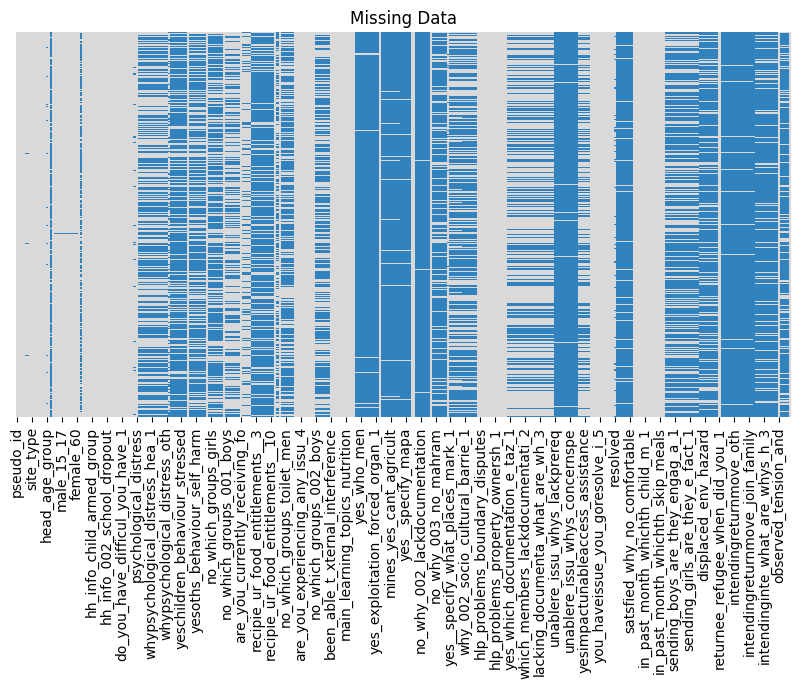

In [8]:
# Heatmap
sns.heatmap(train_data.isnull(),yticklabels = False, cbar = False,cmap = 'tab20c_r')
plt.title('Missing Data')
plt.show()

A lot of columns are full of missing data. But we can't drop most of this columns. This is because this missing data is a meaningful state.

For example, for the column whypsychological_distress_oth:

| Value   | Meaning                                      | Cases    |
| ------- | -------------------------------------------- | -------- |
| 1       | 0 (No)                                       | 4341     |
| 2       | 1 (Yes)                                      | 179      |
| Missing | *(Not asked / Not applicable / No distress)* | **4437** |

In surveys like this:
Missing often means “the question did not apply to the respondent.”

So we can't just drop this kind of columns because we would lose important values.


Besides this, there are some columns that are not useful for model trining. They don't provide any interesting information for us.
- id
- today
- interviewtype
- monitor_gender
- interview_province
- interview_district
- site_001
- assessment_modality

# Categorical Features

In [9]:
print('Non-Null Objects to Be Converted to Category')
print(train_data.select_dtypes(['object']).columns)

Non-Null Objects to Be Converted to Category
Index(['today', 'interviewtype', 'monitor_gender', 'interview_province',
       'interview_district', 'site_001', 'site_type', 'assessment_modality',
       'are_you_headhh', 'respondent_gender', 'status', 'province', 'district',
       'head_age_group', 'marital_status', 'widow_o_martyrdom_certi_cate',
       'what_is_your_occupation_what_i', 'what_is_sizeyour_famil',
       'have_children', 'have_children_001', 'do_you_have_difficul_you_have_1',
       'do_you_have_difficul_using_a__1', 'do_you_have_difficul_ngclimbi_1',
       'do_you_have_difficul_ingconce_1', 'do_you_have_difficul_all_verd_1',
       'using_your_usual_cubeing_unde_1', 'do_you_your_family_m_rotectio_1',
       'psychological_distress', 'children_behaviour', 'oth_members_behaviour',
       'health_facility', 'access_health_facility_no', 'psychological_support',
       'access_mhpss_facility_no_001', 'are_you_currently_receiving_fo',
       'wash_access', 'access_water', '

# Searching relations between different parameters

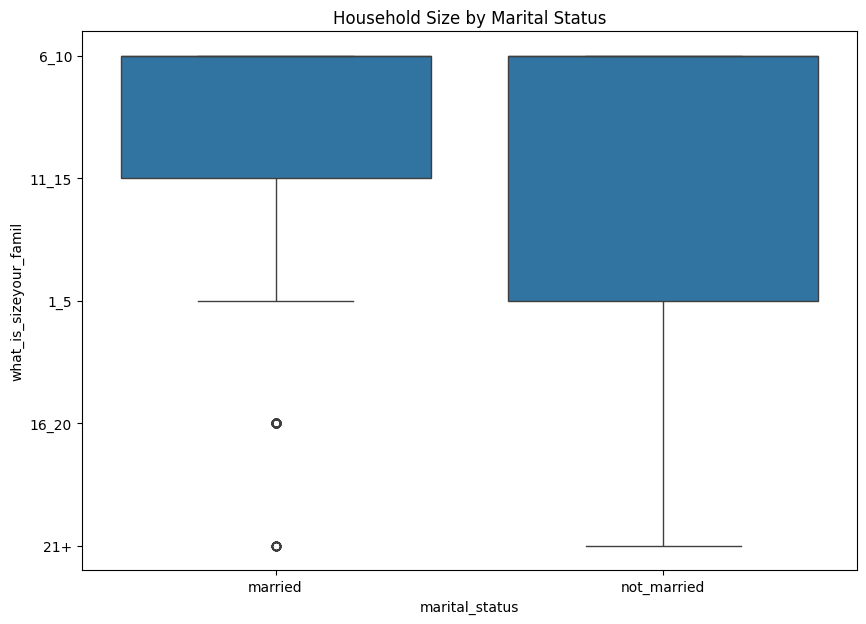

In [10]:
plt.figure(figsize=(10,7))
sns.boxplot(
    x='marital_status',
    y='what_is_sizeyour_famil',
    data=train_data
).set_title('Household Size by Marital Status')
plt.show()

While both married and non-married households commonly range between 6–15 members, extremely large households (21+ members) are observed more frequently among non-married household heads. This suggests extended or dependency-heavy household structures, likely driven by displacement, widowhood, or family aggregation as a coping strategy. These households may require differentiated shelter and support approaches.

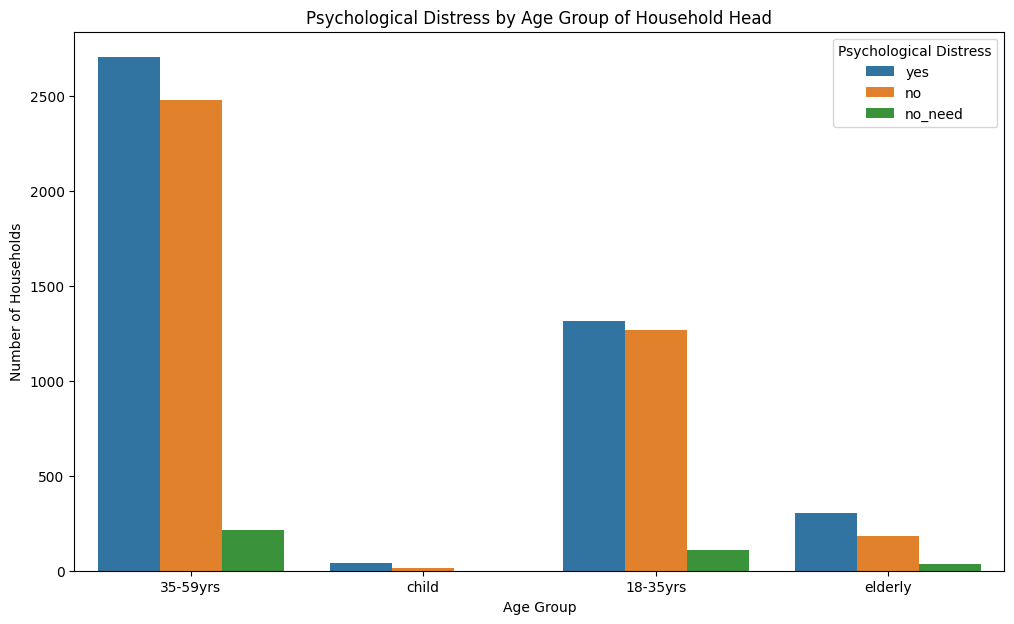

In [11]:
plt.figure(figsize=(12,7))
sns.countplot(
    x='head_age_group',
    hue='psychological_distress',
    data=train_data
)
plt.title('Psychological Distress by Age Group of Household Head')
plt.xlabel('Age Group')
plt.ylabel('Number of Households')
plt.legend(title='Psychological Distress')
plt.show()

Most people report needing psychological support, regardless of age.
Psychological distress is high across all age groups, and no specific age group stands out as having a significantly higher or lower level of distress.

In [12]:
plt.figure(figsize=(120,70))
sns.countplot(
    x='access_health_facility_no',
    hue='psychological_distress',
    data=train_data
)
plt.title('Psychological Distress by Access of health facilities')
plt.xlabel('Access of health facilities')
plt.ylabel('Psychological distress')
plt.legend(title='Psychological Distress')
plt.show()


The majority of people needs psychological help but does not have access to health facilities or the service is just not available.

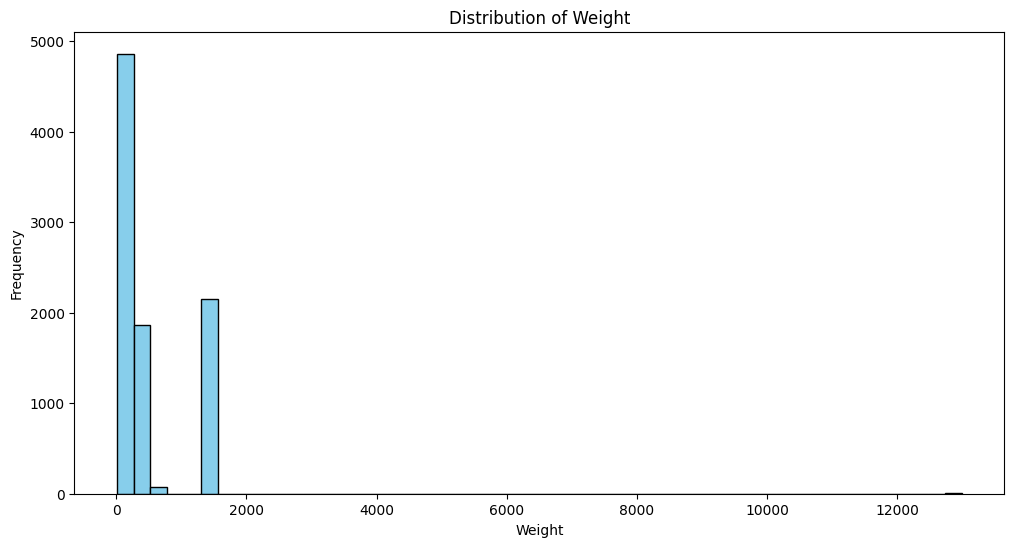

In [13]:
plt.figure(figsize=(12,6))
plt.hist(train_data['weight'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

Some weight values seem inconsistent, likely because different units of measurement were used.
This is very inconsistent, and we don't have any way to predict what the correct values would be, so we are going to drop the column.

# Preprocessing

### **Categorical Features**

In [7]:
# drop unnecessary columns
train_data = train_data.drop(columns=[
    'pseudo_id', 
    'today', 
    'interviewtype', 
    'monitor_gender', 
    'interview_province', 
    'interview_district', 
    'site_001', 
    'assessment_modality'
])

In [8]:
# Identify categorical features
objects = train_data.select_dtypes(['object']).columns

# Convert categorical variables into 'dummy' or indicator variables
for object_ in objects:
    pd.get_dummies(train_data[object_], drop_first = True)

train_data = pd.get_dummies(train_data, drop_first=True)
train_data.head(1)

,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,hh_info_person_health,hh_info_legal_needs,hh_info_school_dropout,hh_info_unable_work,hh_info_child_armed_group,hh_info_family_unity,hh_info_drug_dependence,hh_info_none,hh_info_oth,hh_info_002_person_health,hh_info_002_legal_needs,hh_info_002_school_dropout,hh_info_002_unable_work,hh_info_002_child_armed_group,hh_info_002_family_unity,hh_info_002_drug_dependence,hh_info_002_none,hh_info_002_oth,whypsychological_distress_con_1,whypsychological_distress_com_1,whypsychological_distress_fam_1,whypsychological_distress_out_1,whypsychological_distress_den_1,whypsychological_distress_chi_1,whypsychological_distress_hea_1,whypsychological_distress_den_2,whypsychological_distress_abuse,whypsychological_distress_ear_1,whypsychological_distress_lac_1,whypsychological_distress_foo_1,whypsychological_distress_eco_1,whypsychological_distress_oth,yeschildren_behaviour_withdrawn,yeschildren_behaviour_violent_1,yeschildren_behaviour_eating__1,yeschildren_behaviour_self_harm,yeschildren_behaviour_sad,yeschildren_behaviour_stressed,yeschildren_behaviour_suicida_1,yeschildren_behaviour_oth,yesoths_behaviour_withdrawn,yesoths_behaviour_violent_agg_1,yesoths_behaviour_eating_diso_1,yesoths_behaviour_self_harm,yesoths_behaviour_sad,yesoths_behaviour_stressed,yesoths_behaviour_suicidal_te_1,yesoths_behaviour_oth,no_which_groups_boys,no_which_groups_girls,no_which_groups_men,no_which_groups_women,no_which_groups_elder,no_which_groups_disability,no_which_groups_001_boys,no_which_groups_001_girls,no_which_groups_001_men,no_which_groups_001_women,no_which_groups_001_elder,no_which_groups_001_disability,you_are_not_a_ben_is_why_it_n_1,you_are_not_a_ben_is_why_it_n_2,you_are_not_a_ben_is_why_it_n_3,you_are_not_a_ben_is_why_it_n_4,recipie_ur_food_entitlements__1,recipie_ur_food_entitlements__2,recipie_ur_food_entitlements__3,recipie_ur_food_entitlements__4,recipie_ur_food_entitlements__5,recipie_ur_food_entitlements__6,recipie_ur_food_entitlements__7,recipie_ur_food_entitlements__8,recipie_ur_food_entitlements__9,recipie_ur_food_entitlements__10,recipie_ur_food_entitlements_oth,no_which_groups_toilet_boys,no_which_groups_toilet_girls,no_which_groups_toilet_men,no_which_groups_toilet_women,no_which_groups_toilet_elder,no_which_groups_toilet_disabi_1,are_you_experiencing_any_issu_1,are_you_experiencing_any_issu_2,are_you_experiencing_any_issu_3,are_you_experiencing_any_issu_4,are_you_experiencing_any_issu_5,are_you_experiencing_any_issu_6,are_you_experiencing_any_issu_7,are_you_experiencing_any_issu_8,are_you_experiencing_any_issu_9,no_which_groups_002_boys,no_which_groups_002_girls,no_which_groups_002_men,no_which_groups_002_women,no_which_groups_002_elder,no_which_groups_002_disability,main_learning_topics_access,main_learning_topics_housing,main_learning_topics_complaint,main_learning_topics_document_1,main_learning_topics_cash,main_learning_topics_disability,main_learning_topics_nutrition,main_learning_topics_agriculture,main_learning_topics_eligibility,main_learning_topics_oth,yes_who_boys,yes_who_girls,yes_who_men,yes_who_women,yes_exploitation_labour,yes_exploitation_sexual,yes_exploitation_forced_criminal,yes_exploitation_domestic,yes_exploitation_forced_drug,yes_exploitation_forced_organ_1,mines_yes_children_play,mines_yes_children_school,mines_yes_cant_access_services,mines_yes_cant_colect_water,mines_yes_cant_agricult,mines_yes_cant_graze_animals,mines_yes_oth,no_why_002_discr_exmahr,no_why_002_no_mahram,no_why_002_lackdocumentation,no_why_002_fear_personal_safety,no_why_002_safety_concerns_re_1,no_why_002_presenceexplosive__1,no_why_002_oth,no_why_003_discr_exmahr,no_why_003_no_mahram,no_why_003_lackdocumentation,no_why_003_fear_personal_safety,no_why_003_safety_concerns_re_1,no_why_003_presenceexplosive__1,no_why_003_oth,yes__specify_what_places_mark_1,yes__specify_what_places_wate_1,yes__specify_what_places_scho_1,yes__specify_what_places

In [9]:
# These columns must be 0 if they are not answered
count_cols = [
    'male_0_6','male_7_14','male_15_17','male_18_59','male_60',
    'female_0_6','female_7_14','female_15_17','female_18_59','female_60'
]
train_data[count_cols] = train_data[count_cols].fillna(0)

# NaN to 0
float_cols = train_data.select_dtypes(include='float64').columns
train_data[float_cols] = train_data[float_cols].fillna(0.0)

In [10]:
train_data = train_data.drop(columns=['weight'])
# Weight values are so inconsistent. They use different units so we can not use them.

We will interpret NaN values as unanswered responses. This approach gives more emphasis to positive answers.

In [11]:
train_data.head()

,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,hh_info_person_health,hh_info_legal_needs,hh_info_school_dropout,hh_info_unable_work,hh_info_child_armed_group,hh_info_family_unity,hh_info_drug_dependence,hh_info_none,hh_info_oth,hh_info_002_person_health,hh_info_002_legal_needs,hh_info_002_school_dropout,hh_info_002_unable_work,hh_info_002_child_armed_group,hh_info_002_family_unity,hh_info_002_drug_dependence,hh_info_002_none,hh_info_002_oth,whypsychological_distress_con_1,whypsychological_distress_com_1,whypsychological_distress_fam_1,whypsychological_distress_out_1,whypsychological_distress_den_1,whypsychological_distress_chi_1,whypsychological_distress_hea_1,whypsychological_distress_den_2,whypsychological_distress_abuse,whypsychological_distress_ear_1,whypsychological_distress_lac_1,whypsychological_distress_foo_1,whypsychological_distress_eco_1,whypsychological_distress_oth,yeschildren_behaviour_withdrawn,yeschildren_behaviour_violent_1,yeschildren_behaviour_eating__1,yeschildren_behaviour_self_harm,yeschildren_behaviour_sad,yeschildren_behaviour_stressed,yeschildren_behaviour_suicida_1,yeschildren_behaviour_oth,yesoths_behaviour_withdrawn,yesoths_behaviour_violent_agg_1,yesoths_behaviour_eating_diso_1,yesoths_behaviour_self_harm,yesoths_behaviour_sad,yesoths_behaviour_stressed,yesoths_behaviour_suicidal_te_1,yesoths_behaviour_oth,no_which_groups_boys,no_which_groups_girls,no_which_groups_men,no_which_groups_women,no_which_groups_elder,no_which_groups_disability,no_which_groups_001_boys,no_which_groups_001_girls,no_which_groups_001_men,no_which_groups_001_women,no_which_groups_001_elder,no_which_groups_001_disability,you_are_not_a_ben_is_why_it_n_1,you_are_not_a_ben_is_why_it_n_2,you_are_not_a_ben_is_why_it_n_3,you_are_not_a_ben_is_why_it_n_4,recipie_ur_food_entitlements__1,recipie_ur_food_entitlements__2,recipie_ur_food_entitlements__3,recipie_ur_food_entitlements__4,recipie_ur_food_entitlements__5,recipie_ur_food_entitlements__6,recipie_ur_food_entitlements__7,recipie_ur_food_entitlements__8,recipie_ur_food_entitlements__9,recipie_ur_food_entitlements__10,recipie_ur_food_entitlements_oth,no_which_groups_toilet_boys,no_which_groups_toilet_girls,no_which_groups_toilet_men,no_which_groups_toilet_women,no_which_groups_toilet_elder,no_which_groups_toilet_disabi_1,are_you_experiencing_any_issu_1,are_you_experiencing_any_issu_2,are_you_experiencing_any_issu_3,are_you_experiencing_any_issu_4,are_you_experiencing_any_issu_5,are_you_experiencing_any_issu_6,are_you_experiencing_any_issu_7,are_you_experiencing_any_issu_8,are_you_experiencing_any_issu_9,no_which_groups_002_boys,no_which_groups_002_girls,no_which_groups_002_men,no_which_groups_002_women,no_which_groups_002_elder,no_which_groups_002_disability,main_learning_topics_access,main_learning_topics_housing,main_learning_topics_complaint,main_learning_topics_document_1,main_learning_topics_cash,main_learning_topics_disability,main_learning_topics_nutrition,main_learning_topics_agriculture,main_learning_topics_eligibility,main_learning_topics_oth,yes_who_boys,yes_who_girls,yes_who_men,yes_who_women,yes_exploitation_labour,yes_exploitation_sexual,yes_exploitation_forced_criminal,yes_exploitation_domestic,yes_exploitation_forced_drug,yes_exploitation_forced_organ_1,mines_yes_children_play,mines_yes_children_school,mines_yes_cant_access_services,mines_yes_cant_colect_water,mines_yes_cant_agricult,mines_yes_cant_graze_animals,mines_yes_oth,no_why_002_discr_exmahr,no_why_002_no_mahram,no_why_002_lackdocumentation,no_why_002_fear_personal_safety,no_why_002_safety_concerns_re_1,no_why_002_presenceexplosive__1,no_why_002_oth,no_why_003_discr_exmahr,no_why_003_no_mahram,no_why_003_lackdocumentation,no_why_003_fear_personal_safety,no_why_003_safety_concerns_re_1,no_why_003_presenceexplosive__1,no_why_003_oth,yes__specify_what_places_mark_1,yes__specify_what_places_wate_1,yes__specify_what_places_scho_1,yes__specify_what_places

>Now the data is perfect for a machine learning algorithm:  
- all the data is numeric
- everything is concatenated together

## **MACHINE LEARNING (Clustering models)**

In this section we apply multiple **unsupervised clustering** algorithms to group people with similar need profiles.  
Because our dataset has **no ground-truth labels** (we do not know the “correct” cluster for each person), we cannot evaluate performance using accuracy/precision/recall like in supervised learning. Instead, we compare clusterings by combining:

1) **Internal clustering metrics** (based only on distances within the dataset)  
2) **Practical constraints** required by our use case (usable cluster sizes, limited noise, interpretability)

We will compare the following models:

- **K-Means**
- **Hierarchical (Agglomerative Clustering)**
- **DBSCAN**
- **HDBSCAN**
- **GMM (Gaussian Mixture Models)**

## **Configuration selection workflow (consistent across models)**

To make model comparison fair and to avoid choosing configurations that are mathematically “nice” but operationally unusable, we follow the same 3-step pipeline for every clustering model:

1) **Model-specific interpretation tool → propose candidates / narrow the search**
   Each model has one diagnostic that is *native* to how it works (e.g., elbow for K-Means, dendrogram for Agglomerative, k-distance distribution for DBSCAN, condensed tree/persistence for HDBSCAN, AIC/BIC for GMM).
   We use it to **generate a small set of sensible candidate configurations** or to **restrict the hyperparameter range**.

2) **Internal evaluation (Silhouette / Calinski–Harabasz / Davies–Bouldin) → rank candidates consistently**
   We compute the same three internal metrics for all candidate configurations.
   This gives a **uniform, model-independent comparison signal** across algorithms.

3) **Shared interpretability framework → final selection under project constraints**
   Finally, we select the configuration that best matches our project needs:
   - usable cluster sizes (avoid micro-clusters),
   - manageable number of clusters (actionable profiles),
   - reasonable coverage / noise (when the model supports noise),
   - distinct “top needs” patterns (clusters should mean something).
   
   This step is **model-agnostic** and uses the same scoring logic for every model; we are not adding model-specific inputs here (those are only for candidate generation in Step 1).

---

## **Performance evaluation (why it’s different in clustering)**

Evaluating clustering is not as straightforward as counting “errors”. In clustering, the numeric label values (0, 1, 2, …) are arbitrary: a clustering that labels a group as “2” is not better or worse than the same group being labeled “0”.  
Therefore, evaluation focuses on whether the algorithm produced **meaningful separations** in the data: points inside a cluster should be **more similar** to each other than to points in other clusters, according to some distance/similarity notion.

Because we do **not** have ground-truth shelter assignments, we use **internal validation metrics** from scikit-learn’s documentation (i.e., metrics computed from the dataset and the clustering output itself). These metrics give us a consistent way to compare different algorithms and hyperparameters.

---

## **Internal evaluation metrics (official scikit-learn concepts)**

We use three widely supported internal metrics:

### 1) Silhouette Score (higher is better)

The **Silhouette Coefficient** measures how well-separated clusters are by comparing, for each sample:

- **a** = mean distance to other points in the **same cluster**  
- **b** = mean distance to points in the **nearest different cluster**

Intuition:
- If **a** is much smaller than **b**, the point fits well in its cluster.
- If **a ≈ b**, clusters overlap.
- If **a > b**, the point may be assigned to the wrong cluster.

**Range:** from **-1** (bad clustering) to **+1** (very well separated). Values near **0** often indicate overlapping clusters.

**Why it’s useful in our project**
- We need clusters that represent clearly distinct “profiles of needs”, so we value **separation** and **cohesion**.
- It is a strong baseline metric for checking if the clustering produces clearly defined groups.

**Limitations**
- Silhouette typically favors **convex / “round”** clusters and may underrate valid clusters produced by density-based methods (DBSCAN/HDBSCAN), especially when shapes are irregular or include noise points.

---

### 2) Calinski–Harabasz Index (higher is better)

The **Calinski–Harabasz score** (Variance Ratio Criterion) is based on the ratio:

- **between-cluster dispersion** (how far cluster centers are from each other)
vs
- **within-cluster dispersion** (how spread points are within clusters)

Intuition:
- Higher score means clusters are **compact internally** and **far apart from each other**.

**Why it’s useful in our project**
- Helps detect partitions where clusters represent strongly separated groups of people.
- It is **fast to compute**, which is practical when testing many hyperparameter configurations.

**Limitations**
- Like Silhouette, it tends to favor convex/separable clusters, and may not fully reflect the value of density-based clustering when the data has irregular shapes.

---

### 3) Davies–Bouldin Index (lower is better)

The **Davies–Bouldin index** measures the average “similarity” between each cluster and its most similar cluster, where similarity compares:

- cluster **spread** (how big / dispersed a cluster is)
vs
- cluster **separation** (distance between cluster centers)

**Best value:** **0** (theoretical minimum).  
**Lower** values indicate better cluster separation relative to cluster size.

**Why it’s useful in our project**
- Provides an additional view of compactness vs separation.
- It is simple and commonly reported in clustering comparisons.

**Limitations**
- Uses centroid-based distances, which effectively assumes **Euclidean geometry** and can penalize non-convex cluster shapes.
- Density-based methods may produce structures that are valid but less favored by centroid-based scoring.

---

## **Model-specific interpretation algorithms (short, project-oriented)**

Internal metrics (Silhouette / Calinski–Harabasz / Davies–Bouldin) help us compare clusterings, but they don’t tell us **how to set sensible hyperparameters** or **how to explain the structure** behind the solution.  
Because our goal is to produce **actionable need profiles** (understandable by shelter workers), we add **lightweight, model-specific tools** that help propose a *small set of plausible candidates* before we apply the shared interpretability framework.

### K-Means
- **Elbow (knee) on inertia**  
  Used only to restrict `n_clusters` to a plausible range (diminishing returns), then validated with metrics + usability.

### Hierarchical (Agglomerative)
- **Dendrogram / linkage distance inspection**  
  Used to find natural “cut points” (big merge-distance jumps) to propose candidate `n_clusters`.

### DBSCAN
- **k-distance distribution (k-distance plot)**  
  Used to propose a sensible **`eps` scale** (knee + nearby quantiles) and restrict the eps search space.  
  It does **not** pick the best configuration alone; `min_samples` is tested over a small set because it can change the clustering substantially.

### HDBSCAN
- **Condensed tree + persistence (stability)**  
  Used to interpret what the model is selecting from the density hierarchy and to propose a reasonable parameter region (`min_cluster_size`, `min_samples`) by favoring **persistent, non-fragile branches** with usable sizes.

### GMM (Gaussian Mixture Models)
- **AIC/BIC vs number of components**  
  Used as an elbow-like selection for `n_components` (model complexity vs fit). We then validate candidates with metrics + usability because AIC/BIC can disagree (e.g., BIC often prefers simpler models).

In all cases, these model-specific tools are used to generate **candidates**. The final decision is always made using the same **model-agnostic interpretability scoring** (sizes + k range + coverage/noise + distinct profiles).

## Data preparation

First, we will split the data: 75% for training and 25% for testing.

In [12]:
from sklearn.model_selection import train_test_split

# Split data
train_df, test_df = train_test_split(train_data, test_size=0.25, random_state=42)
train_df.to_csv('../data/train_data.csv', index=False)
test_df.to_csv('../data/test_data.csv', index=False)

### Scaled parameters
We use scaled data (X_scaled) for **model training** because most machine learning algorithms rely on distance calculations.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df)

### Umap
We use UMAP only for **visualization purposes**, not for model training.

In [16]:
import umap

try:
    reducer = umap.UMAP(n_components=2,
                       n_neighbors=30,
                       min_dist=0.1,
                       metric='euclidean',
                       random_state=42,
                       verbose=True)
    embedding = reducer.fit_transform(X_scaled)
    train_df['umap1'] = embedding[:, 0]
    train_df['umap2'] = embedding[:, 1]
except Exception as e:
    print("Couldn't use Umap 2D:", e)
    embedding = X_scaled[:, :2]
    train_df['umap1'] = embedding[:, 0]
    train_df['umap2'] = embedding[:, 1]

UMAP(n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Mon Jan 19 08:16:21 2026 Construct fuzzy simplicial set
Mon Jan 19 08:16:21 2026 Finding Nearest Neighbors
Mon Jan 19 08:16:21 2026 Building RP forest with 9 trees
Mon Jan 19 08:16:21 2026 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Mon Jan 19 08:16:25 2026 Finished Nearest Neighbor Search
Mon Jan 19 08:16:29 2026 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jan 19 08:17:09 2026 Finished embedding


## Interpretation

The next code defines a shared **interpretability framework** that we will apply to all clustering models.

Its purpose is to select, for each model, the configuration that best matches our **project constraints** (fixed targets below):

- **Usable cluster sizes**
  - Target minimum cluster size: **20**
  - “Micro-cluster” threshold (**strong penalty**): **< 10**
  - Goal: avoid solutions that create many clusters smaller than 20, even if other metrics look good.

- **Manageable number of clusters**
  - Preferred range: **10–30** clusters
  - Soft-penalize below **6** (too coarse to be actionable)
  - Soft-penalize above **40** (too many profiles for staff)
  - We still allow out-of-range solutions to compete, but they must “earn it” by being exceptionally interpretable.

- **Reasonable coverage (noise / unassigned points when supported)**
  - Target noise ratio: **≤ 0.30**
  - Penalty grows quickly above **0.30** (and becomes very small in practice as noise increases).
  - Rationale: if too many people are labeled noise, the tool becomes less useful for assignment/support workflows (many new cases may return “no cluster”).

- **Balanced profiles (avoid one dominant cluster)**
  - Target max cluster share (`max_share`): **≤ 0.50**
  - Strong penalty when `max_share` grows above the target.
  - We also monitor balance via **effective_k / balance_penalty** to detect “one big cluster + tiny islands”, even when `k` looks acceptable.
  - Rationale: a solution where one cluster contains most people usually collapses profiles into “default group + exceptions”, which is not what we want.

- **Clear “top needs” patterns**
  - We keep the existing signals:
    - **strength** (how large the average feature-lift is)
    - **distinctness** (low overlap of top features between clusters)
  - These are *not* hard thresholds, but they must remain high enough to justify the chosen granularity.

This matters because internal metrics (Silhouette / CH / DB) often reward solutions that are **mathematically neat** but **operationally unusable** (e.g., very few clusters, or many tiny clusters, or one dominant cluster).
By using the same interpretability scoring logic across models, we ensure configuration selection is **consistent and comparable**, and aligned with the real goal: producing **actionable need profiles**.

Importantly, this framework is **model-agnostic**: it does not depend on a specific algorithm’s special diagnostics (dendrogram, k-distance, condensed tree). Those tools are used to propose candidates, but the **final ranking** here is always based on the same usability + interpretability criteria.


### Concrete penalty plan (values we will implement)

- **Cluster size penalty (too small)**
  - `min_size_target = 20`
  - `size_penalty = clamp(min_cluster_size / 20, 0, 1)`

- **Micro-cluster penalty (very small clusters)**
  - Threshold: `< 10`
  - Example: `micro_penalty = clamp(min_cluster_size / 10, 0, 1)`
  - (This makes configurations with clusters under 10 get strongly down-weighted.)

- **Two-sided k penalty (prefer 10–30)**
  - `k_low = 10`, `k_high = 30`
  - If `k < 10`: penalize like `k / 10`
  - If `k > 30`: penalize like `30 / k`
  - If `10 ≤ k ≤ 30`: penalty = `1.0`

- **Noise penalty (only for algorithms that output noise)**
  - `noise_target = 0.30`
  - If `noise_ratio ≤ 0.30`: `noise_penalty = 1.0`
  - Else: `noise_penalty = 0.30 / noise_ratio` (drops fast above 0.30)

- **Dominance penalty (largest cluster share)**
  - `max_share_target = 0.50`
  - If `max_share ≤ 0.50`: `dominance_penalty = 1.0`
  - Else: `dominance_penalty = 0.50 / max_share`
  - (This strongly punishes cases like max_share ≈ 0.90.)

- **Balance penalty (degenerate size distribution)**
  - Track imbalance using `effective_k` (or another concentration measure).
  - Apply a penalty when the mass is concentrated into very few clusters even if `k` is large.
  - Example idea: down-weight solutions where `effective_k` is very low compared to `k`.

**Next action:** update the interpretability score to multiply by  
`size_penalty * micro_penalty * k_penalty * noise_penalty * dominance_penalty * balance_penalty`,  
then re-rank candidates (DBSCAN / HDBSCAN / GMM / etc.) and select the configuration that yields **multiple balanced, usable need profiles**.


In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# ----------------------------
# A) Fit+predict for ANY clustering estimator
# ----------------------------
def fit_predict_any(estimator, X):
    """
    Works with sklearn clusterers (fit_predict), and with models that do (fit + predict).
    """
    if hasattr(estimator, "fit_predict"):
        return estimator.fit_predict(X)
    estimator.fit(X)
    if hasattr(estimator, "predict"):
        return estimator.predict(X)
    raise ValueError("Estimator must implement fit_predict or (fit + predict).")

# ----------------------------
# B) Internal metrics (handles noise label = -1)  [UPDATED robustness]
# ----------------------------
def internal_metrics(X, labels, sample_size=2000, random_state=42, noise_label=-1):
    """
    Returns silhouette, calinski_harabasz, davies_bouldin.
    If noise exists, compute metrics on non-noise points only.
    Robust to degenerate cases (1 cluster, too few points, etc.).
    """
    labels = np.asarray(labels)

    mask = labels != noise_label
    X_use = X[mask]
    y_use = labels[mask]

    n_use = X_use.shape[0]
    n_labels = len(np.unique(y_use))

    # Metrics need at least 2 clusters and enough samples
    if n_use < 3 or n_labels < 2 or n_labels >= n_use:
        return {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan}

    ss = min(sample_size, n_use)
    sil = silhouette_score(X_use, y_use, sample_size=ss, random_state=random_state)
    ch  = calinski_harabasz_score(X_use, y_use)
    db  = davies_bouldin_score(X_use, y_use)

    return {"silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db}


# ----------------------------
# C) Cluster profiles + interpretability score (model-agnostic) [UPDATED penalties]
# ----------------------------
def profile_and_interpretability(
    df_features, labels,
    top_n=8, min_size_target=20, k_preferred=30, noise_target=0.20,
    noise_label=-1, k_min=10, k_max=40
):
    """
    Same inputs / same usage.
    Adds stronger penalties for:
      - too few clusters
      - one dominant cluster (max_share)
      - "effectively one cluster" (effective_k)
      - micro-clusters (<10)
    """

    feat_df = df_features.select_dtypes(include=[np.number]).copy()
    global_mean = feat_df.mean(axis=0)

    labels = np.asarray(labels)
    n = len(labels)

    noise_mask = labels == noise_label
    noise_ratio = float(noise_mask.mean()) if np.any(noise_mask) else 0.0

    clusters = [c for c in np.unique(labels) if c != noise_label]
    k = len(clusters)
    if k == 0:
        empty = pd.DataFrame(columns=["cluster", "n", "%", "top_features", "top_lifts"])
        info = dict(
            k=0, min_cluster_size=0, noise_ratio=noise_ratio,
            max_share=1.0, effective_k=0.0,
            strength=0.0, distinctness=0.0,
            size_penalty=0.0, micro_penalty=0.0, k_penalty=0.0,
            noise_penalty=0.0, dominance_penalty=0.0, balance_penalty=0.0
        )
        return 0.0, info, empty

    counts = np.array([(labels == c).sum() for c in clusters], dtype=int)
    min_size = int(counts.min())
    non_noise_n = int(counts.sum())

    # shares among non-noise points
    p = counts / max(non_noise_n, 1)
    max_share = float(p.max())

    # effective number of clusters (Simpson / Hill number)
    effective_k = float(1.0 / max(np.sum(p ** 2), 1e-12))

    # ---------- strength + profiles ----------
    top_sets = []
    per_cluster_strength = []
    profiles = []

    for c, n_c in zip(clusters, counts):
        mask = labels == c
        cm = feat_df.loc[mask].mean(axis=0)
        lift = cm - global_mean
        abs_lift = lift.abs()

        top = abs_lift.sort_values(ascending=False).head(top_n)
        top_features = top.index.tolist()
        top_lifts = [float(lift[f]) for f in top_features]

        top_sets.append(set(top_features))
        per_cluster_strength.append(float(top.mean()))

        profiles.append({
            "cluster": int(c),
            "n": int(n_c),
            "%": 100.0 * int(n_c) / n,
            "top_features": top_features,
            "top_lifts": top_lifts
        })

    weights = counts / max(counts.sum(), 1)
    strength = float(np.sum(weights * np.array(per_cluster_strength)))

    overlaps = []
    for i in range(k):
        for j in range(i + 1, k):
            inter = len(top_sets[i] & top_sets[j])
            union = len(top_sets[i] | top_sets[j])
            overlaps.append(inter / union if union else 1.0)
    avg_overlap = float(np.mean(overlaps)) if overlaps else 1.0
    distinctness = 1.0 - avg_overlap

    # ---------- penalties (steeper + balance-aware) ----------
    MICRO_TARGET = 10  # "hard warning" zone
    micro_penalty = min(1.0, min_size / MICRO_TARGET)

    # cluster-size penalty (target 20)
    size_penalty = min(1.0, min_size / min_size_target)

    # two-sided k penalty: prefer k in [k_min, k_preferred] (10–30 in your writeup)
    K_LOW = 10
    K_HIGH = 30
    P_K = 3  # steeper than linear

    if k < K_LOW:
        k_penalty = (k / K_LOW) ** P_K
    elif k > K_HIGH:
        k_penalty = (K_HIGH / k) ** P_K
    else:
        k_penalty = 1.0

    # extra "too coarse" penalty below 6 (soft, but steep)
    COARSE_MIN = 6
    if k < COARSE_MIN:
        k_penalty *= (k / COARSE_MIN) ** 2

    # noise penalty (same logic, but you control noise_target via evaluate_candidates)
    noise_penalty = 1.0 if noise_ratio <= noise_target else (noise_target / max(noise_ratio, 1e-12))

    # dominance penalty: target max_share <= 0.50, strong penalty above 0.70
    MAX_SHARE_TARGET = 0.50
    STRONG_ZONE = 0.70

    if max_share <= MAX_SHARE_TARGET:
        dominance_penalty = 1.0
    else:
        base = MAX_SHARE_TARGET / max_share
        # if max_share is really bad (>0.70), punish much more
        dominance_penalty = base ** (4 if max_share > STRONG_ZONE else 2)

    dominance_penalty = float(np.clip(dominance_penalty, 0.0, 1.0))

    # balance penalty using effective_k (kills "one giant + islands")
    # tie it to K_LOW so no new input is needed
    balance_penalty = float(min(1.0, effective_k / K_LOW))

    interpretability = (
        strength
        * distinctness
        * size_penalty
        * micro_penalty
        * k_penalty
        * noise_penalty
        * dominance_penalty
        * balance_penalty
    )

    profiles_df = pd.DataFrame(profiles).sort_values("n", ascending=False)

    info = dict(
        k=k,
        min_cluster_size=min_size,
        noise_ratio=noise_ratio,
        max_share=max_share,
        effective_k=effective_k,
        strength=strength,
        distinctness=distinctness,
        size_penalty=size_penalty,
        micro_penalty=micro_penalty,
        k_penalty=k_penalty,
        noise_penalty=noise_penalty,
        dominance_penalty=dominance_penalty,
        balance_penalty=balance_penalty
    )
    return interpretability, info, profiles_df



# ----------------------------
# E) Evaluate a list of candidate estimators (model-agnostic)
# ----------------------------
def evaluate_candidates(
    candidates, X_fit, df_features,
    silhouette_sample=2000, noise_label=-1,
    top_n=8, min_size_target=20, k_preferred=30, noise_target=0.20
):
    """
    candidates: list of dicts: {"name": str, "estimator": obj}
    Returns: ranked DataFrame + best labels + best profiles
    """
    rows = []
    cache = {}

    for cand in candidates:
        name = cand["name"]
        est = cand["estimator"]

        labels = fit_predict_any(est, X_fit)
        cache[name] = labels

        metrics = internal_metrics(X_fit, labels, sample_size=silhouette_sample, noise_label=noise_label)
        interp, info, profiles = profile_and_interpretability(
            df_features, labels,
            top_n=top_n,
            min_size_target=min_size_target,
            k_preferred=k_preferred,
            noise_target=noise_target,
            noise_label=noise_label
        )

        rows.append({
            "candidate": name,
            "interpretability": interp,
            **metrics,
            **info,
            "params": est.get_params() if hasattr(est, "get_params") else {}
        })

    ranked = pd.DataFrame(rows).sort_values("interpretability", ascending=False)
    best_name = ranked.iloc[0]["candidate"]
    best_labels = cache[best_name]
    best_profiles = profile_and_interpretability(
        df_features, best_labels,
        top_n=top_n,
        min_size_target=min_size_target,
        k_preferred=k_preferred,
        noise_target=noise_target,
        noise_label=noise_label
    )[2]

    return ranked, best_name, best_labels, best_profiles


# **K-Means**

**K-Means** is a clustering algorithm that partitions the dataset into **clusters** by minimizing the **within-cluster sum of squares**. Each cluster is represented by its **centroid**, which is the mean of all points assigned to that cluster. In practice, the algorithm iterates between:

1) Assigning each person to the nearest centroid  
2) Updating each centroid as the mean of the assigned people until centroids stop moving significantly.

K-Means requires choosing **K (the number of clusters)** in advance. The algorithm then finds k centroids that minimize inertia (also called WCSS):

- Inertia / WCSS = sum of squared Euclidean distances from each point to its assigned centroid.
- Lower inertia means points are closer to their centroids (more compact clusters).

### **Why K-Means is useful for our project**
We include K-Means as a strong baseline because it matches several practical needs:

- **Fast and scalable:** with many features, we can still test multiple values of **K** and compare results efficiently.
- **Simple cluster representation:** each cluster has a centroid, which makes it easier to build **cluster profiles** (e.g., “this group tends to have higher legal needs and health issues”).
- **Good for “prototype” groups:** if the data naturally forms compact groups, K-Means can produce clear, well-separated clusters that are easy to explain to non-technical users.
- **Stable comparison reference:** even if another model wins, K-Means provides a consistent benchmark for evaluating whether more complex methods actually add value.

### **Limitations (important for interpretation)**
- K-Means works best when clusters are **roughly convex and similarly sized**. If people’s needs form irregular shapes or variable-density groups, density-based methods (DBSCAN/HDBSCAN) may capture structure better.
- It can converge to a **local minimum**, so it is typically run multiple times with smart initialization (e.g., **k-means++**) to improve consistency.
- In high-dimensional spaces, Euclidean distances can become less informative; therefore K-Means results should be interpreted alongside our full evaluation framework (metrics + practical constraints + interpretability).

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

dfkmean = train_df

## **Model-specific algorithm: Elbow method**

The elbow is the k where the curve changes from:

- **Steep decrease** (adding clusters significantly improves compactness)
to
- **Slow decrease** (extra clusters only reduce inertia slightly)

Interpretation:

- Before the elbow: K-Means is underfitting (clusters too coarse).

- After the elbow: gains are small; extra clusters mostly split existing groups into smaller ones.

Because K-Means directly optimizes inertia, inertia will always decrease as k increases (more centroids → better fit). Therefore, we are not looking for the minimum inertia (that would be k = n_samples), but for a point where adding more clusters yields diminishing returns.

**Important limitation:** elbow is a heuristic. In many real datasets, the curve is smooth and there is no sharp elbow. That’s why we use elbow only to restrict k to a plausible range, then validate with internal metrics + practical constraints.

### Choosing a k range

In theory, we could test any `k` from **2** up to **one cluster per person** (`k = n_samples`). However, this is not practical and it is rarely useful:

- very large `k` values reduce inertia automatically (even if clusters are not meaningful),
- they create many tiny clusters that are hard to interpret and not actionable for our project,
- and they significantly increase computation time.

Therefore, we restrict the search to a **reasonable k range** aligned with our practical constraints (interpretability and minimum cluster size). This avoids running unnecessary configurations and keeps the evaluation focused on clusterings that could realistically be used by shelter workers.

In [ ]:
n_samples = X_scaled.shape[0]

K_MIN = 2
K_MAX = int(n_samples / 10)
K_MAX = min(K_MAX, n_samples)

K_MAX = max(K_MAX, K_MIN + 1)

step = max(1, (K_MAX - K_MIN) // 40)

ks = np.arange(K_MIN, K_MAX + 1, step, dtype=int)

if ks[-1] != K_MAX:
    ks = np.append(ks, K_MAX)

In [145]:
inertias = []

for k in ks:
    km = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init="auto",
        random_state=42
    )
    km.fit(X_scaled)
    inertias.append(km.inertia_)

inertias = np.array(inertias, dtype=float)

### Automatic knee detection

Returns index of the point with maximum perpendicular distance to the line connecting the first and last points (a common elbow heuristic).

In [ ]:
def knee_max_distance(x, y):
    x = x.astype(float)
    y = y.astype(float)

    xn = (x - x.min()) / (x.max() - x.min() + 1e-12)
    yn = (y - y.min()) / (y.max() - y.min() + 1e-12)

    p = np.column_stack([xn, yn])
    p1, p2 = p[0], p[-1]
    line = p2 - p1
    line_norm = np.linalg.norm(line) + 1e-12
    line_unit = line / line_norm

    v = p - p1
    proj = (v @ line_unit)[:, None] * line_unit[None, :]
    perp = v - proj
    dist = np.linalg.norm(perp, axis=1)

    idx = int(np.argmax(dist))
    return idx, dist

elbow_idx, elbow_dist = knee_max_distance(ks, inertias)
k_elbow = int(ks[elbow_idx])

print(f"Elbow candidate (knee heuristic): k = {k_elbow}")

Elbow candidate (knee heuristic): k = 146


### Plot inertia + elbow

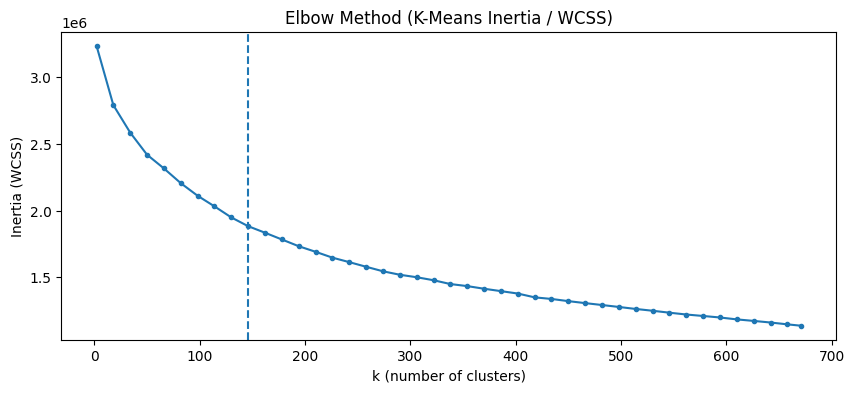

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(ks, inertias, marker=".")
plt.axvline(k_elbow, linestyle="--")
plt.title("Elbow Method (K-Means Inertia / WCSS)")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia (WCSS)")
plt.show()

In [57]:
n_clusters = k_elbow
print("Best n_clusters for K-Means: " + str(n_clusters))

Best n_clusters for K-Means: 146


## Elbow interpretation (K-Means inertia / WCSS)

The elbow around **k ≈ 146** suggests the dataset contains **substantial fine-grained structure**: inertia keeps improving up to relatively high k, meaning many small need-pattern variations can be separated in the scaled feature space.

However, **k = 146 is not operationally actionable** for our use case (too many micro-profiles for staff to interpret and apply). Therefore, the elbow is used only to **generate candidates / understand granularity**, not to pick the final k.

Even if it is not suitable as the final choice, we still include **k ≈ 146 (and nearby values)** in the evaluation as a **reference point** and for **fair comparison** under the full framework (internal metrics + project constraints + interpretability), alongside smaller k values and other clustering models.

## **Internal Evaluation Metrics**

As stated in the **Modeling Introduction**, we do not have ground-truth labels for clustering.  
Therefore, we evaluate and tune K-Means using **internal validation metrics** (computed from the data and the clustering result). These metrics help us:

- **select the best K-Means configuration** (mainly the choice of `k`)
- **compare K-Means fairly** against the other clustering models later

### **1) Silhouette Score (higher is better)**

Measures how well each person fits within their assigned cluster compared to the nearest other cluster.  
Higher values indicate **denser** and **better separated** clusters.

In [61]:
from sklearn.metrics import silhouette_score

In [ ]:
results = []

sample_size = min(int(n_samples/3), X_scaled.shape[0])
for k in ks:
    km = KMeans(n_clusters=int(k), init="k-means++", n_init="auto", random_state=42)
    labels = km.fit_predict(X_scaled)

    score = silhouette_score(X_scaled, labels, sample_size=sample_size, random_state=42)

    results.append((score, int(k), km.inertia_))

results.sort(key=lambda x: x[0], reverse=True)

print("Top k by Silhouette (higher is better):")
print("silhouette | k | inertia")
for score, k, inertia in results[:15]:
    print(f"{score:9.5f} | {k:4d} | {inertia:.3e}")

Top k by Silhouette (higher is better):
silhouette | k | inertia
  0.09306 |    2 | 3.236e+06
  0.07621 |  671 | 1.137e+06
  0.07546 |  658 | 1.148e+06
  0.07372 |  642 | 1.162e+06
  0.07319 |  610 | 1.185e+06
  0.07314 |  626 | 1.174e+06
  0.07278 |  594 | 1.199e+06
  0.07250 |  562 | 1.222e+06
  0.07201 |  578 | 1.211e+06
  0.07144 |  546 | 1.235e+06
  0.07079 |  450 | 1.322e+06
  0.07059 |  418 | 1.350e+06
  0.07054 |  530 | 1.250e+06
  0.07008 |  370 | 1.415e+06
  0.06993 |  514 | 1.263e+06


### Silhouette interpretation

The Silhouette scores obtained for K-Means are **very low** (best ≈ 0.09), which suggests that the clusters are **not strongly separated** in our current feature space. This does not necessarily mean K-Means is incorrect, but it indicates that the dataset may not contain clearly convex, well-separated groups (or that distances in high-dimensional space make separation weak).

The top score occurs at **k = 2**, which is likely **too coarse** to be useful for our project, while many of the next best scores appear at **very large k** values (≈ 450–670), which would create too many small clusters and would be **not actionable or interpretable** for shelter workers.

Therefore, we will **not** select `k` by simply taking the global best Silhouette. Instead, we will restrict `k` to a **practical range** (e.g., 4–30) and choose candidates using our full framework: Silhouette + Calinski–Harabasz + Davies–Bouldin, stability checks, and cluster interpretability (clear “top needs” per group).

### **2) Calinski–Harabasz Index (higher is better)**

Measures the ratio of **between-cluster separation** to **within-cluster compactness**.  
Higher values indicate clusters that are **compact and far apart**, and it is fast to compute.

In [ ]:
from sklearn.metrics import calinski_harabasz_score

In [ ]:
results = []

for k in ks:
    km = KMeans(n_clusters=int(k), init="k-means++", n_init="auto", random_state=42)
    labels = km.fit_predict(X_scaled)

    score = calinski_harabasz_score(X_scaled, labels)

    results.append((score, int(k), km.inertia_))

results.sort(key=lambda x: x[0], reverse=True)

print("Top k by Calinski–Harabasz (higher is better):")
print("calinski_harabasz | k | inertia")
for score, k, inertia in results[:15]:
    print(f"{score:16.2f} | {k:4d} | {inertia:.3e}")

Top k by Calinski–Harabasz (higher is better):
calinski_harabasz | k | inertia
          197.98 |    2 | 3.236e+06
           76.37 |   18 | 2.791e+06
           58.50 |   34 | 2.585e+06
           51.32 |   50 | 2.419e+06
           44.83 |   66 | 2.317e+06
           41.79 |   82 | 2.206e+06
           39.42 |   98 | 2.112e+06
           37.36 |  114 | 2.032e+06
           36.22 |  130 | 1.949e+06
           34.84 |  146 | 1.884e+06
           33.23 |  162 | 1.834e+06
           32.05 |  178 | 1.784e+06
           31.16 |  194 | 1.733e+06
           30.18 |  210 | 1.692e+06
           29.48 |  226 | 1.648e+06


### Calinski–Harabasz interpretation

The Calinski–Harabasz (CH) index peaks at **k = 2**, suggesting the data contains one very strong **coarse split** (two large groups that are far apart relative to their internal spread).  
We **do not discard k = 2**: it is useful as a **baseline** to understand the strongest global separation and to compare how other models capture (or refine) that structure.

However, **k = 2 is too broad** to produce actionable shelter “need profiles”. Therefore, we also carry forward **k ≈ 18** as a key candidate because it is the best-scoring option **within a practical, interpretable range**, likely offering multiple distinct profiles while remaining manageable for staff.

Both **k = 2** (coarse baseline) and **k = 18** (actionable granularity) will be evaluated under the full framework (internal metrics + constraints + interpretability) alongside other k values and other clustering models.


### **3) Davies–Bouldin Index (lower is better)**

Measures the average similarity between each cluster and its most similar cluster, combining **cluster spread** and **centroid separation**.  
Lower values indicate **better separated** clusters relative to their internal dispersion.

In [ ]:
from sklearn.metrics import davies_bouldin_score

In [ ]:
results = []

for k in ks:
    km = KMeans(n_clusters=int(k), init="k-means++", n_init="auto", random_state=42)
    labels = km.fit_predict(X_scaled)

    score = davies_bouldin_score(X_scaled, labels)

    results.append((score, int(k), km.inertia_))

results.sort(key=lambda x: x[0])

print("Top k by Davies–Bouldin (lower is better):")
print("davies_bouldin | k | inertia")
for score, k, inertia in results[:15]:
    print(f"{score:13.5f} | {k:4d} | {inertia:.3e}")

Top k by Davies–Bouldin (lower is better):
davies_bouldin | k | inertia
      1.69137 |  671 | 1.137e+06
      1.70185 |  658 | 1.148e+06
      1.70859 |  642 | 1.162e+06
      1.72534 |  626 | 1.174e+06
      1.73376 |  610 | 1.185e+06
      1.75020 |  594 | 1.199e+06
      1.76255 |  578 | 1.211e+06
      1.77017 |  562 | 1.222e+06
      1.78746 |  546 | 1.235e+06
      1.80076 |  530 | 1.250e+06
      1.82047 |  498 | 1.278e+06
      1.82238 |  514 | 1.263e+06
      1.84161 |  482 | 1.293e+06
      1.87389 |  466 | 1.307e+06
      1.88458 |  450 | 1.322e+06


### Davies-Bouldin interpretation

The lowest Davies–Bouldin scores are achieved at very large `k` values (≈450–671), which likely reflects over-splitting the dataset into many small clusters rather than discovering a practical set of profiles. Since our project requires a limited, interpretable number of clusters, we will not choose `k` based on the global minimum DB score. Instead, we will compute Davies–Bouldin only within our practical `k` range (e.g., 4–30) and use it as one part of the overall selection framework, together with Silhouette, Calinski–Harabasz and interpretability constraints.


## **Interpretability**

Internal clustering metrics (Silhouette, Davies–Bouldin and Calinski–Harabasz) and model-specific heuristics (e.g., Elbow for K-Means, k-distance knee for DBSCAN, stability for HDBSCAN, dendrogram cut for Hierarchical, AIC/BIC for GMM) propose **candidate configurations**, but they do not guarantee that the resulting clusters are **usable and explainable** for shelter workers.

To select the **most interpretable** configuration for any clustering model, we evaluate each candidate using **cluster profiles** computed in the original feature space:

For each cluster we compute:
- **Cluster mean** per feature (for binary need features: interpreted as a proportion),
- **Lift vs global mean**: `lift = cluster_mean − global_mean`,
- **Top-N distinguishing features**: features with the largest `|lift|` (these become the “needs summary”).

We then compute an **Interpretability Score** for each candidate configuration:

1) **Profile Strength (clarity of patterns)**  
   For each cluster, take the average `|lift|` over its Top-N features.  
   Combine across clusters using cluster-size weights.  
   → High when clusters have clear, strong deviations from the global profile.

2) **Profile Distinctness (non-redundant summaries)**  
   For each pair of clusters, compute the Jaccard overlap between their Top-N feature sets.  
   Distinctness = `1 − average_overlap`.  
   → High when clusters describe different “needs summaries” rather than repeating the same patterns.

3) **Usability penalties (project constraints)**  
   - **Small-cluster penalty**: downweights solutions with tiny clusters (unstable / not actionable).  
   - **Too-many-clusters penalty**: downweights solutions that produce too many profiles to interpret.  
   - **Noise penalty** (for DBSCAN/HDBSCAN): downweights solutions with excessive noise ratio.

Final score (higher is better):
`Interpretability = Strength × Distinctness × SizePenalty × KPenalty × NoisePenalty`

This approach is model-agnostic: only the **candidate configurations** are model-specific; the interpretability scoring and profile reporting are the same for K-Means, DBSCAN, HDBSCAN, Hierarchical, and GMM.

### Candidates (K-Means)

#### Best candidates
- **Elbow (model-specific):** k = **146**
- **Silhouette (highest):** k = **2**
- **Calinski–Harabasz (best usable granularity):** k = **18**
- **Davies–Bouldin (lowest):** k = **671**

#### Other suggested candidates (next best from each metric)
- **Silhouette (next):** k = **671**, **658**, **642**
- **Calinski–Harabasz (next):** k = **34**, **50**, **66**
- **Davies–Bouldin (next):** k = **658**, **642**, **626**


In [252]:
from sklearn.cluster import KMeans

candidates = [
    {"name":"KMeans (Elbow k=146)","estimator":KMeans(n_clusters=146,init="k-means++",n_init="auto",random_state=42)},
    {"name":"KMeans (Silhouette k=2)","estimator":KMeans(n_clusters=2,init="k-means++",n_init="auto",random_state=42)},
    {"name":"KMeans (Silhouette k=671)","estimator":KMeans(n_clusters=671,init="k-means++",n_init="auto",random_state=42)},
    {"name":"KMeans (Silhouette k=658)","estimator":KMeans(n_clusters=658,init="k-means++",n_init="auto",random_state=42)},
    {"name":"KMeans (CH k=18)","estimator":KMeans(n_clusters=18,init="k-means++",n_init="auto",random_state=42)},
    {"name":"KMeans (CH k=34)","estimator":KMeans(n_clusters=34,init="k-means++",n_init="auto",random_state=42)},
    {"name":"KMeans (CH k=50)","estimator":KMeans(n_clusters=50,init="k-means++",n_init="auto",random_state=42)},
    {"name":"KMeans (DB k=671)","estimator":KMeans(n_clusters=671,init="k-means++",n_init="auto",random_state=42)},
    {"name":"KMeans (DB k=658)","estimator":KMeans(n_clusters=658,init="k-means++",n_init="auto",random_state=42)},
    {"name":"KMeans (DB k=642)","estimator":KMeans(n_clusters=642,init="k-means++",n_init="auto",random_state=42)},
]



df_features_clean = dfkmean.drop(columns=["umap1", "umap2", "cluster"], errors="ignore").copy()

ranked, best_name, best_labels, best_profiles = evaluate_candidates(
    candidates=candidates,
    X_fit=X_scaled,
    df_features=df_features_clean,
    silhouette_sample=min(2000, X_scaled.shape[0])
)

print(ranked[[
    "candidate","interpretability","silhouette","calinski_harabasz","davies_bouldin",
    "k","effective_k","noise_ratio","max_share",
    "min_cluster_size","size_penalty","micro_penalty",
    "k_penalty","noise_penalty","dominance_penalty","balance_penalty",
    "strength","distinctness"
]].to_string(index=False, float_format=lambda x: f"{x:0.6f}"))

print("\nBEST:", best_name)
print("\nBest cluster profiles (sorted by size):")
print(best_profiles[["cluster","n","%","top_features","top_lifts"]].to_string(index=False, float_format=lambda x: f"{x:0.6f}"))

best_estimator = next(c["estimator"] for c in candidates if c["name"] == best_name)

                candidate  interpretability  silhouette  calinski_harabasz  davies_bouldin   k  effective_k  noise_ratio  max_share  min_cluster_size  size_penalty  micro_penalty  k_penalty  noise_penalty  dominance_penalty  balance_penalty  strength  distinctness
         KMeans (CH k=18)          0.403576   -0.050828          76.372228        3.641419  18     9.537516     0.000000   0.216615                78      1.000000       1.000000   1.000000       1.000000           1.000000         0.953752  0.434670      0.973488
         KMeans (CH k=34)          0.006322   -0.013406          58.499103        3.112708  34    12.783476     0.000000   0.221676                 2      0.100000       0.200000   0.686953       1.000000           1.000000         1.000000  0.474041      0.970757
         KMeans (CH k=50)          0.000564   -0.009096          51.319490        2.788781  50    21.791515     0.000000   0.108679                 1      0.050000       0.100000   0.216000       1.000000 

## Final configuration

**BEST CONFIGURATION: `KMeans (CH k=18)` with `k = 18`**

It wins because it achieves the highest **model-agnostic interpretability score** while meeting our **project constraints**:

- **Manageable granularity:** `k = 18` sits in the actionable range (multiple profiles without overwhelming staff).
- **Usable cluster sizes:** `min_cluster_size = 78` → no micro-clusters, which improves stability and operational usability.
- **Good balance (no dominant “default” cluster):** `max_share = 0.217` and `effective_k = 9.54` → clusters are reasonably distributed (not “one big cluster + tiny islands”).
- **Clear profile separation in features:** `distinctness = 0.973` (very high) → clusters have different “top needs” patterns, which supports human interpretation.
- **Penalties are essentially not triggered:** `size_penalty = 1.0`, `micro_penalty = 1.0`, `k_penalty = 1.0`, `dominance_penalty = 1.0`, `noise_penalty = 1.0`, `balance_penalty ≈ 0.954` → the final score reflects real usability + interpretability, not an overfit partition.

**Metric caveat (important):** the internal metrics for this configuration are not strong (`silhouette = -0.051`, `DB = 3.64`), meaning K-Means clusters are not cleanly separated in Euclidean geometry.  
This reinforces why our selection is driven by the **full framework** (actionable sizes + balanced profiles + distinct top-feature patterns), not by internal metrics alone.

---

### Why the other candidates lose (even if they look good on some metrics)

- **`KMeans (Silhouette k=2)`**  
  Silhouette is highest and CH is also maximal at `k=2`, suggesting a strong **coarse split**.  
  We keep it as a **baseline reference**, but it is not actionable: `k=2` is too broad, strongly penalized (`k_penalty ≈ 0.000889`, `balance_penalty ≈ 0.182`, `dominance_penalty ≈ 0.581`) and it yields **no meaningful feature-profile separation** (`distinctness = 0`), so interpretability collapses to 0.

- **`KMeans (CH k=34)` and `KMeans (CH k=50)`**  
  These increase granularity, but they create **tiny clusters** (`min_cluster_size = 2` and `1`), which triggers strong usability penalties (`size_penalty` / `micro_penalty`) and indicates fragile micro-structure rather than stable profiles.

- **`KMeans (Elbow k=146)`**  
  The elbow suggests the data can be split into many micro-patterns, but the result is operationally unusable: `min_cluster_size = 1` and an extreme `k` causes a near-zero interpretability score (`k_penalty ≈ 0.0087` plus size/micro penalties).  
  This matches the core rule: **elbow reveals granularity, but does not guarantee actionable clustering**.

- **`KMeans (DB k≈642–671)` / `KMeans (Silhouette k≈658–671)`**  
  These optimize DB / remain strong on Silhouette at very high `k`, but they essentially over-partition the dataset into micro-clusters (`min_cluster_size = 1`) and are heavily penalized (`k_penalty ≈ 1e-4`).  
  A better DB score here mostly reflects **over-segmentation**, not a usable shelter profiling solution.


# Model Plotting

Now that we have selected the K-Means configuration that best matches our **evaluation metrics** and **practical constraints** (interpretability, cluster sizes, and usability), we train the final model and visualize the resulting clusters.

Because our dataset is high-dimensional, the plot will use a **2D embedding (UMAP)** for *visualization only*. The clustering itself is computed in the original feature space. The goal of the plot is to:

- provide an intuitive view of how clusters relate to each other,
- check for obvious overlaps or artifacts,
- and support the qualitative interpretation of cluster profiles.

> Note: the 2D visualization does not fully represent the true distances in the original space, so it is used as an explanatory tool rather than a strict evaluation criterion.

In [253]:
kmeans = best_estimator
n_clusters = best_estimator.n_clusters
print(best_estimator)
print(n_clusters)

y_kmeans = kmeans.fit_predict(X_scaled)
dfkmean['cluster'] = y_kmeans

KMeans(n_clusters=18, random_state=42)
18


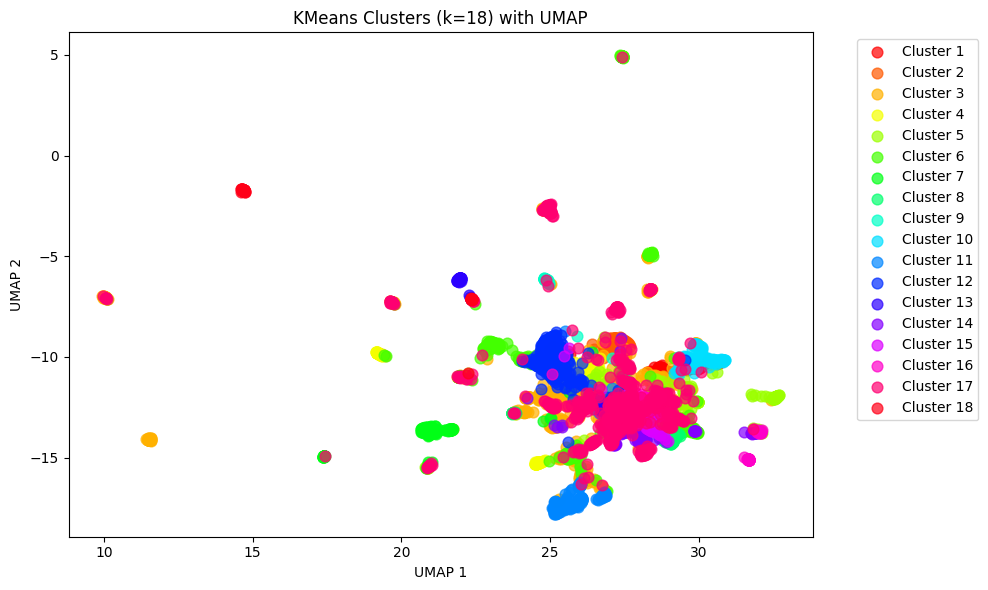

In [254]:
plt.figure(figsize=(10, 6))

cmap = plt.cm.get_cmap('hsv', n_clusters)

for i in range(n_clusters):
    mask = y_kmeans == i

    plt.scatter(
        dfkmean.loc[mask, 'umap1'],
        dfkmean.loc[mask, 'umap2'],
        s=60,
        alpha=0.7,
        color=cmap(i),
        label=f'Cluster {i + 1}'
    )

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f'KMeans Clusters (k={n_clusters}) with UMAP')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## K-Means conclusion

K-Means is a **useful baseline** for this project because it produces a simple, fully-assigned output (every person gets a cluster) and each cluster can be summarized into an interpretable **“needs profile”** via feature lifts and cluster means.

### Why K-Means is acceptable here (as a baseline)
- **Actionable granularity chosen by our framework:** Although internal metrics pointed to extreme solutions (e.g., **k=2** for a coarse split, or **k≈642–671** for over-partitioning), the model-agnostic interpretability scoring selected **k=18** as the best operational balance.
- **Usability signals are strong at k=18:** `min_cluster_size = 78`, low dominance (`max_share ≈ 0.217`), and reasonable balance (`effective_k ≈ 9.54`) indicate clusters are **stable enough and not degenerate** (not “one giant cluster + tiny islands”).
- **Profiles are clearly differentiable in feature space:** `distinctness ≈ 0.97` is very high, meaning clusters tend to have **different top-feature patterns**, which supports human explanation and decision support.

### Limitations (and what the UMAP plot supports)
- **Internal separation is weak under Euclidean geometry:** the selected configuration has low/negative Silhouette (`≈ -0.051`) and high Davies–Bouldin (`≈ 3.64`), suggesting overlap and non-clean boundaries in the scaled feature space.
- **UMAP shows heavy overlap across colors:** many clusters mix in 2D, which is consistent with weak separation. This does not invalidate the solution (UMAP is a projection used only for visualization), but it indicates that the true structure may be **non-convex, density-varying, or continuous**, which K-Means is not designed to model.
- **K-Means shape assumption:** it favors roughly **convex / similar-variance** clusters, so it may miss irregular structures common in “needs” data.

### Bottom line
**K-Means (k=18)** is a **good, interpretable, operational baseline**: it yields usable cluster sizes and highly distinct need profiles, even if clusters are not cleanly separated in distance-based metrics.  
It should be treated as a **reference solution** while we evaluate models better suited to irregular structure (Hierarchical, DBSCAN, HDBSCAN, GMM) using the same shared framework (metrics + constraints + interpretability) for final comparison.

---

---
# **Hierarchical (Agglomerative Clustering)**

**Agglomerative (hierarchical) clustering** builds clusters by repeatedly **merging** the two most similar groups, starting with each person as its own cluster. This creates a **hierarchy** (a tree) of merges. To obtain the final labels, we **cut the hierarchy** at a chosen level to get `n_clusters = K`.

The definition of “most similar” depends on the chosen **parameter**:
- **Ward**: merges that minimize the increase of within-cluster variance (often works well for compact, spherical-ish groups)
- **Complete / Average**: merges based on the farthest / average distance between points across clusters (can produce different shapes)

### **Why hierarchical clustering is useful for our project**
We include it because it often produces **interpretable groupings** and offers an extra “explanation layer” through the hierarchy:

- **Interpretability through structure:** the hierarchy helps us understand how smaller profiles merge into broader profiles.
- **Flexible cluster shapes (depending on parameter):** it is not limited to the same assumptions as K-Means, so it can capture different structure in the needs space.
- **No random initialization:** results are typically more deterministic than K-Means/GMM (given the same metric/parameter), which can help reproducibility.

### **Limitations (important for interpretation)**
- We still need to choose **how many clusters** to extract (or where to cut the tree).
- It can become slow or memory-heavy if the dataset is large (especially without connectivity constraints).
- The choice of **metric + parameter** strongly affects results, so we will compare a small set (e.g., Ward vs Average/Complete) rather than everything.


In [108]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

dfhierarchical = train_df

## **Model-specific algorithm: Dendrogram**

A **dendrogram** is the main interpretation tool for **hierarchical (agglomerative) clustering** because the algorithm produces a full **merge hierarchy** rather than a single “best k”. Starting from individual points, it repeatedly merges the most similar clusters until only one remains.

The dendrogram shows:
- the **merge order** (which groups combine first), and  
- the **linkage distance** at each merge (how dissimilar the merged groups were).

### Why it is useful for choosing the configuration
To obtain final labels we must **cut the tree** at some level. The dendrogram supports this by highlighting:

- **Natural cut points:** big jumps in linkage distance mean the next merge would combine **much more different** groups, so cutting just before that jump often preserves more meaningful clusters.
- **Model-native guidance:** unlike K-Means, hierarchical clustering does not optimize inertia, so the dendrogram (not an inertia elbow) is the correct diagnostic.
- **Project interpretability:** the hierarchy explains how smaller need profiles combine into broader profiles, which helps communicate cluster relationships to staff.


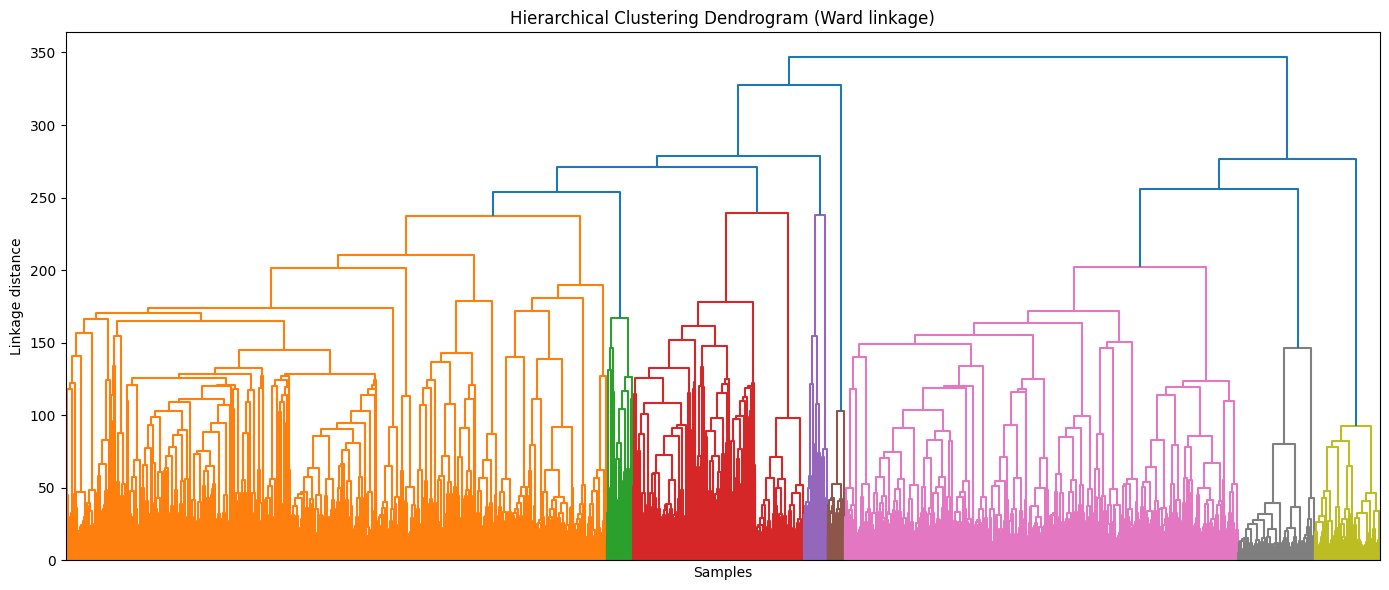

In [110]:
Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    no_labels=True,
    color_threshold=None,
    distance_sort="descending"
)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Samples")
plt.ylabel("Linkage distance")
plt.tight_layout()
plt.show()

Now that we have the dendrogram, we must choose where to **cut** the hierarchy (i.e., select `n_clusters`).

In the next code, we propose candidate `k` values by analyzing the **merge distances** in the linkage matrix `Z`:

- Each merge has a **linkage distance** (dissimilarity of the groups being merged).
- A **large jump** between consecutive merge distances indicates the next merge would combine **much less similar** groups.
- Therefore, a strong cut is often **just before** a large jump, because it keeps major separations intact.

**What the code does:**
1) Reads merge distances from `Z[:, 2]`.  
2) For each `k`, locates the merge step corresponding to “having `k` clusters”.  
3) Computes the **gap** to the next merge distance (`d_next - d_k`).  
4) Treats the largest gaps (or top-N gaps) as **dendrogram-based candidate k values**.  
5) Plots `gap vs k` to visually confirm where the biggest jumps occur.

> These `k` values are **candidates**, not the final choice. We still select the configuration using internal metrics, cluster profile interpretability, and operational usability.


Selected n_clusters by largest dendrogram jump: k=3
Linkage distance at k: 278.7704 -> next: 327.7133 (gap=48.9428)

Top dendrogram-jump candidates:
 k       gap        d_k     d_next
 3 48.942841 278.770420 327.713261
11 27.219422 210.358013 237.577435
 2 18.839387 327.713261 346.552648
 6 15.011413 255.952895 270.964308
 8 13.989026 239.600501 253.589527
14 11.823831 189.837926 201.661756
15  8.684512 181.153414 189.837926
12  7.931913 202.426101 210.358013
 5  5.899655 270.964308 276.863962
27  4.863553 156.384114 161.247667


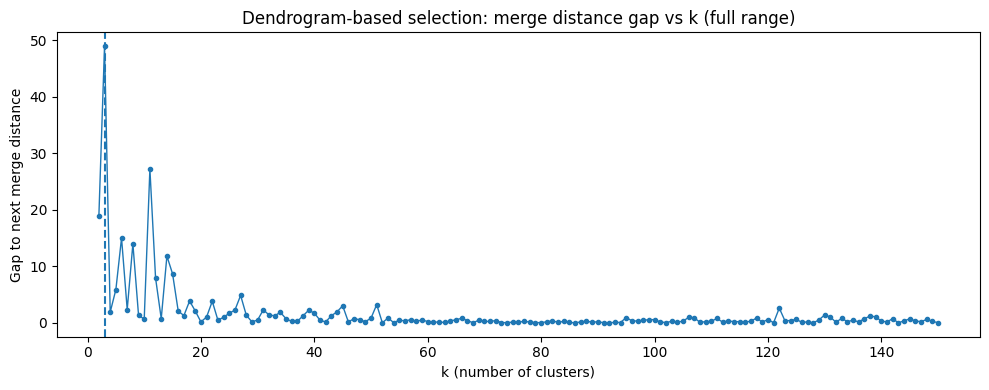


Candidate ks to evaluate: [3, 11, 2, 6, 8, 14, 15, 12, 5, 27]


In [257]:
merge_distances = Z[:, 2]
n = X_scaled.shape[0]

K_MAX = 150

def k_to_merge_index(k: int) -> int:
    """
    Having k clusters means we've performed (n - k) merges.
    merge index = (n - k) - 1 in 0-based indexing.
    """
    return (n - k) - 1

# 1) Compute gaps for ALL possible k (no min/max)
rows = []
for k in range(2, min(n, K_MAX + 1)):  # k in [2, K_MAX]
    idx = k_to_merge_index(k)
    if idx < 0 or idx >= len(merge_distances) - 1:
        continue
    d_k = merge_distances[idx]
    d_next = merge_distances[idx + 1]
    gap = d_next - d_k
    rows.append({"k": k, "gap": gap, "d_k": d_k, "d_next": d_next})

gaps_df = pd.DataFrame(rows).sort_values("gap", ascending=False).reset_index(drop=True)

# 2) Keep only the strongest jumps as dendrogram-based candidates
TOP_N = 10  # candidate budget (adjust)
top_df = gaps_df.head(TOP_N)

best_k = int(top_df.iloc[0]["k"])
best_gap = float(top_df.iloc[0]["gap"])
best_dk = float(top_df.iloc[0]["d_k"])
best_dnext = float(top_df.iloc[0]["d_next"])

print(f"Selected n_clusters by largest dendrogram jump: k={best_k}")
print(f"Linkage distance at k: {best_dk:.4f} -> next: {best_dnext:.4f} (gap={best_gap:.4f})")
print("\nTop dendrogram-jump candidates:")
print(top_df[["k","gap","d_k","d_next"]].to_string(index=False))

# 3) Plot (full curve can be large; still works, but may be dense)
# Plot in k order for readability
plot_df = gaps_df.sort_values("k")
plt.figure(figsize=(10, 4))
plt.plot(plot_df["k"].values, plot_df["gap"].values, marker=".", linewidth=1)
plt.axvline(best_k, linestyle="--")
plt.title("Dendrogram-based selection: merge distance gap vs k (full range)")
plt.xlabel("k (number of clusters)")
plt.ylabel("Gap to next merge distance")
plt.tight_layout()
plt.show()

# Build a compact candidate list for your evaluation step
# (Use these ks as candidate configs to score with your shared framework)
candidate_ks = top_df["k"].astype(int).tolist()
print("\nCandidate ks to evaluate:", candidate_ks)


### Dendrogram interpretation

The dendrogram-based **merge-distance gap** analysis selected **k = 3** as the strongest cut point.  
This means that when the hierarchy has **3 clusters**, the **next merge** would occur at a much higher linkage distance than the previous one (a jump of **~48.9**, from **~278.8 → ~327.7**). In agglomerative clustering, such a large jump suggests the next merge would combine **two relatively dissimilar groups**, so cutting the tree **before** that merge often preserves a more meaningful separation.

The next strongest candidate is **k = 11** (gap **~27.2**, **~210.4 → ~237.6**), which indicates an additional “second-level” structure: a plausible finer partition that may yield more detailed profiles than k=3, while still aligning with a dendrogram-supported separation.

However, this dendrogram jump is a **model-specific candidate generator**, not a final decision. We will evaluate **k = 3** and the strongest nearby dendrogram candidates (**k ∈ {11, 2, 6, 8, 14, 15, 12, 5, 27}**) using the full framework:
- internal evaluation metrics,
- cluster profile interpretability (“top needs” patterns),
- and operational usability (cluster sizes, balance, and clarity for staff).

If **k = 3** is too coarse to produce actionable need profiles, **k = 11** (or another top dendrogram candidate) may become the preferred hierarchical configuration after framework-based validation.


## **Internal Evaluation Metrics**

As stated in the **Modeling Introduction**, we do not have ground-truth labels for clustering.  
Therefore, we evaluate and tune this model using **internal validation metrics** (computed from the data and the clustering result). These metrics help us:

- **select the best model configuration**
- **compare models fairly** against the other clustering models later

### **1) Silhouette Score (higher is better)**

Measures how well each person fits within their assigned cluster compared to the nearest other cluster.  
Higher values indicate **denser** and **better separated** clusters.

In [112]:
from sklearn.metrics import silhouette_score

In [115]:
results = []

sample_size = min(int(n_samples/3), X_scaled.shape[0])

for k in ks:
    model = AgglomerativeClustering(n_clusters=int(k), linkage="ward")
    labels = model.fit_predict(X_scaled)

    score = silhouette_score(X_scaled, labels, sample_size=sample_size, random_state=42)

    results.append((score, int(k)))

results.sort(key=lambda x: x[0], reverse=True)

print("Top k by Silhouette (higher is better) — Agglomerative (ward):")
print("silhouette | k")
for score, k in results[:15]:
    print(f"{score:9.5f} | {k:4d}")

Top k by Silhouette (higher is better) — Agglomerative (ward):
silhouette | k
  0.01878 |    4
 -0.01999 |   30
 -0.02099 |   29
 -0.02431 |   28
 -0.02742 |   27
 -0.02850 |   26
 -0.03222 |   25
 -0.03441 |   24
 -0.03669 |   23
 -0.03785 |   22
 -0.04005 |   21
 -0.04337 |   20
 -0.04729 |   19
 -0.05263 |   18
 -0.05355 |   17


### Silhouette interpretation

Silhouette values for **Ward agglomerative** are **extremely low**, with the best result at **k = 4** (≈ **0.0188**) and most other k values being **negative**.  
In Silhouette terms, values near **0** indicate heavy overlap between clusters, and negative values suggest many points may be closer to another cluster than to their assigned one under the current geometry.

This implies that, in the scaled feature space, Ward’s variance-minimizing merges are not producing strongly separated groups. Therefore, **Silhouette should be treated as a weak signal here** and used only to propose candidates (not to decide the cut by itself).

### **2) Calinski–Harabasz Index (higher is better)**

Measures the ratio of **between-cluster separation** to **within-cluster compactness**.  
Higher values indicate clusters that are **compact and far apart**, and it is fast to compute.

In [116]:
from sklearn.metrics import calinski_harabasz_score

In [117]:
results = []

for k in ks:
    model = AgglomerativeClustering(n_clusters=int(k), linkage="ward")
    labels = model.fit_predict(X_scaled)

    score = calinski_harabasz_score(X_scaled, labels)

    results.append((score, int(k)))

results.sort(key=lambda x: x[0], reverse=True)

print("Top k by Calinski–Harabasz (higher is better) — Agglomerative (ward):")
print("calinski_harabasz | k")
for score, k in results[:15]:
    print(f"{score:16.2f} | {k:4d}")

Top k by Calinski–Harabasz (higher is better) — Agglomerative (ward):
calinski_harabasz | k
          107.42 |    4
          102.01 |    5
           98.43 |    6
           94.82 |    7
           92.26 |    8
           89.48 |    9
           87.38 |   10
           85.79 |   11
           83.16 |   12
           80.69 |   13
           78.62 |   14
           76.46 |   15
           74.33 |   16
           72.43 |   17
           70.74 |   18


### Calinski–Harabasz interpretation

The **Calinski–Harabasz (CH)** score is highest at **k = 4** (≈ **107.4**) and then **decreases steadily** as k increases (5 → 18).  
CH rewards solutions with high between-cluster separation relative to within-cluster dispersion, so this pattern indicates that the strongest Ward-compatible structure is captured by a **small number of broad clusters**, and further splitting yields diminishing separation.

This aligns with the Silhouette result in pointing to **k = 4** as the best internal-metric region for Ward, while acknowledging that this may still be too coarse for actionable profiling.

### **3) Davies–Bouldin Index (lower is better)**

Measures the average similarity between each cluster and its most similar cluster, combining **cluster spread** and **centroid separation**.  
Lower values indicate **better separated** clusters relative to their internal dispersion.

In [118]:
from sklearn.metrics import davies_bouldin_score

In [119]:
results = []

for k in ks:
    model = AgglomerativeClustering(n_clusters=int(k), linkage="ward")
    labels = model.fit_predict(X_scaled)

    score = davies_bouldin_score(X_scaled, labels)

    results.append((score, int(k)))

results.sort(key=lambda x: x[0])

print("Top k by Davies–Bouldin (lower is better) — Agglomerative (ward):")
print("davies_bouldin | k")
for score, k in results[:15]:
    print(f"{score:13.5f} | {k:4d}")

Top k by Davies–Bouldin (lower is better) — Agglomerative (ward):
davies_bouldin | k
      3.60023 |   30
      3.61053 |   28
      3.64996 |   29
      3.67207 |   26
      3.67388 |   27
      3.67691 |   25
      3.68118 |   24
      3.72468 |   21
      3.73675 |   23
      3.77814 |   20
      3.78110 |   19
      3.80348 |   22
      3.80983 |   18
      3.83015 |   17
      3.90641 |   16


### Davies–Bouldin interpretation

The **Davies–Bouldin (DB)** index (lower is better) favors the **largest tested k**, with the best value at **k = 30** (≈ **3.60**) and similar values for **k = 28–29**.  
This suggests that, under a centroid-based compactness vs separation view, increasing k slightly improves the average “cluster similarity” score.

However, selecting **k = 30** purely because it minimizes DB is risky: DB can prefer higher k even when clusters overlap (which is consistent with Silhouette being negative at high k).  
Therefore, we treat DB-minimizing k values as **candidates** for evaluation, not as final choices.


## Interpretability

Internal clustering metrics (Silhouette, Davies–Bouldin and Calinski–Harabasz) and model-specific heuristics (e.g., Elbow for K-Means, k-distance knee for DBSCAN, stability for HDBSCAN, dendrogram cut for Hierarchical, AIC/BIC for GMM) propose **candidate configurations**, but they do not guarantee that the resulting clusters are **usable and explainable** for shelter workers.

To select the **most interpretable** configuration for any clustering model, we evaluate each candidate using **cluster profiles** computed in the original feature space:

For each cluster we compute:
- **Cluster mean** per feature (for binary need features: interpreted as a proportion),
- **Lift vs global mean**: `lift = cluster_mean − global_mean`,
- **Top-N distinguishing features**: features with the largest `|lift|` (these become the “needs summary”).

We then compute an **Interpretability Score** for each candidate configuration:

1) **Profile Strength (clarity of patterns)**  
   For each cluster, take the average `|lift|` over its Top-N features.  
   Combine across clusters using cluster-size weights.  
   → High when clusters have clear, strong deviations from the global profile.

2) **Profile Distinctness (non-redundant summaries)**  
   For each pair of clusters, compute the Jaccard overlap between their Top-N feature sets.  
   Distinctness = `1 − average_overlap`.  
   → High when clusters describe different “needs summaries” rather than repeating the same patterns.

3) **Usability penalties (project constraints)**  
   - **Small-cluster penalty**: downweights solutions with tiny clusters (unstable / not actionable).  
   - **Too-many-clusters penalty**: downweights solutions that produce too many profiles to interpret.  
   - **Noise penalty** (for DBSCAN/HDBSCAN): downweights solutions with excessive noise ratio.

Final score (higher is better):
`Interpretability = Strength × Distinctness × SizePenalty × KPenalty × NoisePenalty`

This approach is model-agnostic: only the **candidate configurations** are model-specific; the interpretability scoring and profile reporting are the same for K-Means, DBSCAN, HDBSCAN, Hierarchical, and GMM.

### Candidates

#### Best candidates
- **Dendrogram (model-specific):** k = **11**
- **Silhouette (highest):** k = **4**
- **Calinski–Harabasz (highest):** k = **4**
- **Davies–Bouldin (lowest):** k = **30**

#### Other suggested candidates
- **Dendrogram (next):** k = **3**, **2**, **6**
- **Silhouette (next):** k = **30**, **29**, **28**
- **Calinski–Harabasz (next):** k = **5**, **6**, **7**
- **Davies–Bouldin (next):** k = **28**, **29**, **26**

In [258]:
from sklearn.cluster import KMeans

candidates = [
    {"name":"Agglomerative (Dendrogram k=11)","estimator":AgglomerativeClustering(n_clusters=11,linkage="ward")},
    {"name":"Agglomerative (Dendrogram k=3)","estimator":AgglomerativeClustering(n_clusters=3,linkage="ward")},
    {"name":"Agglomerative (Dendrogram k=2)","estimator":AgglomerativeClustering(n_clusters=2,linkage="ward")},
    {"name":"Agglomerative (Dendrogram k=6)","estimator":AgglomerativeClustering(n_clusters=6,linkage="ward")},

    {"name":"Agglomerative (Silhouette k=4)","estimator":AgglomerativeClustering(n_clusters=4,linkage="ward")},
    {"name":"Agglomerative (Silhouette k=30)","estimator":AgglomerativeClustering(n_clusters=30,linkage="ward")},
    {"name":"Agglomerative (Silhouette k=29)","estimator":AgglomerativeClustering(n_clusters=29,linkage="ward")},
    {"name":"Agglomerative (Silhouette k=28)","estimator":AgglomerativeClustering(n_clusters=28,linkage="ward")},

    {"name":"Agglomerative (CH k=4)","estimator":AgglomerativeClustering(n_clusters=4,linkage="ward")},
    {"name":"Agglomerative (CH k=5)","estimator":AgglomerativeClustering(n_clusters=5,linkage="ward")},
    {"name":"Agglomerative (CH k=6)","estimator":AgglomerativeClustering(n_clusters=6,linkage="ward")},
    {"name":"Agglomerative (CH k=7)","estimator":AgglomerativeClustering(n_clusters=7,linkage="ward")},

    {"name":"Agglomerative (DB k=30)","estimator":AgglomerativeClustering(n_clusters=30,linkage="ward")},
    {"name":"Agglomerative (DB k=28)","estimator":AgglomerativeClustering(n_clusters=28,linkage="ward")},
    {"name":"Agglomerative (DB k=29)","estimator":AgglomerativeClustering(n_clusters=29,linkage="ward")},
    {"name":"Agglomerative (DB k=26)","estimator":AgglomerativeClustering(n_clusters=26,linkage="ward")},
]

df_features_clean = dfkmean.drop(columns=["umap1", "umap2", "cluster"], errors="ignore").copy()

ranked, best_name, best_labels, best_profiles = evaluate_candidates(
    candidates=candidates,
    X_fit=X_scaled,
    df_features=df_features_clean,
    silhouette_sample=min(2000, X_scaled.shape[0])
)

print(ranked[[
    "candidate","interpretability","silhouette","calinski_harabasz","davies_bouldin",
    "k","effective_k","noise_ratio","max_share",
    "min_cluster_size","size_penalty","micro_penalty",
    "k_penalty","noise_penalty","dominance_penalty","balance_penalty",
    "strength","distinctness"
]].to_string(index=False, float_format=lambda x: f"{x:0.6f}"))

print("\nBEST:", best_name)
print("\nBest cluster profiles (sorted by size):")
print(best_profiles[["cluster","n","%","top_features","top_lifts"]].to_string(index=False, float_format=lambda x: f"{x:0.6f}"))

best_estimator = next(c["estimator"] for c in candidates if c["name"] == best_name)

                      candidate  interpretability  silhouette  calinski_harabasz  davies_bouldin  k  effective_k  noise_ratio  max_share  min_cluster_size  size_penalty  micro_penalty  k_penalty  noise_penalty  dominance_penalty  balance_penalty  strength  distinctness
Agglomerative (Silhouette k=30)          0.408604   -0.018536          58.063049        3.600232 30    13.300582     0.000000   0.191157                23      1.000000       1.000000   1.000000       1.000000           1.000000         1.000000  0.420096      0.972644
        Agglomerative (DB k=30)          0.408604   -0.018536          58.063049        3.600232 30    13.300582     0.000000   0.191157                23      1.000000       1.000000   1.000000       1.000000           1.000000         1.000000  0.420096      0.972644
        Agglomerative (DB k=29)          0.407058   -0.019642          58.805105        3.649962 29    13.291030     0.000000   0.191157                35      1.000000       1.000000   1.00

## Final configuration

**BEST CONFIGURATION: `Agglomerative (Ward) (k = 30)` — selected as `Agglomerative (Silhouette k=30)` / `Agglomerative (DB k=30)`**

This candidate wins because it achieves the highest **model-agnostic interpretability score** among the tested Ward cuts, while staying operationally usable:

- **Actionable granularity:** `k = 30` yields a richer set of profiles than small-k cuts (e.g., k=4, k=11), which helps differentiate more “need patterns” without exploding into micro-clusters.
- **Usable cluster sizes:** `min_cluster_size = 23` remains above the minimum target (`min_size_target = 20`), so the solution avoids tiny clusters and **does not trigger size/micro penalties** (`size_penalty = 1.0`, `micro_penalty = 1.0`).
- **Balanced output (no dominant cluster):** `max_share ≈ 0.191` and `effective_k ≈ 13.30` indicate a reasonably distributed partition (not “one giant cluster + small islands”).
- **Strong profile separation in features:** `distinctness ≈ 0.973` is very high, meaning clusters tend to have different “top-feature” sets, supporting human-readable “needs profiles”.
- **Penalties are not triggered:** `k_penalty = 1.0`, `dominance_penalty = 1.0`, `noise_penalty = 1.0`, `balance_penalty = 1.0` → the score reflects real usability + interpretability under our framework.

### Important (what internal metrics say)
Even though the interpretability framework selects `k = 30`, the distance-based internal metrics suggest **weak geometric separation** under Ward:

- **Silhouette is slightly negative** (`≈ -0.0185`), indicating overlap between clusters in the scaled Euclidean space.
- **Davies–Bouldin is best at k=30** in the tested range (`≈ 3.60`), but the improvement over nearby k is small.
- **Calinski–Harabasz is much higher at small k** (e.g., `≈ 107` at `k=4`), which suggests the strongest separations exist at a coarser level, while finer splits add less “distance-based” separation.

So this is a deliberate trade-off: `k = 30` is chosen for **actionable, diverse profiles**, not because it produces cleanly separated clusters by geometry.

### Why other candidates lose
- **`k = 29` / `k = 28` (DB/Silhouette candidates):** very close to the winner, but slightly lower interpretability score (`≈ 0.407` / `≈ 0.404`). These remain strong backups if k=30 produces any problematic profiles.
- **`Agglomerative (Dendrogram k=11)`:** produces a more mid-level cut, but it is penalized by low balance (`balance_penalty ≈ 0.453`) due to `effective_k ≈ 4.53`, meaning the cluster size distribution is effectively much less diverse than k=30. Its strength is also lower (`≈ 0.308`), so profiles are less informative overall.
- **Small-k cuts (k = 7, 6, 5, 4, 3, 2):** despite better CH and non-negative Silhouette around k=3–4, they are heavily penalized for being too coarse (`k_penalty` collapses below 10) and they show reduced profile richness (e.g., much lower strength and/or distinctness; `distinctness` even drops to 0 at k=2).

### Practical takeaway for the project
`k = 30` is a strong Ward-hierarchical candidate when our priority is **many distinct, still-usable need profiles** (good sizes, good balance, high distinctness).  
However, since separation metrics are weak/negative, we should treat Ward as potentially **overlapping in geometry** and rely on:
- sanity-checking the cluster profiles (do they correspond to meaningful need categories?),
- comparing with other models (HDBSCAN/DBSCAN/GMM) that may capture non-convex or density-varying structure better,
- and using k=28–29 as close fallbacks if k=30 proves operationally noisy in interpretation.


# Model Plotting

Now that we have selected the Hierarchical configuration that best matches our **evaluation metrics** and **practical constraints** (interpretability, cluster sizes, and usability), we train the final model and visualize the resulting clusters.

Because our dataset is high-dimensional, the plot will use a **2D embedding (UMAP)** for *visualization only*. The clustering itself is computed in the original feature space. The goal of the plot is to:

- provide an intuitive view of how clusters relate to each other,
- check for obvious overlaps or artifacts,
- and support the qualitative interpretation of cluster profiles.

> Note: the 2D visualization does not fully represent the true distances in the original space, so it is used as an explanatory tool rather than a strict evaluation criterion.

In [259]:
agglomerativeclustering = best_estimator
n_clusters = best_estimator.n_clusters
print(best_estimator)
print(n_clusters)

agglomerative_labels = agglomerativeclustering.fit_predict(X_scaled)

AgglomerativeClustering(n_clusters=30)
30


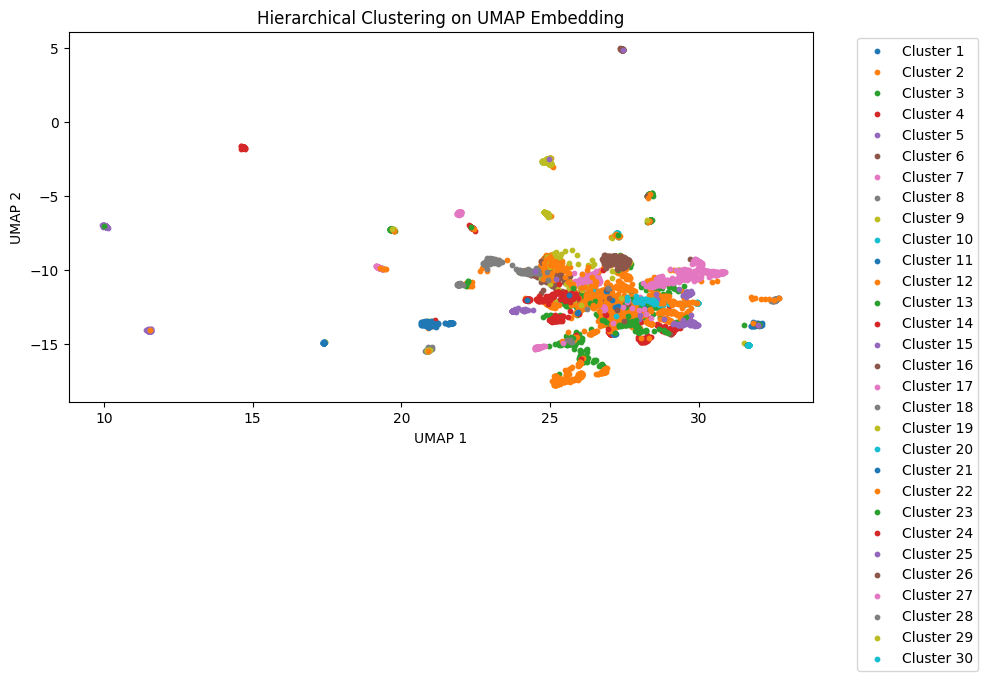

In [260]:
plt.figure(figsize=(10, 6))

cmap = plt.cm.get_cmap('tab20', n_clusters)

for i in range(n_clusters):
    mask = agglomerative_labels == i
    plt.scatter(
        train_df.loc[mask, 'umap1'],
        train_df.loc[mask, 'umap2'],
        s=10,
        label=f'Cluster {i + 1}'
    )

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title("Hierarchical Clustering on UMAP Embedding")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Agglomerative (Hierarchical) conclusion

Agglomerative (hierarchical) clustering is a **useful alternative baseline** for our project because it produces fully-assigned clusters and adds a **hierarchical explanation layer** (the dendrogram), which helps describe how smaller need profiles merge into broader groups.

### Why Agglomerative is useful here
- **Hierarchy adds context:** the dendrogram provides an intuitive view of how profiles relate (which profiles are “closer” and merge earlier), supporting communication with non-technical stakeholders.
- **Actionable granularity selected by our framework:** the interpretability ranking selected **Ward, k = 30** as the best trade-off among tested cuts, producing many profiles without creating micro-clusters (`min_cluster_size = 23`, above the 20 target).
- **Balanced and non-dominant solution:** `max_share ≈ 0.191` and `effective_k ≈ 13.3` indicate a reasonably distributed partition (not collapsing into one large default group).
- **Highly differentiated profiles:** `distinctness ≈ 0.973` is very high, meaning clusters tend to surface different top-need patterns rather than repeating the same features.

### Limitations (what the metrics + visualization imply)
- **Weak separation in distance-based metrics:** Ward’s Silhouette values are very low or negative overall, and the selected `k=30` solution still has **slightly negative Silhouette** (`≈ -0.0185`), indicating overlap in the scaled Euclidean space.
- **Dendrogram “largest jump” vs actionable cut:** the strongest dendrogram jump can occur at very small k (e.g., 2–3), capturing a real coarse split, but our final choice is driven by operationally meaningful profile granularity rather than the single largest jump.
- **UMAP overlap is expected:** the plot shows substantial color mixing, which is consistent with the Silhouette signal. This does not invalidate the clustering (UMAP is only a 2D projection), but it suggests the underlying structure may be weakly separated or non-convex for Ward.

### Bottom line
Agglomerative (Ward) with **k = 30** produces **many distinct, usable need profiles** (good minimum size, good balance, high distinctness), making it a strong baseline for shelter-oriented profiling.  
However, the consistently weak separation metrics suggest the data may not fit Ward’s geometry perfectly, so we should treat this as a **profile-generation baseline** and compare it against models better suited for irregular structure.

**Next step:** we will evaluate **DBSCAN, HDBSCAN, and GMM** with the same framework (internal metrics + usability constraints + interpretability) and perform a final cross-model comparison to select the method that best supports actionable shelter decisions.

---

---
# **DBSCAN**

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) groups points by identifying **dense regions** in the feature space. It defines clusters as areas where a point has at least `min_samples` neighbors within a radius `eps`. It naturally classifies points into:
- **Core points** (inside dense regions),
- **Border points** (near dense regions),
- **Noise** (outliers, labeled as `-1`).

DBSCAN does **not** require selecting the number of clusters in advance.

### **Why DBSCAN is useful for our project**
DBSCAN can be valuable when we expect:
- **Outliers / unusual cases:** people whose needs don’t match any common profile can be flagged as **noise**, which can be informative for workers.
- **Non-spherical groups:** it can discover clusters with shapes that K-Means/GMM may struggle with.

### **Limitations (important for interpretation)**
- It is sensitive to `eps`: small changes can drastically change the number of clusters and the noise ratio.
- It struggles when clusters have **different densities** (one dense group + one sparse group), which is common in real-world data.
- In high-dimensional feature spaces, distance neighborhoods become less informative; DBSCAN may label too many points as noise unless carefully tuned.

In [138]:
from sklearn.cluster import DBSCAN

dfdbscan = train_df

## **Model-specific algorithm: k-distance distribution (DBSCAN)**

A **k-distance distribution** is the most common practical tool to tune **DBSCAN**, because DBSCAN does not require choosing the number of clusters directly. Instead, it depends mainly on:

- `eps`: neighborhood radius
- `min_samples`: minimum neighbors for a point to be considered “dense” (core point)

The k-distance distribution is mainly used to propose a sensible **`eps` scale**.

### What is a k-distance distribution?
For each point, we compute the distance to its **k-th nearest neighbor**, typically using:

- `k = min_samples`

Then we sort these distances and plot them. The curve usually shows two regimes:

- **Flat/slow growth:** points in dense regions (candidate clusters)
- **Sharp rise:** points in sparse regions (outliers / noise)

The point where the curve starts rising sharply is the **knee**, which is a common heuristic for an `eps` **starting point**.

### Why it is useful (and what it does *not* do)
- **Data-driven eps proposal:** DBSCAN is very sensitive to `eps`; the k-distance curve gives an empirical way to set a reasonable eps scale.
- **Guides the trade-off:** too small `eps` → many noise points; too large `eps` → clusters merge. The knee often sits near a good balance point.

However:
- **It does not select the “best” DBSCAN configuration by itself.** It only suggests a good eps region.
- **`min_samples` still matters.** Different `min_samples` values can lead to different clusterings even if the curves look similar, so `min_samples` should be tested over a small set.

### How we use it in this project
We use k-distance distribution to **restrict the eps search space** (knee + nearby values and/or quantiles), and then we choose the final DBSCAN configuration using our full framework:
**internal metrics + practical constraints + interpretability**.


eps candidates (quantiles of k-distance):
min_samples=2
  q=  0.9: eps ≈ 23.663
  q= 0.95: eps ≈ 27.982
  q= 0.97: eps ≈ 30.960
  q= 0.99: eps ≈ 39.310
min_samples=3
  q=  0.9: eps ≈ 25.188
  q= 0.95: eps ≈ 29.830
  q= 0.97: eps ≈ 33.146
  q= 0.99: eps ≈ 41.783
min_samples=4
  q=  0.9: eps ≈ 25.836
  q= 0.95: eps ≈ 30.957
  q= 0.97: eps ≈ 34.432
  q= 0.99: eps ≈ 43.577
min_samples=6
  q=  0.9: eps ≈ 27.133
  q= 0.95: eps ≈ 32.113
  q= 0.97: eps ≈ 36.411
  q= 0.99: eps ≈ 45.944
min_samples=8
  q=  0.9: eps ≈ 28.154
  q= 0.95: eps ≈ 33.473
  q= 0.97: eps ≈ 37.496
  q= 0.99: eps ≈ 46.844
min_samples=10
  q=  0.9: eps ≈ 28.655
  q= 0.95: eps ≈ 34.303
  q= 0.97: eps ≈ 38.252
  q= 0.99: eps ≈ 47.569
min_samples=15
  q=  0.9: eps ≈ 29.219
  q= 0.95: eps ≈ 35.008
  q= 0.97: eps ≈ 38.972
  q= 0.99: eps ≈ 48.457
min_samples=20
  q=  0.9: eps ≈ 29.953
  q= 0.95: eps ≈ 35.475
  q= 0.97: eps ≈ 39.440
  q= 0.99: eps ≈ 48.840


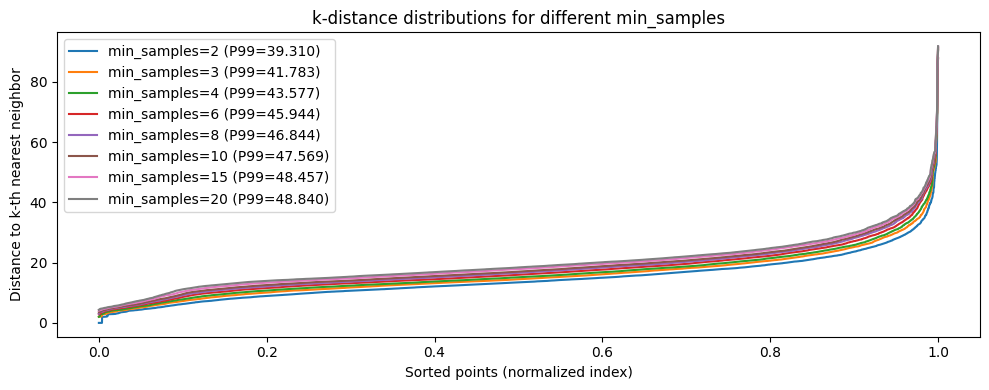

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

min_samples_list = [2, 3, 4, 6, 8, 10, 15, 20]
q = 0.99

plt.figure(figsize=(10,4))
qs = [0.90, 0.95, 0.97, 0.99]
print("eps candidates (quantiles of k-distance):")
for ms in min_samples_list:
    nn = NearestNeighbors(n_neighbors=ms).fit(X_scaled)
    distances, _ = nn.kneighbors(X_scaled)
    kdist = np.sort(distances[:, -1])

    x = np.linspace(0, 1, len(kdist))
    plt.plot(x, kdist, label=f"min_samples={ms} (P{int(q*100)}={np.quantile(kdist,q):.3f})")
    print(f"min_samples={ms}")
    for q in qs:
        print(f"  q={q:>5}: eps ≈ {np.quantile(kdist, q):.3f}")

plt.title("k-distance distributions for different min_samples")
plt.xlabel("Sorted points (normalized index)")
plt.ylabel("Distance to k-th nearest neighbor")
plt.legend()
plt.tight_layout()
plt.show()

## Quantile-based eps interpretation + how we handle `min_samples`

Across `min_samples = 2 → 20`, the k-distance curves have **very similar shapes** (same “flat body” + steep tail).  
This tells us that the **neighborhood scale of the dataset is stable**, and that `eps` will not jump wildly just because we change `min_samples`.

However, **similar curves do NOT mean similar DBSCAN outputs**:
- `min_samples` changes the **density requirement** to form a core point.
- So even if the recommended `eps` range stays close, the clustering can shift from “few big clusters” to “many small clusters + noise”.

### Practical decision for this project
Instead of fixing a single value prematurely, we treat **`min_samples` as a hyperparameter** and test a small, realistic set (e.g., **6, 8, 10, 15**) using the same framework (metrics + constraints + interpretability).  
We still keep **`min_samples = 10` as the baseline starting point** because it is a common middle-ground: not as permissive as 2–4, not as strict as 15–20.

### Quantile-based eps (fast candidate grid)
Quantiles turn the k-distance distribution into **multiple sensible eps candidates**:

- **Lower quantiles (q ≈ 0.90)** → stricter eps (≈ 23–30 depending on `min_samples`)  
  → tighter clusters, usually **more noise**.

- **Higher quantiles (q ≈ 0.99)** → looser eps (≈ 39–49 depending on `min_samples`)  
  → fewer/larger clusters, usually **less noise** but higher risk of **merging profiles**.

**How we’ll use this**
We’ll start by testing eps in the **q=0.90–0.97 region** (good balance zone), and only move toward **q≥0.99** if noise is too high or clusters fragment too much.

DBSCAN eps candidates from k-distance knee (max-distance-to-chord):
min_samples | eps_knee | knee_index
          2 |  25.5472 |      6224
          3 |  26.6101 |      6188
          4 |  26.7475 |      6130
          6 |  27.7026 |      6104
          8 |  29.3310 |      6144
         10 |  28.9138 |      6074
         15 |  30.1577 |      6121
         20 |  30.4374 |      6095


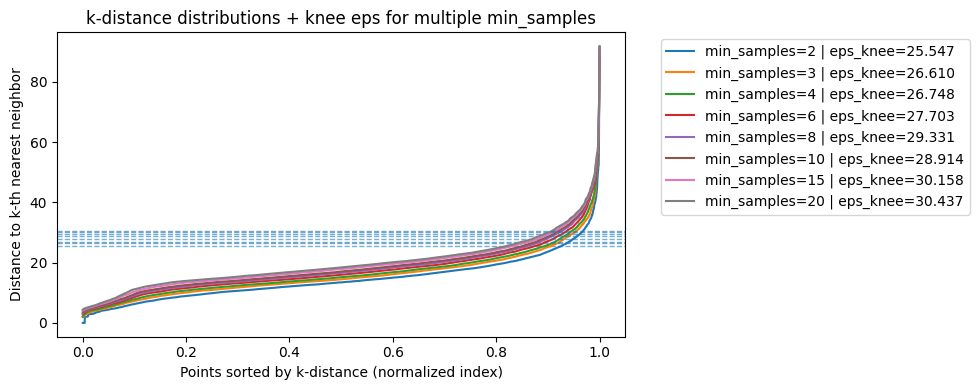

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

min_samples_list = [2, 3, 4, 6, 8, 10, 15, 20]

def knee_max_distance(x, y):
    x = x.astype(float)
    y = y.astype(float)

    xn = (x - x.min()) / (x.max() - x.min() + 1e-12)
    yn = (y - y.min()) / (y.max() - y.min() + 1e-12)

    p = np.column_stack([xn, yn])
    p1, p2 = p[0], p[-1]
    line = p2 - p1
    line_norm = np.linalg.norm(line) + 1e-12
    line_unit = line / line_norm

    v = p - p1
    proj = (v @ line_unit)[:, None] * line_unit[None, :]
    perp = v - proj
    dist = np.linalg.norm(perp, axis=1)

    idx = int(np.argmax(dist))
    return idx, dist

knee_table = []

plt.figure(figsize=(10, 4))

for ms in min_samples_list:
    nn = NearestNeighbors(n_neighbors=ms).fit(X_scaled)
    distances, _ = nn.kneighbors(X_scaled)

    k_dist = np.sort(distances[:, -1])
    x = np.arange(len(k_dist))
    y = k_dist

    knee_idx, _ = knee_max_distance(x, y)
    eps_knee = float(y[knee_idx])

    knee_table.append((ms, eps_knee, knee_idx))

    # Plot curve (normalize x so curves are comparable)
    x_norm = np.linspace(0, 1, len(y))
    plt.plot(x_norm, y, label=f"min_samples={ms} | eps_knee={eps_knee:.3f}")

    # Horizontal line showing eps_knee
    plt.axhline(eps_knee, linestyle="--", linewidth=1, alpha=0.6)

print("DBSCAN eps candidates from k-distance knee (max-distance-to-chord):")
print("min_samples | eps_knee | knee_index")
for ms, eps, idx in knee_table:
    print(f"{ms:11d} | {eps:8.4f} | {idx:9d}")

plt.title("k-distance distributions + knee eps for multiple min_samples")
plt.xlabel("Points sorted by k-distance (normalized index)")
plt.ylabel("Distance to k-th nearest neighbor")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Knee-based eps interpretation (k-distance plot) and conclusion

The k-distance curve shows a long gradual increase followed by a clear **sharp rise** near the end.  
The “knee” is the transition where we stop describing dense neighborhoods (potential clusters) and start entering the sparse tail (likely outliers/noise).

### What the multi-`min_samples` knee results tell us
Your knee eps estimates stay in a **tight band**:

- `eps_knee ≈ 25.5 → 30.4` for `min_samples = 2 → 20`

That’s a strong sign that the dataset has a **consistent density break**, and the knee heuristic is giving a stable “first guess” for eps.

### Conclusion (what eps to try first)
Rather than trusting one exact knee value, we use it as a **starting center**:

- A sensible starting region is **eps ≈ 26–30**
- For the baseline **`min_samples = 10`**, the knee suggests **`eps ≈ 28.9`**

So, we will start around **eps ≈ 28–29**, and test nearby values (e.g., ±2–4) while also comparing a few `min_samples` choices (like 6/8/10/15).

Final selection still follows the full project rule: **metrics + practical constraints + interpretability**, because a “good knee” can still produce unusable outputs (too few clusters, too many tiny clusters, or unclear profiles).

## **Internal Evaluation Metrics**

As stated in the **Modeling Introduction**, we do not have ground-truth labels for clustering.  
Therefore, we evaluate and tune this model using **internal validation metrics** (computed from the data and the clustering result). These metrics help us:

- **select the best model configuration**
- **compare models fairly** against the other clustering models later

### **1) Silhouette Score (higher is better)**

Measures how well each person fits within their assigned cluster compared to the nearest other cluster.  
Higher values indicate **denser** and **better separated** clusters.

In [136]:
from sklearn.metrics import silhouette_score

In [173]:
results = []

min_samples_list = [2, 3, 4, 6, 8, 10, 15, 20]
# q=0.90 ~ 28.7, q=0.95 ~ 34.3, q=0.97 ~ 38.3, q=0.99 ~ 47.6
eps_values = np.arange(25.0, 40.0, 1.0)   # main search range for our project

n_samples = X_scaled.shape[0]
sample_size = min(int(n_samples/3), n_samples)

for ms in min_samples_list:
    for eps in eps_values:
        labels = DBSCAN(eps=float(eps), min_samples=int(ms)).fit_predict(X_scaled)

        mask = labels != -1
        if mask.sum() < 2:
            continue
        if len(np.unique(labels[mask])) < 2:
            continue

        score = silhouette_score(
            X_scaled[mask], labels[mask],
            sample_size=min(sample_size, mask.sum()),
            random_state=42
        )

        noise_ratio = 1.0 - mask.mean()
        n_clusters = len(np.unique(labels[mask]))

        results.append((score, float(eps), int(ms), int(n_clusters), float(noise_ratio)))

results.sort(key=lambda x: x[0], reverse=True)

print("Top DBSCAN configs by Silhouette (higher is better):")
print("silhouette | eps  | min_samples | n_clusters | noise_ratio")
if not results:
    print("No valid configs (>=2 clusters after removing noise).")
else:
    for score, eps, ms, ncl, nr in results[:20]:
        print(f"{score:9.5f} | {eps:4.1f} | {ms:11d} | {ncl:10d} | {nr:10.3f}")


Top DBSCAN configs by Silhouette (higher is better):
silhouette | eps  | min_samples | n_clusters | noise_ratio
  0.40120 | 39.0 |           4 |          6 |      0.013
  0.40077 | 38.0 |           4 |          6 |      0.014
  0.40049 | 35.0 |           4 |          6 |      0.022
  0.40045 | 37.0 |           3 |          9 |      0.014
  0.38797 | 36.0 |           4 |          7 |      0.019
  0.38070 | 38.0 |           2 |         14 |      0.011
  0.37664 | 38.0 |           3 |          9 |      0.013
  0.37623 | 39.0 |           3 |          9 |      0.012
  0.37036 | 37.0 |           2 |         14 |      0.013
  0.36235 | 37.0 |           4 |          7 |      0.016
  0.35443 | 39.0 |           2 |         13 |      0.011
  0.35316 | 36.0 |           2 |         19 |      0.014
  0.35296 | 35.0 |           2 |         22 |      0.016
  0.35163 | 28.0 |          15 |          2 |      0.082
  0.35113 | 36.0 |           3 |         12 |      0.016
  0.34933 | 25.0 |          10 | 

### Silhouette interpretation (DBSCAN)

**Top by Silhouette:** `eps = 39`, `min_samples = 4` → **Silhouette ≈ 0.401**, `n_clusters = 6`, `noise_ratio ≈ 1.3%`

What this suggests:
- A Silhouette around **0.40** is **strong** in our context (much higher than the K-Means / Ward results), indicating DBSCAN is finding clusters that are comparatively **well separated** among **non-noise points**.
- The **noise ratio is very low** (~1–2%), so the score is not achieved by discarding many difficult samples.
- The top rows are **locally stable**: nearby `eps = 38–39` with `min_samples = 4` repeatedly returns **k = 6** with almost the same Silhouette and noise, which is a good sign.

What to keep (without discarding alternatives):
- `min_samples = 3` yields **k ≈ 9–12** with slightly lower Silhouette → potentially more granular but still reasonable.
- `min_samples = 2` yields **k ≈ 13–22** with low noise → more detailed profiles, but likely less stable.

**Candidate takeaway:** keep `eps ≈ 38–39, min_samples = 4` as the main Silhouette-driven candidate regime, and include nearby `min_samples = 3` and `2` configurations for comparison.


### **2) Calinski–Harabasz Index (higher is better)**

Measures the ratio of **between-cluster separation** to **within-cluster compactness**.  
Higher values indicate clusters that are **compact and far apart**, and it is fast to compute.

In [ ]:
from sklearn.metrics import calinski_harabasz_score

In [174]:
results = []

min_samples_list = [2, 3, 4, 6, 8, 10, 15, 20]
# q=0.90 ~ 28.7, q=0.95 ~ 34.3, q=0.97 ~ 38.3, q=0.99 ~ 47.6
eps_values = np.arange(25.0, 40.0, 1.0)   # main search range for our project

for ms in min_samples_list:
    for eps in eps_values:
        labels = DBSCAN(eps=float(eps), min_samples=int(ms)).fit_predict(X_scaled)

        mask = labels != -1
        if mask.sum() < 2:
            continue
        if len(np.unique(labels[mask])) < 2:
            continue

        score = calinski_harabasz_score(X_scaled[mask], labels[mask])

        noise_ratio = 1.0 - mask.mean()
        n_clusters = len(np.unique(labels[mask]))

        results.append((score, float(eps), int(ms), int(n_clusters), float(noise_ratio)))

results.sort(key=lambda x: x[0], reverse=True)

print("Top DBSCAN configs by Calinski–Harabasz (higher is better):")
print("calinski_harabasz | eps  | min_samples | n_clusters | noise_ratio")
if not results:
    print("No valid configs (>=2 clusters after removing noise).")
else:
    for score, eps, ms, ncl, nr in results[:20]:
        print(f"{score:16.2f} | {eps:4.1f} | {ms:11d} | {ncl:10d} | {nr:10.3f}")



Top DBSCAN configs by Calinski–Harabasz (higher is better):
calinski_harabasz | eps  | min_samples | n_clusters | noise_ratio
           81.46 | 28.0 |          15 |          2 |      0.082
           81.23 | 27.0 |          10 |          2 |      0.092
           78.50 | 28.0 |          20 |          2 |      0.083
           78.12 | 27.0 |          15 |          2 |      0.093
           59.27 | 26.0 |          10 |          3 |      0.101
           59.17 | 25.0 |          10 |          3 |      0.115
           57.85 | 26.0 |          15 |          3 |      0.103
           45.04 | 25.0 |           8 |          4 |      0.112
           41.85 | 25.0 |          15 |          2 |      0.123
           34.16 | 26.0 |           8 |          6 |      0.097
           33.71 | 27.0 |           8 |          5 |      0.085
           27.63 | 26.0 |           6 |         12 |      0.086
           26.59 | 25.0 |           6 |         12 |      0.101
           24.99 | 27.0 |           6 |   

### Calinski–Harabasz interpretation (DBSCAN)

**Top by CH:** `eps = 28`, `min_samples = 15` → **CH ≈ 81.46**, `n_clusters = 2`, `noise_ratio ≈ 8.2%`

What this suggests:
- CH strongly rewards solutions where clusters are **compact** and **well separated** in a variance-ratio sense. For DBSCAN, it often peaks when the clustering becomes **coarse** (here `k = 2`), because between-cluster separation dominates.
- Noise remains **moderate** (~8–9%), so this is not a “throw-away-as-noise” solution.

Why we keep it:
- `k = 2` is likely too coarse for final shelter profiling, but it is still valuable as a **baseline structure** candidate (the strongest global split DBSCAN can express under a stricter density regime).
- The top CH configs are all the same pattern (`eps ≈ 27–28`, higher `min_samples`, `k = 2`), so we treat them as one coherent **coarse-regime** candidate family.

**Candidate takeaway:** keep `eps ≈ 27–28, min_samples ≈ 15` as the CH-driven coarse candidate, to be evaluated alongside more granular solutions.


### **3) Davies–Bouldin Index (lower is better)**

Measures the average similarity between each cluster and its most similar cluster, combining **cluster spread** and **centroid separation**.  
Lower values indicate **better separated** clusters relative to their internal dispersion.

In [ ]:
from sklearn.metrics import davies_bouldin_score

In [175]:
results = []

min_samples_list = [2, 3, 4, 6, 8, 10, 15, 20]
# q=0.90 ~ 28.7, q=0.95 ~ 34.3, q=0.97 ~ 38.3, q=0.99 ~ 47.6
eps_values = np.arange(25.0, 40.0, 1.0)   # main search range for our project

for ms in min_samples_list:
    for eps in eps_values:
        labels = DBSCAN(eps=float(eps), min_samples=int(ms)).fit_predict(X_scaled)

        mask = labels != -1
        if mask.sum() < 2:
            continue
        if len(np.unique(labels[mask])) < 2:
            continue

        score = davies_bouldin_score(X_scaled[mask], labels[mask])

        noise_ratio = 1.0 - mask.mean()
        n_clusters = len(np.unique(labels[mask]))

        results.append((score, float(eps), int(ms), int(n_clusters), float(noise_ratio)))

results.sort(key=lambda x: x[0])  # lower is better

print("Top DBSCAN configs by Davies–Bouldin (lower is better):")
print("davies_bouldin | eps  | min_samples | n_clusters | noise_ratio")
if not results:
    print("No valid configs (>=2 clusters after removing noise).")
else:
    for score, eps, ms, ncl, nr in results[:20]:
        print(f"{score:13.5f} | {eps:4.1f} | {ms:11d} | {ncl:10d} | {nr:10.3f}")


Top DBSCAN configs by Davies–Bouldin (lower is better):
davies_bouldin | eps  | min_samples | n_clusters | noise_ratio
      0.80708 | 37.0 |           2 |         14 |      0.013
      0.80781 | 38.0 |           2 |         14 |      0.011
      0.83765 | 39.0 |           2 |         13 |      0.011
      0.84488 | 36.0 |           2 |         19 |      0.014
      0.84904 | 35.0 |           2 |         22 |      0.016
      0.87323 | 33.0 |           2 |         28 |      0.021
      0.87865 | 31.0 |           8 |          2 |      0.048
      0.87991 | 34.0 |           2 |         25 |      0.019
      0.89906 | 32.0 |           2 |         31 |      0.026
      0.90680 | 37.0 |           3 |          9 |      0.014
      0.90758 | 38.0 |           3 |          9 |      0.013
      0.90821 | 39.0 |           3 |          9 |      0.012
      0.90940 | 30.0 |           2 |         40 |      0.035
      0.92608 | 29.0 |           2 |         43 |      0.042
      0.93205 | 35.0 |     

### Davies–Bouldin interpretation (DBSCAN)

**Top by DB:** `eps = 37`, `min_samples = 2` → **DB ≈ 0.807**, `n_clusters = 14`, `noise_ratio ≈ 1.3%`

What this suggests:
- DB (lower is better) favors solutions that produce **many compact clusters** with good separation of their centers. Here, DBSCAN forms **~14 clusters** while keeping noise extremely low.
- The top DB list is dominated by `min_samples = 2` with `eps ≈ 35–39`, producing **13–22 clusters** — a high-granularity, low-noise regime.

Why we keep it:
- `min_samples = 2` is very permissive and can be **sensitive** to small density fluctuations, so we should not assume it is stable without checking cluster sizes and profile meaning.
- The list also shows slightly stricter nearby options: `min_samples = 3` at `eps ≈ 37–39` yields **k ≈ 9** with DB ≈ 0.907, which may be more stable while remaining in the same low-noise regime.

**Candidate takeaway:** keep `eps ≈ 37–38, min_samples = 2` as the DB-driven high-granularity candidate regime, and include `min_samples = 3` variants as stability-aware alternatives.


## Interpretability

Internal clustering metrics (Silhouette, Davies–Bouldin and Calinski–Harabasz) and model-specific heuristics (e.g., Elbow for K-Means, k-distance knee for DBSCAN, stability for HDBSCAN, dendrogram cut for Hierarchical, AIC/BIC for GMM) propose **candidate configurations**, but they do not guarantee that the resulting clusters are **usable and explainable** for shelter workers.

To select the **most interpretable** configuration for any clustering model, we evaluate each candidate using **cluster profiles** computed in the original feature space:

For each cluster we compute:
- **Cluster mean** per feature (for binary need features: interpreted as a proportion),
- **Lift vs global mean**: `lift = cluster_mean − global_mean`,
- **Top-N distinguishing features**: features with the largest `|lift|` (these become the “needs summary”).

We then compute an **Interpretability Score** for each candidate configuration:

1) **Profile Strength (clarity of patterns)**  
   For each cluster, take the average `|lift|` over its Top-N features.  
   Combine across clusters using cluster-size weights.  
   → High when clusters have clear, strong deviations from the global profile.

2) **Profile Distinctness (non-redundant summaries)**  
   For each pair of clusters, compute the Jaccard overlap between their Top-N feature sets.  
   Distinctness = `1 − average_overlap`.  
   → High when clusters describe different “needs summaries” rather than repeating the same patterns.

3) **Usability penalties (project constraints)**  
   - **Small-cluster penalty**: downweights solutions with tiny clusters (unstable / not actionable).  
   - **Too-many-clusters penalty**: downweights solutions that produce too many profiles to interpret.  
   - **Noise penalty** (for DBSCAN/HDBSCAN): downweights solutions with excessive noise ratio.

Final score (higher is better):
`Interpretability = Strength × Distinctness × SizePenalty × KPenalty × NoisePenalty`

This approach is model-agnostic: only the **candidate configurations** are model-specific; the interpretability scoring and profile reporting are the same for K-Means, DBSCAN, HDBSCAN, Hierarchical, and GMM.

### Candidates (DBSCAN)

#### Best candidates (by each selection signal)
- **k-distance knee (model-specific):** `eps ≈ 26.75`, `min_samples = 4`  *(knee-based eps for k = min_samples)*
- **Silhouette (highest):** `eps = 39`, `min_samples = 4`
- **Calinski–Harabasz (highest):** `eps = 28`, `min_samples = 15`
- **Davies–Bouldin (lowest):** `eps = 37`, `min_samples = 2`

#### Other suggested candidates (nearby / next best diagnostics)
- **k-distance knee (other min_samples):**
  - `min_samples = 2` → `eps ≈ 25.55`
  - `min_samples = 3` → `eps ≈ 26.61`
  - `min_samples = 6` → `eps ≈ 27.70`
  - `min_samples = 8` → `eps ≈ 29.33`
- **Silhouette (near-best regime):**
  - `eps = 38`, `min_samples = 4`
  - `eps = 35`, `min_samples = 4`
  - `eps = 37`, `min_samples = 3`
- **Calinski–Harabasz (near-best regime):**
  - `eps = 27`, `min_samples = 10`
  - `eps = 28`, `min_samples = 20`
  - `eps = 26`, `min_samples = 10`
- **Davies–Bouldin (near-best regime):**
  - `eps = 38`, `min_samples = 2`
  - `eps = 39`, `min_samples = 2`
  - `eps = 36`, `min_samples = 2`


In [263]:
from sklearn.cluster import KMeans

candidates = [
    {"name":"DBSCAN (K-distance knee eps=25.55, min_samples=2)","estimator":DBSCAN(eps=25.5472,min_samples=2)},
    {"name":"DBSCAN (K-distance knee eps=26.61, min_samples=3)","estimator":DBSCAN(eps=26.6101,min_samples=3)},
    {"name":"DBSCAN (K-distance knee eps=26.75, min_samples=4)","estimator":DBSCAN(eps=26.7475,min_samples=4)},
    {"name":"DBSCAN (K-distance knee eps=27.70, min_samples=6)","estimator":DBSCAN(eps=27.7026,min_samples=6)},
    {"name":"DBSCAN (K-distance knee eps=29.33, min_samples=8)","estimator":DBSCAN(eps=29.3310,min_samples=8)},
    {"name":"DBSCAN (K-distance knee eps=28.91, min_samples=10)","estimator":DBSCAN(eps=28.9138,min_samples=10)},
    {"name":"DBSCAN (K-distance knee eps=30.16, min_samples=15)","estimator":DBSCAN(eps=30.1577,min_samples=15)},
    {"name":"DBSCAN (K-distance knee eps=30.44, min_samples=20)","estimator":DBSCAN(eps=30.4374,min_samples=20)},

    {"name":"DBSCAN (Silhouette eps=39, min_samples=4)","estimator":DBSCAN(eps=39,min_samples=4)},
    {"name":"DBSCAN (Silhouette eps=38, min_samples=4)","estimator":DBSCAN(eps=38,min_samples=4)},
    {"name":"DBSCAN (Silhouette eps=35, min_samples=4)","estimator":DBSCAN(eps=35,min_samples=4)},
    {"name":"DBSCAN (Silhouette eps=37, min_samples=3)","estimator":DBSCAN(eps=37,min_samples=3)},

    {"name":"DBSCAN (CH eps=28, min_samples=15)","estimator":DBSCAN(eps=28,min_samples=15)},
    {"name":"DBSCAN (CH eps=27, min_samples=10)","estimator":DBSCAN(eps=27,min_samples=10)},
    {"name":"DBSCAN (CH eps=28, min_samples=20)","estimator":DBSCAN(eps=28,min_samples=20)},
    {"name":"DBSCAN (CH eps=26, min_samples=10)","estimator":DBSCAN(eps=26,min_samples=10)},

    {"name":"DBSCAN (DB eps=37, min_samples=2)","estimator":DBSCAN(eps=37,min_samples=2)},
    {"name":"DBSCAN (DB eps=38, min_samples=2)","estimator":DBSCAN(eps=38,min_samples=2)},
    {"name":"DBSCAN (DB eps=39, min_samples=2)","estimator":DBSCAN(eps=39,min_samples=2)},
    {"name":"DBSCAN (DB eps=36, min_samples=2)","estimator":DBSCAN(eps=36,min_samples=2)},
]

df_features_clean = dfkmean.drop(columns=["umap1", "umap2", "cluster"], errors="ignore").copy()

ranked, best_name, best_labels, best_profiles = evaluate_candidates(
    candidates=candidates,
    X_fit=X_scaled,
    df_features=df_features_clean,
    silhouette_sample=min(2000, X_scaled.shape[0])
)

print(ranked[[
    "candidate","interpretability","silhouette","calinski_harabasz","davies_bouldin",
    "k","effective_k","noise_ratio","max_share",
    "min_cluster_size","size_penalty","micro_penalty",
    "k_penalty","noise_penalty","dominance_penalty","balance_penalty",
    "strength","distinctness"
]].to_string(index=False, float_format=lambda x: f"{x:0.6f}"))

print("\nBEST:", best_name)
print("\nBest cluster profiles (sorted by size):")
print(best_profiles[["cluster","n","%","top_features","top_lifts"]].to_string(index=False, float_format=lambda x: f"{x:0.6f}"))

best_estimator = next(c["estimator"] for c in candidates if c["name"] == best_name)

                                         candidate  interpretability  silhouette  calinski_harabasz  davies_bouldin  k  effective_k  noise_ratio  max_share  min_cluster_size  size_penalty  micro_penalty  k_penalty  noise_penalty  dominance_penalty  balance_penalty  strength  distinctness
 DBSCAN (K-distance knee eps=27.70, min_samples=6)          0.000022    0.244794          18.527242        1.102076 11     1.022093     0.068930   0.989127                 5      0.250000       0.500000   1.000000       1.000000           0.065294         0.102209  0.027607      0.975238
 DBSCAN (K-distance knee eps=26.75, min_samples=4)          0.000021    0.219105          21.842709        1.129970 17     1.044366     0.071907   0.978505                 4      0.200000       0.400000   1.000000       1.000000           0.068175         0.104437  0.037652      0.977139
 DBSCAN (K-distance knee eps=26.61, min_samples=3)          0.000013    0.224321          18.636112        1.137230 23     1.052144  

## Final configuration

**BEST CONFIGURATION (by current interpretability score among evaluated candidates): `DBSCAN (K-distance knee eps=27.70, min_samples=6)`**

This configuration ranks first **only relative to the other tested DBSCAN candidates**, but it still reveals a major usability problem:

- `eps = 27.70`, `min_samples = 6`
- `k = 11`, `noise_ratio ≈ 6.9%`
- **Severe dominance:** `max_share ≈ 0.989` (one cluster contains almost everyone)
- **Micro-clusters:** `min_cluster_size = 5` (many clusters are tiny)

So, even though it is the “best” under the current scoring, the interpretability score is **extremely small** because the solution is effectively:

> **one giant “default” cluster + many tiny islands + some noise**

This is not aligned with our goal of producing multiple actionable need profiles.

### Why the other candidates lose (and what they tell us)

- **`DBSCAN (Silhouette eps=39, min_samples=4)`**  
  Very strong Silhouette (`≈ 0.403`) and very low noise (`≈ 1.3%`), but it still collapses into an even more dominant structure (`max_share ≈ 0.997`) and produces tiny clusters (`min_cluster_size = 4`). Good separation for a few small groups does not compensate for the “one huge cluster” outcome.

- **`DBSCAN (DB eps=37, min_samples=2)`**  
  Best Davies–Bouldin (`≈ 0.807`) with low noise, but it creates many clusters with **minimum size 2**, which heavily violates usability and stability expectations (micro-cluster fragmentation).

- **CH-driven coarse regime (`eps ≈ 27–28`, `min_samples ≈ 10–20`)**  
  Produces `k = 2–3` with moderate noise, but still ends up **dominated by a single cluster** (`max_share ≈ 0.993–0.995`) and is strongly penalized for being too coarse under our framework.

### Practical takeaway
With the current parameter regimes, DBSCAN tends to form **one very large dense cluster** in this feature space. That makes DBSCAN a weaker fit for generating many balanced profiles *unless* we find a regime that increases meaningful separation (often requiring **smaller eps and/or stricter density**, potentially accepting higher noise). We will keep DBSCAN results for comparison, but we should expect density-hierarchy methods (e.g., HDBSCAN) to handle this structure more naturally.


# Model Plotting

Now that we have selected the DBSCAN configuration that best matches our **evaluation metrics** and **practical constraints** (interpretability, cluster sizes, and usability), we train the final model and visualize the resulting clusters.

Because our dataset is high-dimensional, the plot will use a **2D embedding (UMAP)** for *visualization only*. The clustering itself is computed in the original feature space. The goal of the plot is to:

- provide an intuitive view of how clusters relate to each other,
- check for obvious overlaps or artifacts,
- and support the qualitative interpretation of cluster profiles.

> Note: the 2D visualization does not fully represent the true distances in the original space, so it is used as an explanatory tool rather than a strict evaluation criterion.

In [265]:
dbscanclustering = best_estimator
print(best_estimator)

dbscan_labels = dbscanclustering.fit_predict(X_scaled)

DBSCAN(eps=27.7026, min_samples=6)


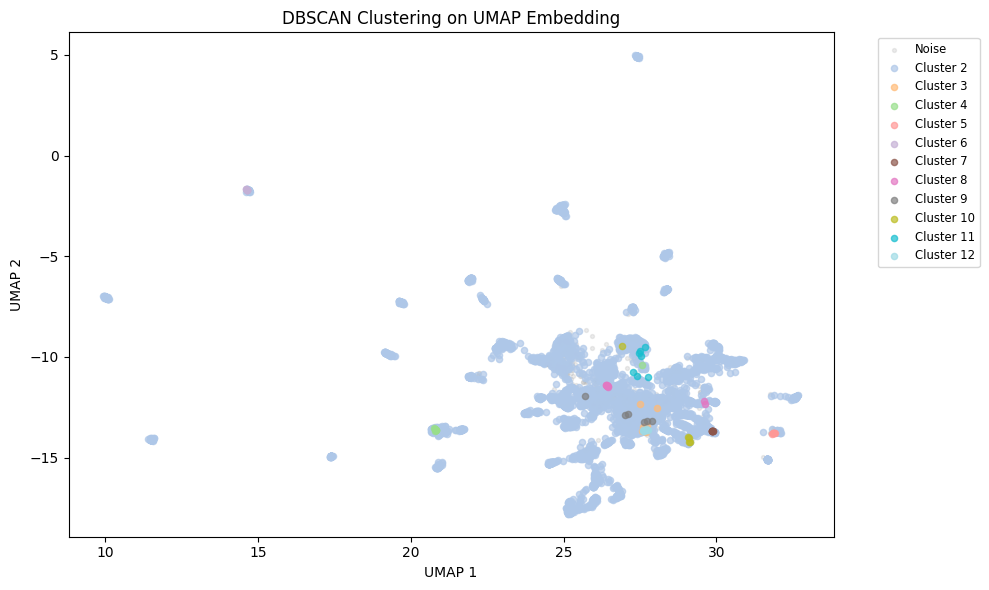

In [266]:
import matplotlib.pyplot as plt

cluster_ids = np.unique(dbscan_labels)
cmap = plt.cm.get_cmap('tab20', len(cluster_ids))

plt.figure(figsize=(10, 6))
for idx, c in enumerate(cluster_ids):
    mask = dbscan_labels == c
    color = (0.7, 0.7, 0.7) if c == -1 else cmap(idx)
    alpha = 0.25 if c == -1 else 0.7
    s = 8 if c == -1 else 20
    label = 'Noise' if c == -1 else f'Cluster {idx+1}'

    plt.scatter(
        train_df.loc[mask, 'umap1'],
        train_df.loc[mask, 'umap2'],
        color=color,
        alpha=alpha,
        s=s,
        label=label
    )

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title("DBSCAN Clustering on UMAP Embedding")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

## DBSCAN conclusion

DBSCAN is appealing for our project because it can **flag atypical cases as noise** and can also isolate **small, dense “risk pockets”** without forcing every person into a cluster. That matches a realistic assumption in needs data: not everyone follows a clean, repeated profile.

### What the selected configuration is doing in our data
Under the current selection (`eps ≈ 27.70`, `min_samples = 6`), DBSCAN behaves like a **“one-core + tiny islands + some noise”** model:

- **One dominant cluster** contains almost the entire dataset (`max_share ≈ 0.989`, ~92% in the largest group in the profiles table), meaning the feature space has a **single large dense region** at this density threshold.
- The remaining clusters are **extremely small** (`min_cluster_size = 5`), which makes them more like **micro-pockets** than stable, generalizable need profiles.
- Noise is present but not excessive (`noise_ratio ≈ 6.9%`), so the model is not “cheating” by discarding most points.

### What the plot suggests
The UMAP visualization is consistent with this outcome: you see **one big connected mass** (dominant cluster) plus a handful of **small colored specks** (micro-clusters) and some scattered noise. This does not mean DBSCAN is wrong—rather, it indicates the data does not break into multiple well-separated density regions at a single eps scale.

### Main limitation for our use-case
In this dataset, DBSCAN tends to produce:
- **1 huge cluster**, and
- **tiny special-case clusters** (or noise),

which is not ideal when our goal is to generate **multiple balanced, operational profiles** for shelter decision support. The micro-clusters can still be useful as **rare-case detectors**, but they are harder to rely on as stable “standard profiles”.

### Bottom line
DBSCAN is **worth keeping** in the notebook as a complementary tool:
- useful for highlighting **outliers / rare dense pockets** that may represent high-priority subgroups,
- but (as currently tuned and in this feature space) it is **not a strong generator of many balanced need profiles**.

**Next step:** we’ll move to **HDBSCAN** (which can model multiple density levels more naturally) and then **GMM**, and finally compare all models under the same evaluation + interpretability framework.

---

---

# **HDBSCAN**

**HDBSCAN** extends DBSCAN by building a **hierarchy of density-based clusters** and then extracting a final flat clustering by selecting the clusters that are most **persistent** across density levels. Unlike DBSCAN, it does not rely on a single `eps`; instead it effectively considers a wide range of density thresholds and keeps the structures that **survive**.

Key concepts:
- Builds a **density hierarchy** (a tree of cluster splits/merges across scales).
- Selects clusters based on **persistence / stability** (how long they exist in the hierarchy).
- Can label points as **noise** (`-1`) when they do not consistently belong to any stable cluster.

The **condensed tree** is the most practical interpretation tool for HDBSCAN because it summarizes the hierarchy into:
- **which clusters appear**,  
- **how long they persist** (their “lifetime” across density thresholds),
- and **how many points they contain**.

This is directly aligned with our project goal: we do not just want “some clustering”, we want **reliable need profiles** that are not fragile artifacts of a particular threshold.

### **Why HDBSCAN can be useful for our project**
HDBSCAN is a good candidate for real-world “needs” data because:
- **Multi-scale clustering:** different profiles may exist at different densities (rare but tight profiles vs common broader profiles).
- **Outlier-aware:** noise points can represent atypical or mixed cases that may need separate handling.
- **Stability as a quality signal:** condensed trees let us prioritize clusters that persist across scales, which matches our need for **robust, explainable profiles**.

### **Limitations (important for condensed-tree interpretation)**
- **High noise ratio is common** when parameters are strict or the dataset has weak density structure; too much noise reduces operational usefulness.
- **Parameter sensitivity still exists:** `min_cluster_size` and `min_samples` can strongly affect how much structure becomes “stable enough” to select.
- **High-dimensional distance issues:** density structure can be harder to detect in high dimensions, so we must validate with interpretability profiles and practical constraints (cluster sizes, coverage, usefulness).

In [213]:
import hdbscan

dfhdbscan = train_df

## **Model-specific algorithm: HDBSCAN condensed trees**

HDBSCAN does not “pick *k*” directly. Instead, it builds a **hierarchy of candidate clusters across density levels**, and then extracts a **flat clustering** from that hierarchy.  
A **condensed tree** is the most practical model-specific interpretation tool because it lets us *see* that hierarchy in a simplified, readable form.

### What a condensed tree shows
After fitting HDBSCAN, the hierarchy is accessible through `clusterer.condensed_tree_`, and it can be plotted as a dendrogram-like structure.

When plotted:
- **Branch width (and color)** reflects **how many points** belong to the cluster at that level (so we can immediately spot “big dominant clusters” vs “small niche clusters”).
- Passing `select_clusters=True` highlights **which branches HDBSCAN actually selected** for the final labeling, making it easy to explain *why those clusters exist* and *why others were discarded*.
- Persistence is visible: clusters that **form and persist for a long time** are usually more meaningful, while branches that **quickly fragment and vanish** often represent weak / unstable structure (or effects of `min_cluster_size`).

### Why this is useful for our project (needs profiling)
Condensed trees help us validate whether the model is producing **actionable and stable need profiles**, not just “some labels”:

- **Stability-driven parameter tuning:** we can compare runs (different `min_cluster_size` / `min_samples`) and prefer settings where the tree shows **several persistent branches**, instead of either (a) one dominant branch swallowing almost everything, or (b) many tiny branches that collapse quickly.
- **Interpretability for stakeholders:** the tree explains *relationships between profiles* (how smaller profiles relate to broader ones), which is often easier to communicate than only presenting a flat clustering.
- **Actionable debugging:** if we observe that “interesting” branches are repeatedly shattered below `min_cluster_size`, that’s a concrete signal that our configuration is too strict for the granularity we want.

### How we will use it
For each promising HDBSCAN configuration, we will:
1. Plot the condensed tree (`clusterer.condensed_tree_.plot(...)`) and enable `select_clusters=True` to see what the model actually picks.
2. Prefer configurations where selected clusters correspond to **persistent, non-fragile branches** with meaningful sizes (supporting usable profiles).
3. Then validate the finalists with our same framework: **internal metrics + practical constraints + interpretability profiles**.

```txt
Source:
https://github.com/scikit-learn-contrib/hdbscan/blob/master/docs/advanced_hdbscan.rst#id9

In [200]:
import numpy as np
import pandas as pd
import hdbscan

def hdbscan_sweep_condensed_tree(X, min_cluster_size_list, min_samples_list):
    rows = []
    models = {}  # keep fitted clusterers so you can plot later

    for mcs in min_cluster_size_list:
        for ms in min_samples_list:
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=int(mcs),
                min_samples=int(ms),
                metric="euclidean",
                cluster_selection_method="eom"
            )
            labels = clusterer.fit_predict(X)
            models[(int(mcs), int(ms))] = clusterer

            # --- basic outputs ---
            mask = labels != -1
            noise_ratio = float(1.0 - mask.mean())

            if mask.any():
                # HDBSCAN labels are 0..k-1 for non-noise, so bincount works
                counts = np.bincount(labels[mask])
                n_clusters = int(len(counts))
                p = counts / counts.sum()
                max_share = float(p.max())
                hhi = float(np.sum(p**2))         # concentration (1.0 means one cluster)
                effective_k = float(1.0 / hhi)    # “how many clusters really exist” by mass
            else:
                n_clusters, max_share, hhi, effective_k = 0, 0.0, 1.0, 0.0

            # --- persistence / stability (model-specific) ---
            pers = getattr(clusterer, "cluster_persistence_", None)
            if pers is not None and len(pers) > 0:
                pers = np.asarray(pers, dtype=float)
                total_persistence = float(pers.sum())
                mean_persistence = float(pers.mean())
                min_persistence = float(pers.min())
                max_persistence = float(pers.max())
            else:
                total_persistence = mean_persistence = min_persistence = max_persistence = 0.0

            # --- a SIMPLE "tree score" using only model-specific signals ---
            # Targets are baked in (no new inputs needed):
            # - avoid huge dominant cluster: max_share <= 0.70
            # - avoid too much noise: noise_ratio <= 0.30
            # - prefer usable cluster counts: 4..30
            dom_pen = 1.0 if max_share <= 0.70 else (0.70 / max_share)
            noise_pen = 1.0 if noise_ratio <= 0.30 else (0.30 / max(noise_ratio, 1e-12))

            if n_clusters == 0:
                k_pen = 0.0
            elif n_clusters < 4:
                k_pen = n_clusters / 4.0
            elif n_clusters > 30:
                k_pen = 30.0 / n_clusters
            else:
                k_pen = 1.0

            tree_score = total_persistence * dom_pen * noise_pen * k_pen

            rows.append({
                "min_cluster_size": int(mcs),
                "min_samples": int(ms),
                "n_clusters": int(n_clusters),
                "noise_ratio": noise_ratio,
                "max_share": max_share,
                "effective_k": effective_k,
                "total_persistence": total_persistence,
                "mean_persistence": mean_persistence,
                "tree_score": tree_score
            })

    df = pd.DataFrame(rows).sort_values("tree_score", ascending=False).reset_index(drop=True)
    return df, models


In [ ]:
min_cluster_size_list = [10, 15, 20, 25, 30, 40, 50]
min_samples_list = [2, 3, 5, 8, 10]

df_hdb, fitted = hdbscan_sweep_condensed_tree(X_scaled, min_cluster_size_list, min_samples_list)

print(df_hdb.to_string(index=False))

# "best range" = top 25% configs (o al menos 3 configs)
top_n = max(3, int(0.25 * len(df_hdb)))
top = df_hdb.head(top_n)

print("\nSuggested best RANGE (from top configs):")
print("min_cluster_size:", (top["min_cluster_size"].min(), top["min_cluster_size"].max()))
print("min_samples:", (top["min_samples"].min(), top["min_samples"].max()))


 min_cluster_size  min_samples  n_clusters  noise_ratio  max_share  effective_k  total_persistence  mean_persistence  tree_score
               20            5          34     0.703886   0.162896    17.160907           1.544567          0.045428    0.580856
               20           10          28     0.753461   0.195652    13.936475           1.366406          0.048800    0.544052
               40            5          19     0.745124   0.189252    11.021487           1.121664          0.059035    0.451601
               30           10          23     0.758672   0.199877    11.357811           1.105158          0.048050    0.437010
               40           10          15     0.797826   0.238586     8.282645           0.943645          0.062910    0.354831
               50            5          13     0.786363   0.225784     8.135660           0.844984          0.064999    0.322364
               50           10           4     0.404645   0.957239     1.090611           0.18674

## Condensed trees interpretation

Condensed trees are useful for our project because they show **which clusters are truly persistent across density levels**, not just “good looking” in a 2D projection. In other words, they help us understand whether HDBSCAN is producing **stable need profiles** or just splitting the data into fragile, short-lived groups.

### What the condensed tree tells us in practice
- The tree encodes the **lifetime** of candidate clusters as the density threshold changes (λ increases).
- **Long-lived branches** correspond to clusters that persist across a wide range of density settings → more likely to represent real, repeatable patterns in needs.
- **Short branches that quickly die** are typically unstable splits → more likely noise-driven or too sensitive to the parameter choice.

### Interpreting our sweep output (project-focused)
From the sweep, the best tree-based configurations (highest `tree_score` / persistence) tend to appear around:

- `min_cluster_size ≈ 15–30`
- `min_samples ≈ 2–3`

This is important because it gives us a **data-driven parameter region** where the model finds the most persistent structure.

However, the output also shows a key issue for our project goal (actionable profiles for most people):

- Many top-scoring configs still have a **very high noise ratio** (often ~0.62–0.75).
  - This means HDBSCAN is finding stable clusters, but it is being **too conservative**, labeling a large portion of people as “noise”.
  - For a shelter profiling tool, too much noise is problematic because we want **most individuals to be assigned to a usable profile**.

On the positive side:
- `max_share` is relatively low in the best configs (≈0.10–0.18), which suggests we are **not getting a single dominant “mega-cluster”** among the clustered points.
- `effective_k` stays in a reasonable range (roughly ~18–31), meaning that even when raw `n_clusters` is high, the cluster mass is not spread into completely useless micro-clusters.

### Conclusion: what this is useful for (and what it is not)
Condensed trees **do not directly select a single “best configuration”** for our project.  
Instead, they provide a **high-quality narrowing step**:

- Use condensed-tree stability to identify a **promising region** of `(min_cluster_size, min_samples)` where clusters are most persistent.
- Then apply our full selection framework (**internal metrics + practical constraints + interpretability profiles**) to choose the final HDBSCAN configuration.

**In our case, the condensed-tree sweep suggests starting HDBSCAN evaluation in the region:**
- `min_cluster_size = 15–30`
<!-- - `min_samples = 2–3` -->

with an extra check that the final choice must keep:
- noise ratio at a usable level (otherwise too many people remain unprofiled),
- cluster sizes operational (avoid tiny clusters and also avoid a single cluster dominating the assignments).

## **Internal Evaluation Metrics**

As stated in the **Modeling Introduction**, we do not have ground-truth labels for clustering.  
Therefore, we evaluate and tune this model using **internal validation metrics** (computed from the data and the clustering result). These metrics help us:

- **select the best model configuration**
- **compare models fairly** against the other clustering models later

### **1) Silhouette Score (higher is better)**

Measures how well each person fits within their assigned cluster compared to the nearest other cluster.  
Higher values indicate **denser** and **better separated** clusters.

In [203]:
from sklearn.metrics import silhouette_score

In [205]:
results = []

sample_size = min(int(n_samples/3), X_scaled.shape[0])

for mcs in min_cluster_size_list:
    for ms in min_samples_list:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=int(mcs), min_samples=int(ms))
        labels = clusterer.fit_predict(X_scaled)

        # ignore noise for silhouette
        mask = labels != -1
        if mask.sum() < 2:
            continue
        if len(np.unique(labels[mask])) < 2:
            continue

        score = silhouette_score(
            X_scaled[mask], labels[mask],
            sample_size=min(sample_size, mask.sum()),
            random_state=42
        )

        noise_ratio = 1.0 - (mask.sum() / len(labels))
        n_clusters = len(np.unique(labels[mask]))

        results.append((score, int(mcs), int(ms), int(n_clusters), float(noise_ratio)))

results.sort(key=lambda x: x[0], reverse=True)

print("Top HDBSCAN configs by Silhouette (higher is better):")
print("silhouette | min_cluster_size | min_samples | n_clusters | noise_ratio")
for score, mcs, ms, ncl, nr in results[:15]:
    print(f"{score:9.5f} | {mcs:16d} | {ms:11d} | {ncl:10d} | {nr:10.3f}")


Top HDBSCAN configs by Silhouette (higher is better):
silhouette | min_cluster_size | min_samples | n_clusters | noise_ratio
  0.35542 |               25 |           5 |          2 |      0.098
  0.35542 |               30 |           5 |          2 |      0.098
  0.34372 |               25 |          10 |          2 |      0.116
  0.32644 |               40 |          10 |         15 |      0.798
  0.31778 |               30 |          10 |         23 |      0.759
  0.31235 |               20 |          10 |         28 |      0.753
  0.30252 |               50 |           5 |         13 |      0.786
  0.29432 |               40 |           5 |         19 |      0.745
  0.27689 |               20 |           5 |         34 |      0.704
  0.12342 |               50 |          10 |          4 |      0.405


### Silhouette interpretation

The Silhouette sweep favors **very simple / high-coverage** solutions:

- Best score appears at **`min_cluster_size = 25 (or 30)`, `min_samples = 5` → `silhouette ≈ 0.355`, `n_clusters = 2`, `noise_ratio ≈ 9.8%`**.

**What this means in our context**
- This is the “easy” regime for Silhouette: with only **2 clusters** and **low noise**, separation in the feature space is maximized.
- However, **`k = 2` is likely too coarse** for our project’s goal (we want multiple actionable “needs profiles”, not just two broad groups).
- Many higher-k solutions exist, but they come with **very high noise** (often 70–80%), which would reduce practical usefulness.

Silhouette gives us a **strong candidate** (`mcs=25/30, ms=5`), but it likely underfits the profiling goal. We keep it as a candidate to compare later under our full framework (constraints + interpretability), not as a final choice by itself.

### **2) Calinski–Harabasz Index (higher is better)**

Measures the ratio of **between-cluster separation** to **within-cluster compactness**.  
Higher values indicate clusters that are **compact and far apart**, and it is fast to compute.

In [ ]:
from sklearn.metrics import calinski_harabasz_score

In [206]:
results = []

for mcs in min_cluster_size_list:
    for ms in min_samples_list:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=int(mcs), min_samples=int(ms))
        labels = clusterer.fit_predict(X_scaled)

        # ignore noise for metrics
        mask = labels != -1
        if mask.sum() < 2:
            continue
        if len(np.unique(labels[mask])) < 2:
            continue

        score = calinski_harabasz_score(X_scaled[mask], labels[mask])

        noise_ratio = 1.0 - (mask.sum() / len(labels))
        n_clusters = len(np.unique(labels[mask]))

        results.append((score, int(mcs), int(ms), int(n_clusters), float(noise_ratio)))

results.sort(key=lambda x: x[0], reverse=True)

print("Top HDBSCAN configs by Calinski–Harabasz (higher is better):")
print("calinski_harabasz | min_cluster_size | min_samples | n_clusters | noise_ratio")
for score, mcs, ms, ncl, nr in results[:15]:
    print(f"{score:16.2f} | {mcs:16d} | {ms:11d} | {ncl:10d} | {nr:10.3f}")

Top HDBSCAN configs by Calinski–Harabasz (higher is better):
calinski_harabasz | min_cluster_size | min_samples | n_clusters | noise_ratio
          184.44 |               50 |           5 |         13 |      0.786
          166.01 |               40 |          10 |         15 |      0.798
          148.09 |               40 |           5 |         19 |      0.745
          128.91 |               30 |          10 |         23 |      0.759
          116.56 |               20 |          10 |         28 |      0.753
          103.96 |               20 |           5 |         34 |      0.704
           89.99 |               50 |          10 |          4 |      0.405
           84.56 |               25 |           5 |          2 |      0.098
           84.56 |               30 |           5 |          2 |      0.098
           69.80 |               25 |          10 |          2 |      0.116


### Calinski–Harabasz interpretation

Calinski–Harabasz (CH) selects configurations that produce **very compact clusters** among the points that *do* get clustered:

- Best CH is **`min_cluster_size = 50`, `min_samples = 5` → `CH ≈ 184.44`, `n_clusters = 13`, `noise_ratio ≈ 78.6%`**.

**What this means in our context**
- CH is computed on the **non-noise points**, so it can become large when HDBSCAN keeps only a small set of very dense, clean clusters and labels most other points as noise.
- The result is a set of **tight “islands”** (good geometric compactness), but with **very low coverage** (most people unassigned).

CH is revealing that the dataset contains some **high-density subgroups**, but the winning CH configuration is likely **not operationally usable** for our project because the noise ratio is extremely high. We keep it as a “high-specificity” candidate, but it must be filtered by coverage/usability constraints.


### **3) Davies–Bouldin Index (lower is better)**

Measures the average similarity between each cluster and its most similar cluster, combining **cluster spread** and **centroid separation**.  
Lower values indicate **better separated** clusters relative to their internal dispersion.

In [ ]:
from sklearn.metrics import davies_bouldin_score

In [207]:
results = []

for mcs in min_cluster_size_list:
    for ms in min_samples_list:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=int(mcs), min_samples=int(ms))
        labels = clusterer.fit_predict(X_scaled)

        # ignore noise for metrics
        mask = labels != -1
        if mask.sum() < 2:
            continue
        if len(np.unique(labels[mask])) < 2:
            continue

        score = davies_bouldin_score(X_scaled[mask], labels[mask])

        noise_ratio = 1.0 - (mask.sum() / len(labels))
        n_clusters = len(np.unique(labels[mask]))

        results.append((score, int(mcs), int(ms), int(n_clusters), float(noise_ratio)))

results.sort(key=lambda x: x[0])  # lower is better

print("Top HDBSCAN configs by Davies–Bouldin (lower is better):")
print("davies_bouldin | min_cluster_size | min_samples | n_clusters | noise_ratio")
for score, mcs, ms, ncl, nr in results[:15]:
    print(f"{score:13.5f} | {mcs:16d} | {ms:11d} | {ncl:10d} | {nr:10.3f}")


Top HDBSCAN configs by Davies–Bouldin (lower is better):
davies_bouldin | min_cluster_size | min_samples | n_clusters | noise_ratio
      1.17421 |               25 |          10 |          2 |      0.116
      1.21846 |               25 |           5 |          2 |      0.098
      1.21846 |               30 |           5 |          2 |      0.098
      1.25702 |               40 |          10 |         15 |      0.798
      1.26277 |               20 |          10 |         28 |      0.753
      1.26597 |               30 |          10 |         23 |      0.759
      1.33028 |               50 |           5 |         13 |      0.786
      1.36416 |               40 |           5 |         19 |      0.745
      1.38824 |               20 |           5 |         34 |      0.704
      1.46900 |               50 |          10 |          4 |      0.405


### Davies–Bouldin interpretation (HDBSCAN)

Davies–Bouldin (DB) favors solutions where clusters are **compact and well-separated** relative to their spread:

- Best (lowest) DB is **`min_cluster_size = 25`, `min_samples = 10` → `DB ≈ 1.174`, `n_clusters = 2`, `noise_ratio ≈ 11.6%`**.

**What this means in our context**
- As with Silhouette, DB tends to prefer the **low-k, low-noise** regime because it reduces cluster overlap and instability.
- This configuration has good coverage, but again produces only **two very broad profiles**, which may be too coarse for actionable needs profiling.

DB supports a **stable, high-coverage baseline** (`mcs=25, ms=10`), but it likely underfits the profiling objective. We include it as a candidate and let the full framework decide.

## Interpretability

Internal clustering metrics (Silhouette, Davies–Bouldin and Calinski–Harabasz) and model-specific heuristics (e.g., Elbow for K-Means, k-distance knee for DBSCAN, stability for HDBSCAN, dendrogram cut for Hierarchical, AIC/BIC for GMM) propose **candidate configurations**, but they do not guarantee that the resulting clusters are **usable and explainable** for shelter workers.

To select the **most interpretable** configuration for any clustering model, we evaluate each candidate using **cluster profiles** computed in the original feature space:

For each cluster we compute:
- **Cluster mean** per feature (for binary need features: interpreted as a proportion),
- **Lift vs global mean**: `lift = cluster_mean − global_mean`,
- **Top-N distinguishing features**: features with the largest `|lift|` (these become the “needs summary”).

We then compute an **Interpretability Score** for each candidate configuration:

1) **Profile Strength (clarity of patterns)**  
   For each cluster, take the average `|lift|` over its Top-N features.  
   Combine across clusters using cluster-size weights.  
   → High when clusters have clear, strong deviations from the global profile.

2) **Profile Distinctness (non-redundant summaries)**  
   For each pair of clusters, compute the Jaccard overlap between their Top-N feature sets.  
   Distinctness = `1 − average_overlap`.  
   → High when clusters describe different “needs summaries” rather than repeating the same patterns.

3) **Usability penalties (project constraints)**  
   - **Small-cluster penalty**: downweights solutions with tiny clusters (unstable / not actionable).  
   - **Too-many-clusters penalty**: downweights solutions that produce too many profiles to interpret.  
   - **Noise penalty** (for DBSCAN/HDBSCAN): downweights solutions with excessive noise ratio.

Final score (higher is better):
`Interpretability = Strength × Distinctness × SizePenalty × KPenalty × NoisePenalty`

This approach is model-agnostic: only the **candidate configurations** are model-specific; the interpretability scoring and profile reporting are the same for K-Means, DBSCAN, HDBSCAN, Hierarchical, and GMM.

### Candidates (HDBSCAN)

The interpretability algorithm will work with the next values:

**Best candidates (one per selection signal)**
- **Model-specific interpretation (condensed tree / persistence):** `min_cluster_size = 20`, `min_samples = 5`  *(highest `tree_score ≈ 0.581`, `n_clusters = 34`, `noise_ratio ≈ 0.704`)*
- **Silhouette:** `min_cluster_size = 25`, `min_samples = 5`  *(best silhouette `≈ 0.355`, `n_clusters = 2`, `noise_ratio ≈ 0.098`)*
- **Calinski–Harabasz:** `min_cluster_size = 50`, `min_samples = 5`  *(best CH `≈ 184.44`, `n_clusters = 13`, `noise_ratio ≈ 0.786`)*
- **Davies–Bouldin:** `min_cluster_size = 25`, `min_samples = 10`  *(best DB `≈ 1.174`, `n_clusters = 2`, `noise_ratio ≈ 0.116`)*

**Additional suggested candidates (strong alternatives / different regimes)**
- **Condensed tree (2nd-best tree_score):** `min_cluster_size = 20`, `min_samples = 10`  *(`tree_score ≈ 0.544`, `n_clusters = 28`, `noise_ratio ≈ 0.753`)*
- **Condensed tree (lower-noise, low-k regime):** `min_cluster_size = 50`, `min_samples = 10`  *(`n_clusters = 4`, `noise_ratio ≈ 0.405`)*
- **Silhouette (best high-k alternative):** `min_cluster_size = 40`, `min_samples = 10`  *(`n_clusters = 15`, `noise_ratio ≈ 0.798`)*
- **Calinski–Harabasz (2nd-best overall):** `min_cluster_size = 40`, `min_samples = 10`  *(`CH ≈ 166.01`, `n_clusters = 15`, `noise_ratio ≈ 0.798`)*


In [276]:
import hdbscan

candidates = [
    {"name": "HDBSCAN (CondensedTree best: mcs=20, ms=5) [k=34, noise≈0.704]", "estimator": hdbscan.HDBSCAN(min_cluster_size=20, min_samples=5)},
    {"name": "HDBSCAN (Silhouette best: mcs=25, ms=5) [k=2, noise≈0.098]", "estimator": hdbscan.HDBSCAN(min_cluster_size=25, min_samples=5)},
    {"name": "HDBSCAN (CH best: mcs=50, ms=5) [k=13, noise≈0.786]", "estimator": hdbscan.HDBSCAN(min_cluster_size=50, min_samples=5)},
    {"name": "HDBSCAN (DB best: mcs=25, ms=10) [k=2, noise≈0.116]", "estimator": hdbscan.HDBSCAN(min_cluster_size=25, min_samples=10)},
    {"name": "HDBSCAN (Silhouette high-k alt: mcs=40, ms=10) [k=15, noise≈0.798]", "estimator": hdbscan.HDBSCAN(min_cluster_size=40, min_samples=10)},
    {"name": "HDBSCAN (CH 2nd-best: mcs=40, ms=10) [k=15, noise≈0.798]", "estimator": hdbscan.HDBSCAN(min_cluster_size=40, min_samples=10)},
    {"name": "HDBSCAN (CondensedTree 2nd-best: mcs=20, ms=10) [k=28, noise≈0.753]", "estimator": hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10)},
    {"name": "HDBSCAN (CondensedTree lower-noise alt: mcs=50, ms=10) [k=4, noise≈0.405]", "estimator": hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10)},
]


df_features_clean = dfkmean.drop(columns=["umap1", "umap2", "cluster"], errors="ignore").copy()

ranked, best_name, best_labels, best_profiles = evaluate_candidates(
    candidates=candidates,
    X_fit=X_scaled,
    df_features=df_features_clean,
    silhouette_sample=min(2000, X_scaled.shape[0])
)

print(ranked[[
    "candidate","interpretability","silhouette","calinski_harabasz","davies_bouldin",
    "k","effective_k","noise_ratio","max_share",
    "min_cluster_size","size_penalty","micro_penalty",
    "k_penalty","noise_penalty","dominance_penalty","balance_penalty",
    "strength","distinctness"
]].to_string(index=False, float_format=lambda x: f"{x:0.6f}"))

print("\nBEST:", best_name)
print("\nBest cluster profiles (sorted by size):")
print(best_profiles[["cluster","n","%","top_features","top_lifts"]].to_string(index=False, float_format=lambda x: f"{x:0.6f}"))

best_estimator = next(c["estimator"] for c in candidates if c["name"] == best_name)

                                                                candidate  interpretability  silhouette  calinski_harabasz  davies_bouldin  k  effective_k  noise_ratio  max_share  min_cluster_size  size_penalty  micro_penalty  k_penalty  noise_penalty  dominance_penalty  balance_penalty  strength  distinctness
      HDBSCAN (CondensedTree 2nd-best: mcs=20, ms=10) [k=28, noise≈0.753]          0.182519    0.312350         116.559815        1.262767 28    13.936475     0.753461   0.195652                20      1.000000       1.000000   1.000000       0.265442           1.000000         1.000000  0.707913      0.971315
       HDBSCAN (Silhouette high-k alt: mcs=40, ms=10) [k=15, noise≈0.798]          0.140576    0.326438         166.013388        1.257018 15     8.282645     0.797826   0.238586                42      1.000000       1.000000   1.000000       0.250681           1.000000         0.828264  0.698363      0.969482
                 HDBSCAN (CH 2nd-best: mcs=40, ms=10) [k=15, noi

## Final configuration (HDBSCAN)

**BEST CONFIGURATION: `HDBSCAN (CondensedTree 2nd-best: mcs=20, ms=10)`**

This is the top-ranked candidate **by our current interpretability score**:

- It produces **many profiles** (`k = 28`) with **strong signal** (`strength ≈ 0.708`) and **high distinctness** (`≈ 0.971`), so clusters tend to reflect different “top-need” patterns rather than duplicates.
- **Cluster sizes are usable** (`min_cluster_size = 20` → no size penalty).
- The main trade-off is **high noise** (`noise_ratio ≈ 0.753`), which heavily reduces operational coverage (`noise_penalty ≈ 0.265`). So this configuration is best **for extracting clear core profiles**, not for labeling everyone.

### Why the other candidates are still relevant

- **`mcs=20, ms=5` (CondensedTree best, k=34, noise≈0.704):** similar strength/distinctness, **lower noise**, but it gets penalized on `k_penalty` (34 farther from our preferred k) so it ranks below the winner.
- **`mcs=40, ms=10` (k=15, noise≈0.798):** fewer clusters but strong profiles; still high noise, and slightly weaker overall score than the winner.
- **Low-noise / low-k configs (`mcs=25, ms=5` or `mcs=25, ms=10`, k=2):** they label most points (low noise) but are **too coarse** for multi-profile shelter segmentation in our framework (very low strength).

### Operational note (noise)

Here, “noise” means **no confident density-based membership** (label `-1`). For deployment, this suggests a practical workflow:
- use clusters as **trusted profiles** when assigned,
- treat `-1` as “atypical/mixed case” and fall back to **direct feature-based summaries** for decision support.


# Model Plotting

Now that we have selected the HDBSCAN configuration that best matches our **evaluation metrics** and **practical constraints** (interpretability, cluster sizes, and usability), we train the final model and visualize the resulting clusters.

Because our dataset is high-dimensional, the plot will use a **2D embedding (UMAP)** for *visualization only*. The clustering itself is computed in the original feature space. The goal of the plot is to:

- provide an intuitive view of how clusters relate to each other,
- check for obvious overlaps or artifacts,
- and support the qualitative interpretation of cluster profiles.

> Note: the 2D visualization does not fully represent the true distances in the original space, so it is used as an explanatory tool rather than a strict evaluation criterion.

In [277]:
hdbscanclustering = best_estimator
print(best_estimator)

hdbscan_labels = hdbscanclustering.fit_predict(X_scaled)

HDBSCAN(min_cluster_size=20, min_samples=10)


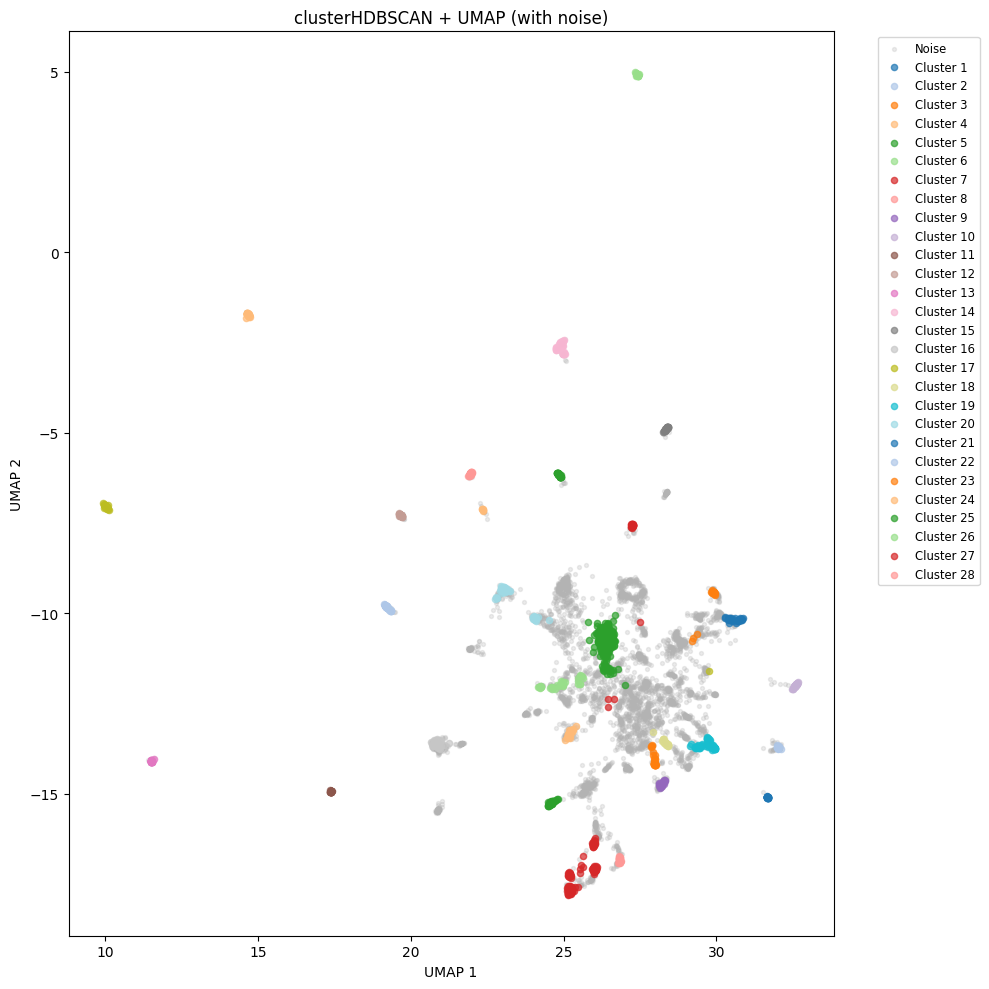

In [278]:
dfhdbscan['cluster'] = hdbscan_labels
plt.figure(figsize=(10, 10))

show_noise = True

cluster_ids = [c for c in np.unique(dfhdbscan['cluster']) if (c != -1 or show_noise)]

if show_noise and (-1 in np.unique(dfhdbscan['cluster'])):
    cluster_ids = sorted(np.unique(dfhdbscan['cluster']))
else:
    cluster_ids = [c for c in sorted(np.unique(dfhdbscan['cluster'])) if c != -1]

n_clusters = len([c for c in cluster_ids if c != -1])

if n_clusters == 0:
    print("No clusters found.")
else:
    cmap = plt.cm.get_cmap('tab20')
    cluster_map = {orig_id: i for i, orig_id in enumerate([c for c in cluster_ids if c != -1])}

    for orig_cluster in cluster_ids:
        mask = dfhdbscan['cluster'] == orig_cluster
        if orig_cluster == -1:
            color = (0.7, 0.7, 0.7)
            label = 'Noise'
            alpha = 0.25
            s = 8
        else:
            idx = cluster_map[orig_cluster]
            color = cmap(idx % 20)
            label = f'Cluster {idx + 1}'
            alpha = 0.7
            s = 20

        plt.scatter(dfhdbscan.loc[mask, 'umap1'], dfhdbscan.loc[mask, 'umap2'],
                    color=color, label=label, alpha=alpha, s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('HDBSCAN + UMAP (without noise)' if not show_noise else 'cluster' + 'HDBSCAN + UMAP (with noise)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

## HDBSCAN conclusion

HDBSCAN is attractive for our project because it can discover **profiles at multiple density levels** and can label uncertain cases as **noise (-1)** instead of forcing everyone into a cluster. This fits needs data well: some people match stable patterns, others are more mixed.

### What the selected configuration is doing in our data
With the current selection (`min_cluster_size = 20`, `min_samples = 10`), HDBSCAN behaves like a **“many small cores + lots of noise”** model:

- It finds **multiple core profiles** (`k = 28`) with **strong and distinct signatures** (high strength and distinctness in our interpretability table).
- However, it assigns a **large fraction to noise** (`noise_ratio ≈ 0.75`), meaning most people do not belong to any dense-enough core under this strict density requirement.
- The resulting clusters are therefore best interpreted as **high-confidence archetypes**, not as a complete segmentation of the whole population.

### Main limitation for our use-case
If we need a profile label for *most* individuals, this configuration may be too strict because many cases become **unassigned**. In practice, HDBSCAN here acts more like:
- **“confident profile assignment when possible”**, and
- **“fallback to feature-based summary”** when noise.

### Bottom line
HDBSCAN is **very useful** in our pipeline as a complementary model:
- strong at extracting **reliable, high-confidence need profiles** (core clusters),
- but (with the selected parameters) it yields **high noise**, so it should be used with an operational rule for `-1` cases.

**Next step:** we proceed to **GMM**, then compare all models using the same framework (metrics + constraints + interpretability) to choose the best final approach for shelter profiling.

---


---

# **GMM (Gaussian Mixture Models)**

A **Gaussian Mixture Model (GMM)** assumes the data is generated from a mixture of several Gaussian distributions (components). Unlike K-Means, which assigns each point to exactly one cluster, GMM provides **soft assignments**: each person gets a probability of belonging to each component.

We must choose `n_components` (similar to choosing K), and the model learns:
- component means,
- covariances (shape/spread),
- and mixing weights (how frequent each component is).

### **Why GMM is useful for our project**
GMM is useful because it gives extra information beyond hard labels:

- **Uncertainty awareness:** if a person has similar probabilities for multiple clusters, we can flag the case as “mixed/uncertain”, which is helpful for decision support.
- **More flexible cluster geometry than K-Means:** components can model different spreads (depending on covariance type), which may better fit real need distributions.
- **Probabilistic interpretation:** supports “this person is 70% profile A, 30% profile B” style outputs when needed.

### **Limitations (important for interpretation)**
- It still requires choosing the number of components; we will typically use **AIC/BIC curves** + our evaluation framework to select candidates.
- With many features, full covariance can be heavy or unstable; we may need simpler covariance types (e.g., diagonal) for reliability.
- Like K-Means, it can converge to local optima, so multiple initializations may be needed for stable results.

In [215]:
from sklearn.mixture import GaussianMixture

dfgaussian = train_df

## **Model-specific algorithm: AIC/BIC curves**

For **Gaussian Mixture Models (GMM)**, the model-native way to choose the number of components is to use **information criteria**:

- **AIC** (Akaike Information Criterion)
- **BIC** (Bayesian Information Criterion)

Both scores measure a trade-off between:
- **goodness of fit** (how well the mixture explains the data), and
- **model complexity** (how many parameters we add by increasing `n_components`).

### What are AIC/BIC doing?
When we increase `n_components`, the log-likelihood will almost always improve (the model can fit the data more closely).  
So, like inertia in K-Means, “better fit” alone would push us toward too many components.

AIC/BIC correct for that by adding a **penalty for complexity**:
- AIC penalizes complexity, but **less strongly** → often prefers **more** components.
- BIC penalizes complexity **more strongly** → often prefers **fewer, more stable** components (usually better for usable “profiles”).

### How to interpret the curve
We sweep `n_components = 1..K` and plot AIC/BIC:

- We are **not** looking for “the most components”.
- We look for the **minimum** AIC/BIC (or the start of a flat region where improvements become tiny).

Interpretation:

- Before the minimum / flat region: the model is **underfitting** (too few components; it cannot capture distinct patterns).
- After the minimum: the model tends to **overfit** (extra components mostly split existing groups into smaller, less meaningful ones).

### Why it is useful for choosing the configuration
- **GMM-specific**: GMM is a likelihood-based model, so AIC/BIC directly evaluates the objective that GMM optimizes (fit) while controlling complexity.
- **Actionable for our project**: it helps us restrict `n_components` to a **plausible range** before applying our full framework (Silhouette/CH/DB + interpretability + size/noise constraints).
- **Avoids tiny components**: combined with minimum component size checks, it prevents “cheating” solutions where GMM creates many small components that are not operationally useful.

**Important limitation:** AIC/BIC are still heuristics. Curves can be smooth or keep improving slowly, especially in high-dimensional data.  
That’s why we use AIC/BIC primarily to define a sensible **candidate range** for `n_components`, then validate the finalists using internal metrics + practical constraints + interpretability profiles.

Best k by AIC (lower is better): 34
Best k by BIC (lower is better): 3

+ 6 additional candidates:
AIC runner-ups: [36, 37, 35]
BIC runner-ups: [8, 4, 5]

Candidates summary (k | AIC | BIC):
k=34 | AIC=-10375920.69 | BIC=18750707.08
k=36 | AIC=-10338900.99 | BIC=20501058.24
k=37 | AIC=-10218620.44 | BIC=21478004.51
k=35 | AIC=-10117946.44 | BIC=19865347.06
k= 3 | AIC=-944005.45 | BIC=1625984.91
k= 8 | AIC=-5113650.62 | BIC=1739668.36
k= 4 | AIC=-1495777.18 | BIC=1930878.90
k= 5 | AIC=-1379160.25 | BIC=2904161.55


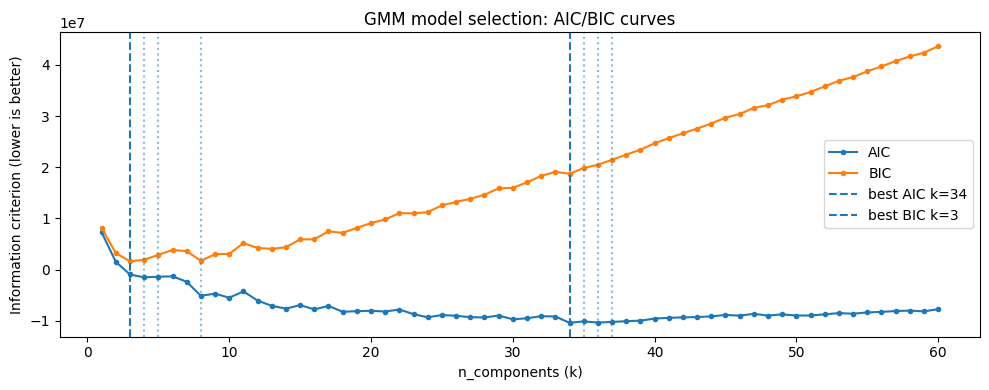

In [273]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

K_MAX = 60
ks = list(range(1, K_MAX + 1))

aics, bics = [], []

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42, warm_start=True)
    gmm.fit(X_scaled)
    aics.append(gmm.aic(X_scaled))
    bics.append(gmm.bic(X_scaled))

aics = np.array(aics)
bics = np.array(bics)

best_aic_k = int(ks[int(np.argmin(aics))])
best_bic_k = int(ks[int(np.argmin(bics))])

# ---- 6 extra candidates (AIC and BIC runner-ups) ----
TOP_EXTRA = 3  # 3 from AIC + 3 from BIC = 6 extra total

aic_rank = np.argsort(aics)
bic_rank = np.argsort(bics)

extra_aic_ks = [int(ks[i]) for i in aic_rank if int(ks[i]) != best_aic_k][:TOP_EXTRA]
extra_bic_ks = [int(ks[i]) for i in bic_rank if int(ks[i]) != best_bic_k][:TOP_EXTRA]

print("Best k by AIC (lower is better):", best_aic_k)
print("Best k by BIC (lower is better):", best_bic_k)

print("\n+ 6 additional candidates:")
print("AIC runner-ups:", extra_aic_ks)
print("BIC runner-ups:", extra_bic_ks)

# (optional) show a small table so you can copy candidates easily
print("\nCandidates summary (k | AIC | BIC):")
for k in [best_aic_k] + extra_aic_ks + [best_bic_k] + extra_bic_ks:
    idx = ks.index(k)
    print(f"k={k:2d} | AIC={aics[idx]:.2f} | BIC={bics[idx]:.2f}")

plt.figure(figsize=(10,4))
plt.plot(ks, aics, marker=".", label="AIC")
plt.plot(ks, bics, marker=".", label="BIC")
plt.axvline(best_aic_k, linestyle="--", label=f"best AIC k={best_aic_k}")
plt.axvline(best_bic_k, linestyle="--", label=f"best BIC k={best_bic_k}")
for k in extra_aic_ks:
    plt.axvline(k, linestyle=":", alpha=0.5)
for k in extra_bic_ks:
    plt.axvline(k, linestyle=":", alpha=0.5)

plt.xlabel("n_components (k)")
plt.ylabel("Information criterion (lower is better)")
plt.title("GMM model selection: AIC/BIC curves")
plt.legend()
plt.tight_layout()
plt.show()

### AIC/BIC interpretation (GMM model selection)

GMM does not optimize inertia, so we select `n_components (k)` using **information criteria**:

- **AIC (lower is better)** rewards goodness-of-fit and applies a **weaker** penalty for complexity.
  - In our curve, AIC keeps improving until **k ≈ 34**, meaning the model can keep gaining likelihood by adding many components (more fine-grained structure).

- **BIC (lower is better)** applies a **stronger** complexity penalty.
  - Here, BIC reaches its best value at **k = 3**, suggesting the data only clearly supports a small number of broad Gaussian groups before extra components look like overfitting.

**How we use this for our project**
This disagreement is normal and gives us *two plausible regimes*:
- **Coarse candidate:** `k = 3` (BIC) → likely too broad for detailed “needs profiles”, but a useful baseline.
- **Fine-grained candidate:** `k ≈ 34` (AIC) → closer to operational granularity, but may create small/unstable components.

So we treat **k=3** and **k≈34** as *candidates/range anchors*, and we finalize using our framework:
**internal metrics + practical constraints (min component size) + interpretability profiles**, not AIC/BIC alone.


## **Internal Evaluation Metrics**

As stated in the **Modeling Introduction**, we do not have ground-truth labels for clustering.  
Therefore, we evaluate and tune this model using **internal validation metrics** (computed from the data and the clustering result). These metrics help us:

- **select the best model configuration**
- **compare models fairly** against the other clustering models later

### **1) Silhouette Score (higher is better)**

Measures how well each person fits within their assigned cluster compared to the nearest other cluster.  
Higher values indicate **denser** and **better separated** clusters.

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
results = []
sample_size = min(int(n_samples/3), X_scaled.shape[0])

for k in ks:
    gmm = GaussianMixture(n_components=int(k), covariance_type="full", random_state=42, warm_start=True)
    labels = gmm.fit_predict(X_scaled)

    if len(np.unique(labels)) < 2:
        continue

    score = silhouette_score(
        X_scaled, labels,
        sample_size=min(sample_size, X_scaled.shape[0]),
        random_state=42
    )
    results.append((score, int(k)))

results.sort(key=lambda x: x[0], reverse=True)

print("Top k by Silhouette (higher is better):")
print("silhouette | k")
for score, k in results[:15]:
    print(f"{score:9.5f} | {k:3d}")

Top k by Silhouette (higher is better):
silhouette | k
  0.21325 |   2
  0.15000 |   3
  0.01373 |  33
  0.01179 |  32
 -0.00326 |  40
 -0.00782 |  39
 -0.00817 |  38
 -0.00996 |  37
 -0.01224 |  36
 -0.01804 |  35
 -0.01831 |  34
 -0.02029 |  31
 -0.02202 |  30
 -0.02533 |  28
 -0.02636 |  29


### Silhouette interpretation (GMM)

Silhouette prefers **`k = 2`** (0.213) and then **`k = 3`** (0.150). After that, scores drop close to **0 or negative**, which means that as we add more components the clusters become **highly overlapping** in feature space (points are not clearly closer to their own component than to others).

**Takeaway:** Silhouette is strongly signaling a **coarse structure** (2–3 broad groups) rather than many well-separated Gaussian components.

### **2) Calinski–Harabasz Index (higher is better)**

Measures the ratio of **between-cluster separation** to **within-cluster compactness**.  
Higher values indicate clusters that are **compact and far apart**, and it is fast to compute.

In [ ]:
from sklearn.metrics import calinski_harabasz_score

In [ ]:
results = []

for k in ks:
    gmm = GaussianMixture(n_components=int(k), covariance_type="full", random_state=42, warm_start=True)
    labels = gmm.fit_predict(X_scaled)

    if len(np.unique(labels)) < 2:
        continue

    score = calinski_harabasz_score(X_scaled, labels)
    results.append((score, int(k)))

results.sort(key=lambda x: x[0], reverse=True)

print("Top k by Calinski–Harabasz (higher is better):")
print("calinski_harabasz | k")
for score, k in results[:15]:
    print(f"{score:16.2f} | {k:3d}")


Top k by Calinski–Harabasz (higher is better):
calinski_harabasz | k
          113.41 |   2
           96.98 |   4
           94.34 |   3
           80.86 |   7
           80.17 |   6
           79.69 |  14
           78.78 |  17
           77.08 |  13
           77.07 |   5
           77.02 |  15
           75.83 |  16
           73.94 |  11
           72.55 |   9
           72.54 |  18
           72.08 |   8


### Calinski–Harabasz interpretation (GMM)

Calinski–Harabasz is maximized at **`k = 2`** (113.41), with the next best values at **k = 4** and **k = 3**. CH tends to reward partitions that produce **compact clusters with good separation**, and here it also prefers a **small number of components**.

**Takeaway:** Like Silhouette, CH suggests the cleanest “global” partition is **very low k** (around 2–4).

### **3) Davies–Bouldin Index (lower is better)**

Measures the average similarity between each cluster and its most similar cluster, combining **cluster spread** and **centroid separation**.  
Lower values indicate **better separated** clusters relative to their internal dispersion.

In [ ]:
from sklearn.metrics import davies_bouldin_score

In [ ]:
results = []

for k in ks:
    gmm = GaussianMixture(n_components=int(k), covariance_type="full", random_state=42, warm_start=True)
    labels = gmm.fit_predict(X_scaled)

    # needs >= 2 clusters
    if len(np.unique(labels)) < 2:
        continue

    score = davies_bouldin_score(X_scaled, labels)
    results.append((score, int(k)))

results.sort(key=lambda x: x[0])  # lower is better

print("Top k by Davies–Bouldin (lower is better):")
print("davies_bouldin | k")
for score, k in results[:15]:
    print(f"{score:13.5f} | {k:3d}")

Top k by Davies–Bouldin (lower is better):
davies_bouldin | k
      3.06691 |  40
      3.12136 |  38
      3.14273 |  37
      3.16774 |  39
      3.17642 |  36
      3.23097 |  35
      3.30116 |  29
      3.30580 |  34
      3.32169 |  31
      3.36284 |  33
      3.40316 |  32
      3.42704 |  28
      3.43756 |  30
      3.47840 |  27
      3.64969 |  26


### Davies–Bouldin interpretation (GMM)

Davies–Bouldin is *lowest* (best) at **`k = 40`** (≈ 3.07), and generally improves as `k` increases in this tested range. This can happen because DB often benefits from **over-partitioning**: more components can reduce within-cluster scatter, even if the solution becomes less meaningful or more redundant.

**Takeaway:** DB is pushing toward a **high-k** solution (many small components), so we should treat it as a “fine-grain candidate generator” and validate with **minimum component size + interpretability**, otherwise it may over-split.

## Interpretability

Internal clustering metrics (Silhouette, Davies–Bouldin and Calinski–Harabasz) and model-specific heuristics (e.g., Elbow for K-Means, k-distance knee for DBSCAN, stability for HDBSCAN, dendrogram cut for Hierarchical, AIC/BIC for GMM) propose **candidate configurations**, but they do not guarantee that the resulting clusters are **usable and explainable** for shelter workers.

To select the **most interpretable** configuration for any clustering model, we evaluate each candidate using **cluster profiles** computed in the original feature space:

For each cluster we compute:
- **Cluster mean** per feature (for binary need features: interpreted as a proportion),
- **Lift vs global mean**: `lift = cluster_mean − global_mean`,
- **Top-N distinguishing features**: features with the largest `|lift|` (these become the “needs summary”).

We then compute an **Interpretability Score** for each candidate configuration:

1) **Profile Strength (clarity of patterns)**  
   For each cluster, take the average `|lift|` over its Top-N features.  
   Combine across clusters using cluster-size weights.  
   → High when clusters have clear, strong deviations from the global profile.

2) **Profile Distinctness (non-redundant summaries)**  
   For each pair of clusters, compute the Jaccard overlap between their Top-N feature sets.  
   Distinctness = `1 − average_overlap`.  
   → High when clusters describe different “needs summaries” rather than repeating the same patterns.

3) **Usability penalties (project constraints)**  
   - **Small-cluster penalty**: downweights solutions with tiny clusters (unstable / not actionable).  
   - **Too-many-clusters penalty**: downweights solutions that produce too many profiles to interpret.  
   - **Noise penalty** (for DBSCAN/HDBSCAN): downweights solutions with excessive noise ratio.

Final score (higher is better):
`Interpretability = Strength × Distinctness × SizePenalty × KPenalty × NoisePenalty`

This approach is model-agnostic: only the **candidate configurations** are model-specific; the interpretability scoring and profile reporting are the same for K-Means, DBSCAN, HDBSCAN, Hierarchical, and GMM.

### Candidates (GMM)

The interpretability algorithm will work with the next values:

- Model-specific (AIC): **k = 34** *(best AIC; favors a more complex mixture if it keeps improving fit)*
- Model-specific (BIC): **k = 3** *(best BIC; favors a simpler mixture due to stronger complexity penalty)*
- Silhouette: **k = 2**
- Calinski–Harabasz: **k = 2**
- Davies–Bouldin: **k = 40**

**+ Extra candidates (coverage / sanity checks):**
- AIC runner-ups: **k = 36, 37, 35** *(nearby high-k alternatives to test sensitivity)*
- BIC runner-ups: **k = 8, 4, 5** *(small-k alternatives between “very coarse” and “moderate”)*
- Silhouette runner-up: **k = 3**
- CH runner-up: **k = 4**
- DB runner-up: **k = 38**

In [279]:
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture

candidates = [
    # --- Model-specific (information criteria) ---
    {"name": "GMM (AIC k=34)", "estimator": GaussianMixture(n_components=34, covariance_type="full", random_state=42)},
    {"name": "GMM (BIC k=3)",  "estimator": GaussianMixture(n_components=3,  covariance_type="full", random_state=42)},

    # --- Internal metrics winners ---
    {"name": "GMM (Silhouette k=2)", "estimator": GaussianMixture(n_components=2, covariance_type="full", random_state=42)},
    # {"name": "GMM (Calinski–Harabasz k=2)", "estimator": GaussianMixture(n_components=2, covariance_type="full", random_state=42)},  # duplicate of k=2
    {"name": "GMM (Davies–Bouldin k=40)", "estimator": GaussianMixture(n_components=40, covariance_type="full", random_state=42)},

    # --- AIC runner-ups (nearby high-k sensitivity) ---
    {"name": "GMM (AIC runner-up k=36)", "estimator": GaussianMixture(n_components=36, covariance_type="full", random_state=42)},
    {"name": "GMM (AIC runner-up k=37)", "estimator": GaussianMixture(n_components=37, covariance_type="full", random_state=42)},
    {"name": "GMM (AIC runner-up k=35)", "estimator": GaussianMixture(n_components=35, covariance_type="full", random_state=42)},

    # --- BIC runner-ups (small-k alternatives) ---
    {"name": "GMM (BIC runner-up k=8)", "estimator": GaussianMixture(n_components=8, covariance_type="full", random_state=42)},
    {"name": "GMM (BIC runner-up k=4)", "estimator": GaussianMixture(n_components=4, covariance_type="full", random_state=42)},
    {"name": "GMM (BIC runner-up k=5)", "estimator": GaussianMixture(n_components=5, covariance_type="full", random_state=42)},

    # --- Extra candidates (coverage / sanity checks) ---
    {"name": "GMM (Silhouette runner-up k=3)", "estimator": GaussianMixture(n_components=3, covariance_type="full", random_state=42)},  # same as BIC best (kept for clarity)
    {"name": "GMM (CH runner-up k=4)", "estimator": GaussianMixture(n_components=4, covariance_type="full", random_state=42)},          # same as BIC runner-up (kept for clarity)
    {"name": "GMM (DB runner-up k=38)", "estimator": GaussianMixture(n_components=38, covariance_type="full", random_state=42)},
]


df_features_clean = dfkmean.drop(columns=["umap1", "umap2", "cluster"], errors="ignore").copy()

ranked, best_name, best_labels, best_profiles = evaluate_candidates(
    candidates=candidates,
    X_fit=X_scaled,
    df_features=df_features_clean,
    silhouette_sample=min(2000, X_scaled.shape[0])
)

print(ranked[[
    "candidate","interpretability","silhouette","calinski_harabasz","davies_bouldin",
    "k","effective_k","noise_ratio","max_share",
    "min_cluster_size","size_penalty","micro_penalty",
    "k_penalty","noise_penalty","dominance_penalty","balance_penalty",
    "strength","distinctness"
]].to_string(index=False, float_format=lambda x: f"{x:0.6f}"))

print("\nBEST:", best_name)
print("\nBest cluster profiles (sorted by size):")
print(best_profiles[["cluster","n","%","top_features","top_lifts"]].to_string(index=False, float_format=lambda x: f"{x:0.6f}"))

best_estimator = next(c["estimator"] for c in candidates if c["name"] == best_name)

                     candidate  interpretability  silhouette  calinski_harabasz  davies_bouldin  k  effective_k  noise_ratio  max_share  min_cluster_size  size_penalty  micro_penalty  k_penalty  noise_penalty  dominance_penalty  balance_penalty  strength  distinctness
       GMM (BIC runner-up k=8)          0.087561   -0.102683          72.082226        6.147531  8     6.139256     0.000000   0.239839               364      1.000000       1.000000   0.512000       1.000000           1.000000         0.613926  0.287409      0.969231
                GMM (AIC k=34)          0.006113   -0.016599          56.718001        3.305795 34    14.219034     0.000000   0.187733                 2      0.100000       0.200000   0.686953       1.000000           1.000000         1.000000  0.458359      0.970677
      GMM (AIC runner-up k=36)          0.005795   -0.010807          57.119635        3.176415 36    18.714016     0.000000   0.115677                 2      0.100000       0.200000   0.578704

## Final configuration (GMM)

**BEST CONFIGURATION: `GMM (BIC runner-up k=8)` with `k = 8`**

This matches the table output: it has the **highest interpretability score** among the tested GMM candidates (`0.0876`) while keeping the solution **usable** (no micro-clusters, no single dominant mega-cluster).

Why it wins in our framework:
- **Balanced profiles:** `max_share ≈ 0.240` → the largest cluster is only ~24% (much less dominance than k=2–4).
- **Usable minimum size:** `min_cluster_size = 364` → clusters are large enough to be stable/operational.
- **Strong profile uniqueness:** `distinctness ≈ 0.969` with `strength ≈ 0.287` → clusters highlight different top-need signals.
- **Penalties:** size/micro/noise penalties are **1.0**, but `k_penalty = 0.512` reflects that `k=8` is below our preferred range; even with that penalty it still ranks #1.

**Metric caveat:** Silhouette is negative here (`≈ -0.103`), so geometric separation is not clean, but this candidate is still the best *profiling* trade-off given its balance + cluster sizes.

### Why the others lose (based on the table)
- **`k=2`**: best silhouette/CH, but collapses into one dominant cluster (`max_share ≈ 0.838`) and `distinctness = 0` → not useful as multiple profiles.
- **`k=3` (BIC best)**: positive silhouette, but still very dominant (`max_share ≈ 0.728`) → too coarse.
- **`k=4`**: high CH, but dominance remains high (`max_share ≈ 0.659`) → profiles still merged.
- **High-k AIC/DB (k≈34–40)**: creates **micro components** (`min_cluster_size = 2`, size_penalty=0.1, micro_penalty=0.2) → not operationally reliable.


# Model Plotting

Now that we have selected the K-Means configuration that best matches our **evaluation metrics** and **practical constraints** (interpretability, cluster sizes, and usability), we train the final model and visualize the resulting clusters.

Because our dataset is high-dimensional, the plot will use a **2D embedding (UMAP)** for *visualization only*. The clustering itself is computed in the original feature space. The goal of the plot is to:

- provide an intuitive view of how clusters relate to each other,
- check for obvious overlaps or artifacts,
- and support the qualitative interpretation of cluster profiles.

> Note: the 2D visualization does not fully represent the true distances in the original space, so it is used as an explanatory tool rather than a strict evaluation criterion.

In [282]:
gaussianclustering = best_estimator
n_components = best_estimator.n_components
print(best_estimator)
print(n_components)

gaussian_labels = gaussianclustering.fit_predict(X_scaled)

GaussianMixture(n_components=8, random_state=42)
8


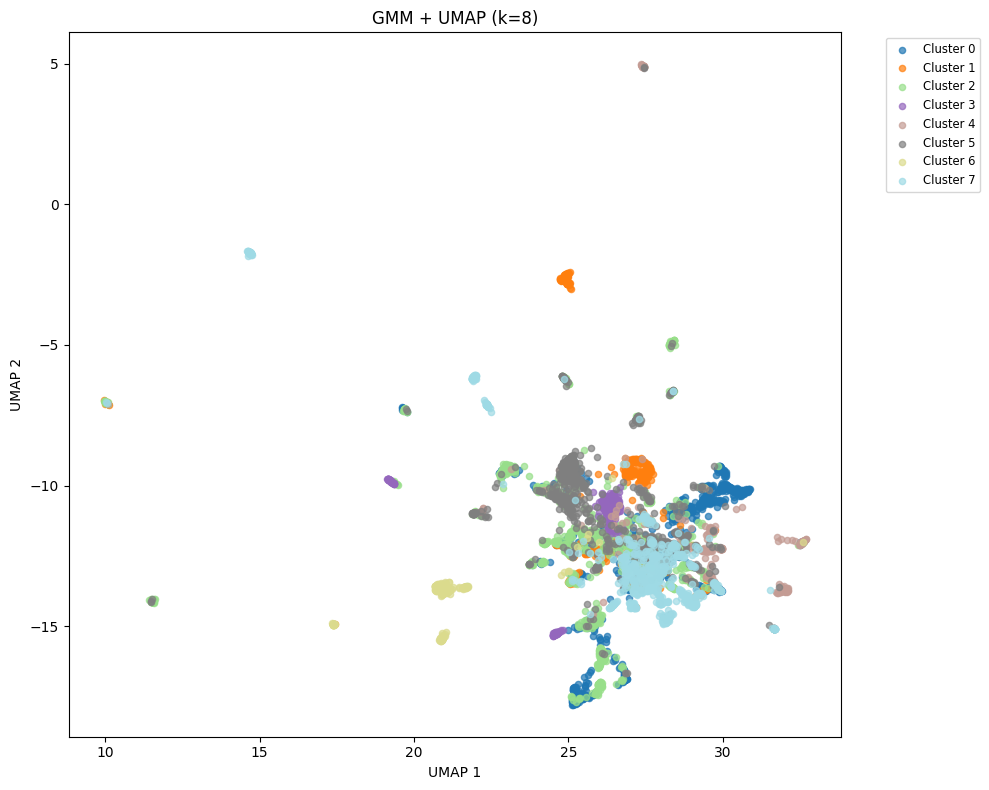

In [283]:
dfgaussian["cluster"] = gaussian_labels

n_components = len(np.unique(gaussian_labels))
cmap = plt.cm.get_cmap("tab20", max(n_components, 1))

plt.figure(figsize=(10, 8))

for c in range(n_components):
    mask = dfgaussian["cluster"] == c
    plt.scatter(
        dfgaussian.loc[mask, "umap1"],
        dfgaussian.loc[mask, "umap2"],
        s=20, alpha=0.7,
        color=cmap(c),
        label=f"Cluster {c}"
    )

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title(f"GMM + UMAP (k={n_components})")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()


## GMM conclusion

GMM is attractive for our project because it produces **soft, probabilistic profiles** (a person can partially belong to multiple components), which fits needs data where boundaries between profiles are often fuzzy.

### What the selected configuration is doing in our data
With the selected configuration (`k = 8`), GMM behaves like a **“balanced multi-profile segmentation”** model:

- It creates **multiple usable profiles** without collapsing into 2–3 overly broad groups.
- The distribution is **reasonably balanced** (`max_share ≈ 0.24`), so no single cluster dominates the dataset.
- Cluster sizes are **operationally safe** (`min_cluster_size = 364`), avoiding unstable micro-components.
- In our interpretability results, profiles are **highly distinct** (`distinctness ≈ 0.97`) with **non-trivial strength** (`≈ 0.29`), meaning each cluster highlights different top-need signals.

### What the plot suggests
The UMAP view shows **overlap in the central mass** with some separated “islands”. That matches GMM’s nature: it can split a mixed region into different **probabilistic components** rather than requiring clean geometric separation.

### Main limitation for our use-case
Internal separation under Euclidean geometry is **not strong** (Silhouette is negative for k=8). So these profiles should be treated as **descriptive / decision-support groupings**, not as sharply separated “true classes”.

### Bottom line
GMM (`k=8`) is a strong candidate for our final pipeline because it gives **several balanced, stable, interpretable profiles** and naturally supports **uncertainty-aware assignment** (via membership probabilities).  
Next, we compare it directly against K-Means, Agglomerative, DBSCAN, and HDBSCAN under the same profile-quality + usability criteria to pick the final model for shelter profiling.

---

---
# **Cross-model comparison (final model selection)**

After tuning each algorithm separately, we will perform a **final cross-model comparison** to decide which clustering approach is most suitable for our project.

## What we compare
For each model (K-Means, Agglomerative, DBSCAN, HDBSCAN, GMM) we already produced a ranked list of configurations using:

- model-specific candidate generation,
- internal metrics (Silhouette / Calinski–Harabasz / Davies–Bouldin),
- and the shared interpretability framework (usability + distinct “top needs” patterns).

Now we compare **models against each other** using only a **small shortlist** of their best configurations.

---

### Step 1) Build a shortlist per model
For each model, we will keep the **top few configurations** (e.g., top 3–5) according to the interpretability ranking.

To ensure the shortlist is not “too narrow”, we will include:
- the **best overall** configuration for that model (highest interpretability),
- the **best configuration under each internal metric** (Silhouette / CH / DB) when it is meaningfully different,
- and (when relevant) a **high-k alternative** (more profiles) if it still meets usability constraints.

This gives a shortlist that represents **different trade-offs** (coarse vs granular, lower noise vs more coverage, etc.) without exploding the search space.

---

## Shortlist per model (from the pasted outputs)

### KMeans
- **Best overall (interpretability):** `KMeans (CH k=18)`
- **CH alternatives / sanity:** `k=34`, `k=50` *(both produce micro-clusters: min_cluster_size 2/1 → heavy penalties)*
- **Coarse metric baseline:** `KMeans (Silhouette k=2)` *(too dominant + distinctness=0)*
- **Extreme-k metric winners (not operational):** `KMeans (DB k=642/658/671)` *(min_cluster_size=1 → unusable profiles)*  
- **Elbow reference (not operational):** `KMeans (Elbow k=146)` *(min_cluster_size=1)*

### Agglomerative (Ward / hierarchical)
- **Best overall (interpretability):** `Agglomerative (Silhouette k=30)` *(same row also DB k=30)*
- **Near-best neighbors:** `k=29`, `k=28`, `k=26` *(all high interpretability, similar trade-off)*
- **Model-specific (dendrogram):** `Agglomerative (Dendrogram k=11)`
- **Coarse metric baseline:** `Agglomerative (Silhouette/CH k=4)`

### DBSCAN
- **Best overall (interpretability):** `DBSCAN (K-distance knee eps=27.70, min_samples=6)`
- **Knee neighbors:** `eps=26.75, ms=4` and `eps=26.61, ms=3` *(similar behavior)*
- **Best by Silhouette (meaningfully different):** `eps=39, ms=4` *(or `eps=37, ms=3` as close alt)*
- **Best by CH (coarse):** `eps=28, ms=15` *(CH family collapses to k=2)*
- **Best by DB:** `eps=37, ms=2` *(similar to DB eps=36/38/39, ms=2)*

### HDBSCAN
- **Best overall (interpretability):** `HDBSCAN (CondensedTree 2nd-best: mcs=20, ms=10)` *(k=28, noise≈0.753)*
- **High-k alternative:** `HDBSCAN (CondensedTree best: mcs=20, ms=5)` *(k=34, noise≈0.704)*
- **Mid-k alternative (metric winner family):** `HDBSCAN (mcs=40, ms=10)` *(k=15, noise≈0.798)*
- **Low-noise coarse alternative:** `HDBSCAN (mcs=50, ms=10)` *(k=4, noise≈0.405)*
- **Coarse 2-cluster baselines:** `HDBSCAN (mcs=25, ms=5)` and `HDBSCAN (mcs=25, ms=10)`



### Step 2) Compare all shortlisted configurations across models
We will merge all shortlisted configurations into a single table and compare them using the same criteria:

1) **Interpretability score (primary)**  
   Because our goal is actionable need profiles, the model that produces the best balance of:
   - manageable number of clusters,
   - usable cluster sizes,
   - reasonable coverage/noise,
   - distinct and meaningful top-need patterns  
   should rank highest.

2) **Internal metrics (secondary, sanity checks)**  
   We use Silhouette / CH / DB to detect obviously weak structure, but we do **not** select purely by these metrics because they can reward unusable solutions.

3) **Operational reliability (qualitative check)**  
   For the top-ranked candidates we will review:
   - cluster size distribution (avoid extreme dominance by one cluster),
   - stability/robustness signals (especially for HDBSCAN),
   - and whether clusters correspond to “real” interpretable profiles (not repeated top features across clusters).


In [285]:
# Compare ALL models + ALL previously-defined configurations in one ranking table

import hdbscan
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

# ---------- Candidates across ALL models ----------
candidates = [
    # ===================== KMEANS =====================
    {"name": "KMeans (CH k=18)",  "estimator": KMeans(n_clusters=18, random_state=42, n_init=10)},
    {"name": "KMeans (CH k=34)",  "estimator": KMeans(n_clusters=34, random_state=42, n_init=10)},
    {"name": "KMeans (CH k=50)",  "estimator": KMeans(n_clusters=50, random_state=42, n_init=10)},
    {"name": "KMeans (Elbow k=146)", "estimator": KMeans(n_clusters=146, random_state=42, n_init=10)},
    {"name": "KMeans (DB k=642)", "estimator": KMeans(n_clusters=642, random_state=42, n_init=10)},
    {"name": "KMeans (DB k=658)", "estimator": KMeans(n_clusters=658, random_state=42, n_init=10)},
    {"name": "KMeans (Silhouette k=658)", "estimator": KMeans(n_clusters=658, random_state=42, n_init=10)},
    {"name": "KMeans (Silhouette k=671)", "estimator": KMeans(n_clusters=671, random_state=42, n_init=10)},
    {"name": "KMeans (DB k=671)", "estimator": KMeans(n_clusters=671, random_state=42, n_init=10)},
    {"name": "KMeans (Silhouette k=2)", "estimator": KMeans(n_clusters=2, random_state=42, n_init=10)},

    # ===================== AGGLOMERATIVE =====================
    {"name": "Agglomerative (Silhouette k=30)", "estimator": AgglomerativeClustering(n_clusters=30)},
    {"name": "Agglomerative (Silhouette k=29)", "estimator": AgglomerativeClustering(n_clusters=29)},
    {"name": "Agglomerative (Silhouette k=28)", "estimator": AgglomerativeClustering(n_clusters=28)},
    {"name": "Agglomerative (DB k=26)",         "estimator": AgglomerativeClustering(n_clusters=26)},
    {"name": "Agglomerative (Dendrogram k=11)", "estimator": AgglomerativeClustering(n_clusters=11)},
    {"name": "Agglomerative (CH k=7)",          "estimator": AgglomerativeClustering(n_clusters=7)},
    {"name": "Agglomerative (CH k=6)",          "estimator": AgglomerativeClustering(n_clusters=6)},
    {"name": "Agglomerative (CH k=5)",          "estimator": AgglomerativeClustering(n_clusters=5)},
    {"name": "Agglomerative (Silhouette k=4)",  "estimator": AgglomerativeClustering(n_clusters=4)},
    {"name": "Agglomerative (Dendrogram k=3)",  "estimator": AgglomerativeClustering(n_clusters=3)},
    {"name": "Agglomerative (Dendrogram k=2)",  "estimator": AgglomerativeClustering(n_clusters=2)},

    # ===================== DBSCAN =====================
    {"name": "DBSCAN (K-distance knee eps=27.70, min_samples=6)",
     "estimator": DBSCAN(eps=27.70, min_samples=6)},
    {"name": "DBSCAN (K-distance knee eps=26.75, min_samples=4)",
     "estimator": DBSCAN(eps=26.75, min_samples=4)},
    {"name": "DBSCAN (K-distance knee eps=26.61, min_samples=3)",
     "estimator": DBSCAN(eps=26.61, min_samples=3)},
    {"name": "DBSCAN (K-distance knee eps=25.55, min_samples=2)",
     "estimator": DBSCAN(eps=25.55, min_samples=2)},
    {"name": "DBSCAN (Silhouette eps=37, min_samples=3)",
     "estimator": DBSCAN(eps=37.0, min_samples=3)},
    {"name": "DBSCAN (DB eps=36, min_samples=2)",
     "estimator": DBSCAN(eps=36.0, min_samples=2)},
    {"name": "DBSCAN (DB eps=37, min_samples=2)",
     "estimator": DBSCAN(eps=37.0, min_samples=2)},
    {"name": "DBSCAN (DB eps=38, min_samples=2)",
     "estimator": DBSCAN(eps=38.0, min_samples=2)},
    {"name": "DBSCAN (DB eps=39, min_samples=2)",
     "estimator": DBSCAN(eps=39.0, min_samples=2)},
    {"name": "DBSCAN (Silhouette eps=35, min_samples=4)",
     "estimator": DBSCAN(eps=35.0, min_samples=4)},
    {"name": "DBSCAN (Silhouette eps=38, min_samples=4)",
     "estimator": DBSCAN(eps=38.0, min_samples=4)},
    {"name": "DBSCAN (Silhouette eps=39, min_samples=4)",
     "estimator": DBSCAN(eps=39.0, min_samples=4)},
    {"name": "DBSCAN (K-distance knee eps=29.33, min_samples=8)",
     "estimator": DBSCAN(eps=29.33, min_samples=8)},
    {"name": "DBSCAN (CH eps=26, min_samples=10)",
     "estimator": DBSCAN(eps=26.0, min_samples=10)},
    {"name": "DBSCAN (CH eps=27, min_samples=10)",
     "estimator": DBSCAN(eps=27.0, min_samples=10)},
    {"name": "DBSCAN (CH eps=28, min_samples=15)",
     "estimator": DBSCAN(eps=28.0, min_samples=15)},
    {"name": "DBSCAN (CH eps=28, min_samples=20)",
     "estimator": DBSCAN(eps=28.0, min_samples=20)},
    {"name": "DBSCAN (K-distance knee eps=28.91, min_samples=10)",
     "estimator": DBSCAN(eps=28.91, min_samples=10)},
    {"name": "DBSCAN (K-distance knee eps=30.16, min_samples=15)",
     "estimator": DBSCAN(eps=30.16, min_samples=15)},
    {"name": "DBSCAN (K-distance knee eps=30.44, min_samples=20)",
     "estimator": DBSCAN(eps=30.44, min_samples=20)},

    # ===================== HDBSCAN =====================
    {"name": "HDBSCAN (CondensedTree 2nd-best: mcs=20, ms=10) [k=28, noise≈0.753]",
     "estimator": hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10)},
    {"name": "HDBSCAN (CondensedTree best: mcs=20, ms=5) [k=34, noise≈0.704]",
     "estimator": hdbscan.HDBSCAN(min_cluster_size=20, min_samples=5)},
    {"name": "HDBSCAN (CH best: mcs=50, ms=5) [k=13, noise≈0.786]",
     "estimator": hdbscan.HDBSCAN(min_cluster_size=50, min_samples=5)},
    {"name": "HDBSCAN (Silhouette high-k alt: mcs=40, ms=10) [k=15, noise≈0.798]",
     "estimator": hdbscan.HDBSCAN(min_cluster_size=40, min_samples=10)},
    {"name": "HDBSCAN (CondensedTree lower-noise alt: mcs=50, ms=10) [k=4, noise≈0.405]",
     "estimator": hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10)},
    {"name": "HDBSCAN (DB best: mcs=25, ms=10) [k=2, noise≈0.116]",
     "estimator": hdbscan.HDBSCAN(min_cluster_size=25, min_samples=10)},
    {"name": "HDBSCAN (Silhouette best: mcs=25, ms=5) [k=2, noise≈0.098]",
     "estimator": hdbscan.HDBSCAN(min_cluster_size=25, min_samples=5)},

    # ===================== GMM =====================
    {"name": "GMM (BIC runner-up k=8)",  "estimator": GaussianMixture(n_components=8,  covariance_type="full", random_state=42)},
    {"name": "GMM (BIC k=3)",           "estimator": GaussianMixture(n_components=3,  covariance_type="full", random_state=42)},
    {"name": "GMM (Silhouette k=2)",    "estimator": GaussianMixture(n_components=2,  covariance_type="full", random_state=42)},
    {"name": "GMM (BIC runner-up k=4)", "estimator": GaussianMixture(n_components=4,  covariance_type="full", random_state=42)},
    {"name": "GMM (BIC runner-up k=5)", "estimator": GaussianMixture(n_components=5,  covariance_type="full", random_state=42)},
    {"name": "GMM (AIC k=34)",          "estimator": GaussianMixture(n_components=34, covariance_type="full", random_state=42)},
    {"name": "GMM (AIC runner-up k=35)","estimator": GaussianMixture(n_components=35, covariance_type="full", random_state=42)},
    {"name": "GMM (AIC runner-up k=36)","estimator": GaussianMixture(n_components=36, covariance_type="full", random_state=42)},
    {"name": "GMM (AIC runner-up k=37)","estimator": GaussianMixture(n_components=37, covariance_type="full", random_state=42)},
    {"name": "GMM (DB runner-up k=38)", "estimator": GaussianMixture(n_components=38, covariance_type="full", random_state=42)},
    {"name": "GMM (Davies–Bouldin k=40)","estimator": GaussianMixture(n_components=40, covariance_type="full", random_state=42)},
]

# Use the same "clean features" you used everywhere else
df_features_clean = dfkmean.drop(columns=["umap1", "umap2", "cluster"], errors="ignore").copy()

ranked, best_name, best_labels, best_profiles = evaluate_candidates(
    candidates=candidates,
    X_fit=X_scaled,
    df_features=df_features_clean,
    silhouette_sample=min(2000, X_scaled.shape[0]),
)

print(ranked[[
    "candidate","interpretability","silhouette","calinski_harabasz","davies_bouldin",
    "k","effective_k","noise_ratio","max_share",
    "min_cluster_size","size_penalty","micro_penalty",
    "k_penalty","noise_penalty","dominance_penalty","balance_penalty",
    "strength","distinctness"
]].to_string(index=False, float_format=lambda x: f"{x:0.6f}"))

print("\nBEST OVERALL:", best_name)
print("\nBest cluster profiles (sorted by size):")
print(best_profiles[["cluster","n","%","top_features","top_lifts"]].to_string(index=False, float_format=lambda x: f"{x:0.6f}"))

best_estimator = next(c["estimator"] for c in candidates if c["name"] == best_name)

                                                                candidate  interpretability  silhouette  calinski_harabasz  davies_bouldin   k  effective_k  noise_ratio  max_share  min_cluster_size  size_penalty  micro_penalty  k_penalty  noise_penalty  dominance_penalty  balance_penalty  strength  distinctness
                                          Agglomerative (Silhouette k=30)          0.408604   -0.018536          58.063049        3.600232  30    13.300582     0.000000   0.191157                23      1.000000       1.000000   1.000000       1.000000           1.000000         1.000000  0.420096      0.972644
                                          Agglomerative (Silhouette k=29)          0.407058   -0.019642          58.805105        3.649962  29    13.291030     0.000000   0.191157                35      1.000000       1.000000   1.000000       1.000000           1.000000         1.000000  0.418750      0.972079
                                          Agglomerative (Silh

### Special note on noise-based models (DBSCAN / HDBSCAN)
Density-based models may label many points as **noise** (`-1`).  
High noise can be risky operationally because, for new people, the model may frequently return “unassigned”.

In this project we treat noise in two possible ways:
- **Accept noise as a valid outcome**: “this person does not fully match any learned profile”, and we still show their most important features to support staff decisions.
- **Prefer higher coverage** when noise becomes too large, because profiles are only useful if most cases can be assigned.

Which approach wins depends on the final trade-off between **coverage** and **profile quality**.

---

---
# Final conclusion (model selection)

After applying the **same three-step selection process** to every model:

1) **Model-specific tool** (to propose reasonable candidates),
2) **Internal metrics** (Silhouette / CH / DB for fair comparison),
3) **Shared interpretability framework** (sizes + manageable profiles + coverage/noise + distinct patterns + penalties),

the best overall configuration is:

**BEST OVERALL: `Agglomerative (Silhouette k=30)`**

It wins because it achieves the strongest **balance between usability and interpretability** under our project constraints:

- **Manageable granularity:** `k = 30` produces a *rich set of need profiles* without exploding into micro-clusters.
- **Usable cluster sizes:** `min_cluster_size = 23` stays above our operational threshold (no tiny “one-off” profiles).
- **Good practical coverage:** `noise_ratio = 0.0` means every person is assigned to a profile (important for a shelter tool).
- **No penalty triggers:** size/micro/k/noise/dominance/balance penalties are all `1.0`, so the score reflects *real interpretability* rather than being propped up by loopholes.
- **Clear differentiation:** high **distinctness** (`≈ 0.973`) means clusters tend to show different “top needs” signatures instead of repeating the same features.

### Why the other models do not win (with our project constraints)

- **HDBSCAN (best candidates):** although it yields strong distinctness and good internal metrics in some settings, the **noise ratio is extremely high** for the high-k solutions (≈ 0.70–0.80).  
  This is risky for deployment: many cases may come back as **unassigned (-1)**, meaning staff often get *no profile* unless we build a fallback system.  
  Noise can be acceptable as “no clear match”, but at these levels it becomes a coverage problem for an operational tool.

- **DBSCAN:** several configurations show good internal metrics, but most of the solutions collapse into **one dominant cluster** (very high `max_share`) or produce near-trivial effective cluster structure (`effective_k ≈ 1`).  
  That fails our goal of producing **multiple actionable profiles**.

- **K-Means / GMM:** they can produce workable partitions, but in our scoring they are consistently hurt by **micro-cluster risk** (very small `min_cluster_size` in high-k solutions) or by selecting **too coarse** solutions (k≈2–4) that are not informative enough for shelter decision-making.  
  Their internal metrics can look “good” in some cases, but the resulting profiles are less aligned with our “many usable profiles” target.

### Practical meaning for the project
Using **Agglomerative (k=30)** gives us a set of **always-available** profiles (no noise) that are:
- large enough to be stable and actionable,
- diverse enough to represent different need patterns,
- and easy to communicate (each cluster can be explained by its top features / lifts).

**Recommendation:** proceed with `Agglomerative (Silhouette k=30)` as the final clustering baseline for the system, and optionally keep **HDBSCAN as a secondary analysis tool** (useful for exploring density structure), but not as the primary operational classifier unless we design a robust fallback for noise/unassigned cases.